(chap1bis)=

# 2. Exploratory Analysis of Bayesian Models

As we saw in Chapter [1](chap1), Bayesian inference is about
conditioning models to the available data and obtaining posterior
distributions. We can do this using pen and paper, computers, or other
devices [^1]. Additionally we can include, as part of the inference
process, the computation of other quantities like the prior and
posterior predictive distributions. However, Bayesian modeling is wider
than inference. While it would be nice if Bayesian modeling was as
simple as specifying model and calculating a posterior, it is typically
not. The reality is that other equally important tasks are needed for
successful Bayesian data analysis. In this chapter we will discuss some
of these tasks, including checking model assumptions, diagnosing
inference results, and model comparison.

[^1]: <https://www.countbayesie.com/blog/2015/2/18/bayes-theorem-with-lego>

(there-is-life-after-inference-and-before-too)=

## 2.1 There is Life After Inference, and Before Too!

A successful Bayesian modeling approach requires performing additional
tasks beyond inference [^2]. Such as:

-   Diagnosing the quality of the inference results obtained using
    numerical methods.

-   Model criticism, including evaluations of both model assumptions and
    model predictions.

-   Comparison of models, including model selection or model averaging.

-   Preparation of the results for a particular audience.

These tasks require both numerical and visual summaries to help
practitioners analyze their models. We collectively call these tasks
**Exploratory Analysis of Bayesian Models**. The name is taken from the
statistical approach known as Exploratory Data Analysis (EDA)
{cite:p}`tukey77`. This approach to data analysis aims at summarizing the main
characteristics of a data set, often with visual methods. In the words
of Persi Diaconis {cite:p}`Diaconis2011`:


> Exploratory data analysis (EDA) seeks to reveal structure, or simple
> descriptions, in data. We look at numbers or graphs and try to find
> patterns. We pursue leads suggested by background information,
> imagination, patterns perceived, and experience with other data
> analyses.


EDA is generally performed before, or even instead of, an inferential
step. We, as many others before us
{cite:p}`gabry_visualization_2017, Gelman2020`, think that many of the ideas
from EDA can be used, reinterpreted and expanded into a robust Bayesian
modeling approach. In this book we will mainly use the Python library
ArviZ [^3] {cite:p}`Kumar2019` to help us perform exploratory analysis of
Bayesian models.

In a real life setting, Bayesian inference and exploratory analysis of
Bayesian models get tangled into an iterative workflow, that includes
silly coding mistakes, computational problems, doubts about the adequacy
of models, doubts about our current understanding of the data,
non-linear model building, model checking, etc. Trying to emulate this
intricate workflow in a book is challenging. Thus throughout these pages
we may omit some or even all the exploratory analysis steps or maybe
leave them as exercises. This is not because they are not necessary or
not important. On the contrary during writing this book we have
performed many iterations "behind the scenes\". However, we omit them in
certain areas so focus on other relevant aspects such as model details,
computational features, or fundamental mathematics.

[^2]: We are omitting tasks related to obtaining the data in the first
    place, but experimental design can be as critical if not more than
    other aspects in the statistical analysis, see Chapter
    [9](chap10).

[^3]: <https://arviz-devs.github.io/arviz/>

(prior_predictive_checks)=

## 2.2 Understanding Your Assumptions

As we discussed in Section {ref}`make_prior_count`, "what is
the best-ever prior?\" is a tempting question to ask. However, it is
difficult to give a straight satisfying answer other than: "it
depends\". We can certainly find default priors for a given model or
family of models that will yield good results for a wide range of
datasets. But we can also find ways to outperform them for particular
problems if we can generate more informative priors for those specific
problems. Good default priors can serve as good priors for quick/default
analysis and also as good placeholder for better priors if we can invest
the time and effort to move into an iterative, exploratory Bayesian
modelling workflow.

One problem when choosing priors is that it may be difficult to
understand their effect as they propagate down the model into the data.
The choices we made in the parameter space may induce something
unexpected in the observable data space. A very helpful tool to better
understand our assumptions is the prior predictive distribution, which
we presented in Section {ref}`Bayesian_inference` and
Equation [eq:prior_pred_dist](eq:prior_pred_dist). In practice we
can compute a prior predictive distribution by sampling from the model,
but without conditioning on the observed data. By sampling from the
prior predictive distribution, the computer does the work of translating
choices we made in the parameter space into the observed data space.
Using these samples to evaluate priors is known as **prior predictive
checks**.

Let us assume we want to build a model of football (or soccer for the
people in USA). Specifically we are interested in the probability of
scoring goals from the penalty point. After thinking for a while we
decide to use a geometric model [^4]. Following the sketch in
{numref}`fig:football_sketch` and a little bit of trigonometry we come
up with the following formula for the probability of scoring a goal:

```{math}
:label: eq:geometric_football
p\left(|\alpha| < \tan^{-1}\left(\frac{L}{x}\right)\right) = 2\Phi\left(\frac{\tan^{-1}\left(\frac{L}{x}\right)}{\sigma}\right) - 1

```

The intuition behind Equation {eq}`eq:geometric_football` is that we are
assuming the probability of scoring a goal is given by the absolute
value of the angle $\alpha$ being less than a threshold
$\tan^{-1}\left(\frac{L}{x}\right)$. Furthermore we are assuming that
the player is trying to kick the ball straight, i.e at a zero angle, but
then there are other factors that result in a trajectory with a
deviation $\sigma$.

```{figure} figures/football_sketch.png
:name: fig:football_sketch
:width: 4in
Sketch of a penalty shot. The dashed lines represent the angle $\alpha$
within which the ball must be kicked to score a goal. $x$ represents the
reglementary distance for a penalty shot (11 meters) and $L$ half the
length of a reglementary goal mouth (3.66 meters).
```

The only unknown quantity in Equation {eq}`eq:geometric_football` is
$\sigma$. We can get the values of $L$ and $x$ from the rules of
football. As good Bayesians, when we do not know a quantity, we assign a
prior to it and then try to build a Bayesian model, for example, we
could write:

```{math}
:label: eq:geometric_model
\begin{split}
\sigma &\sim \mathcal{HN}(\sigma_{\sigma}) \\
\text{p\_goal} &= 2\Phi\left(\frac{\tan^{-1}\left(\frac{L}{x}\right)}{\sigma}\right) - 1 \\
Y &\sim \text{Bin}(n=1, p=\texttt{p\_goal})

\end{split}
```

At this point we are not entirely certain how well our model encodes our
domain knowledge about football, so we decide to first sample from the
prior predictive to gain some intuition.
{numref}`fig:prior_predictive_check_00` shows the results for three
priors (encoded as three values of $\sigma_{\sigma}$, 5, 20, and 60
degrees). The gray circular area represents the set of angles that
should lead to scoring a goal assuming that the player kicks the ball
completely straight and no other factors come in play like wind,
friction, etc. We can see that our model assumes that it is possible to
score goals even if the player kicks the ball with a greater angle than
the gray area. Interestingly enough for large values of
$\sigma_{\sigma}$ the model thinks that kicking in the opposite
direction is not that bad idea.

```{figure} figures/prior_predictive_distributions_00.png
:name: fig:prior_predictive_check_00
:width: 8.00in
Prior predictive checks for the model in Equation
{eq}`eq:geometric_model`. Each subplot corresponds to a different value
of the prior for $\sigma$. The black dot at the center of each circular
plot represents the penalty point. The dots at the edges represent
shots, the position is the value of the angle $\alpha$ (see
{numref}`fig:football_sketch`), and the color represents the probability
of scoring a goal.
```

[^4]: This example has been adapted from
    <https://mc-stan.org/users/documentation/case-studies/golf.html> and
    <https://docs.pymc.io/notebooks/putting_workflow.html>

In [1]:
%matplotlib inline
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
from scipy import stats

In [2]:
az.style.use("arviz-grayscale")
plt.rcParams['figure.dpi'] = 300
np.random.seed(5201)

In [3]:
half_length = 3.66  # meters
penalty_point = 11  # meters
def Phi(x):
    """Calculates the standard normal cumulative distribution function."""
    return 0.5 + 0.5 * pm.math.erf(x / (2.0)**0.5)


ppss = []
sigmas_deg = [5, 20, 60]
sigmas_rad = np.deg2rad(sigmas_deg)
for sigma in sigmas_rad:
    with pm.Model() as model:
        σ = pm.HalfNormal("σ", sigma)
        α = pm.Normal("α", 0, σ)
        p_goal = pm.Deterministic("p_goal", 2 * Phi(pm.math.arctan(half_length / penalty_point) / σ) - 1)
        pps = pm.sample_prior_predictive(250)
        ppss.append(pps)

Sampling: [α, σ]
Sampling: [α, σ]
Sampling: [α, σ]


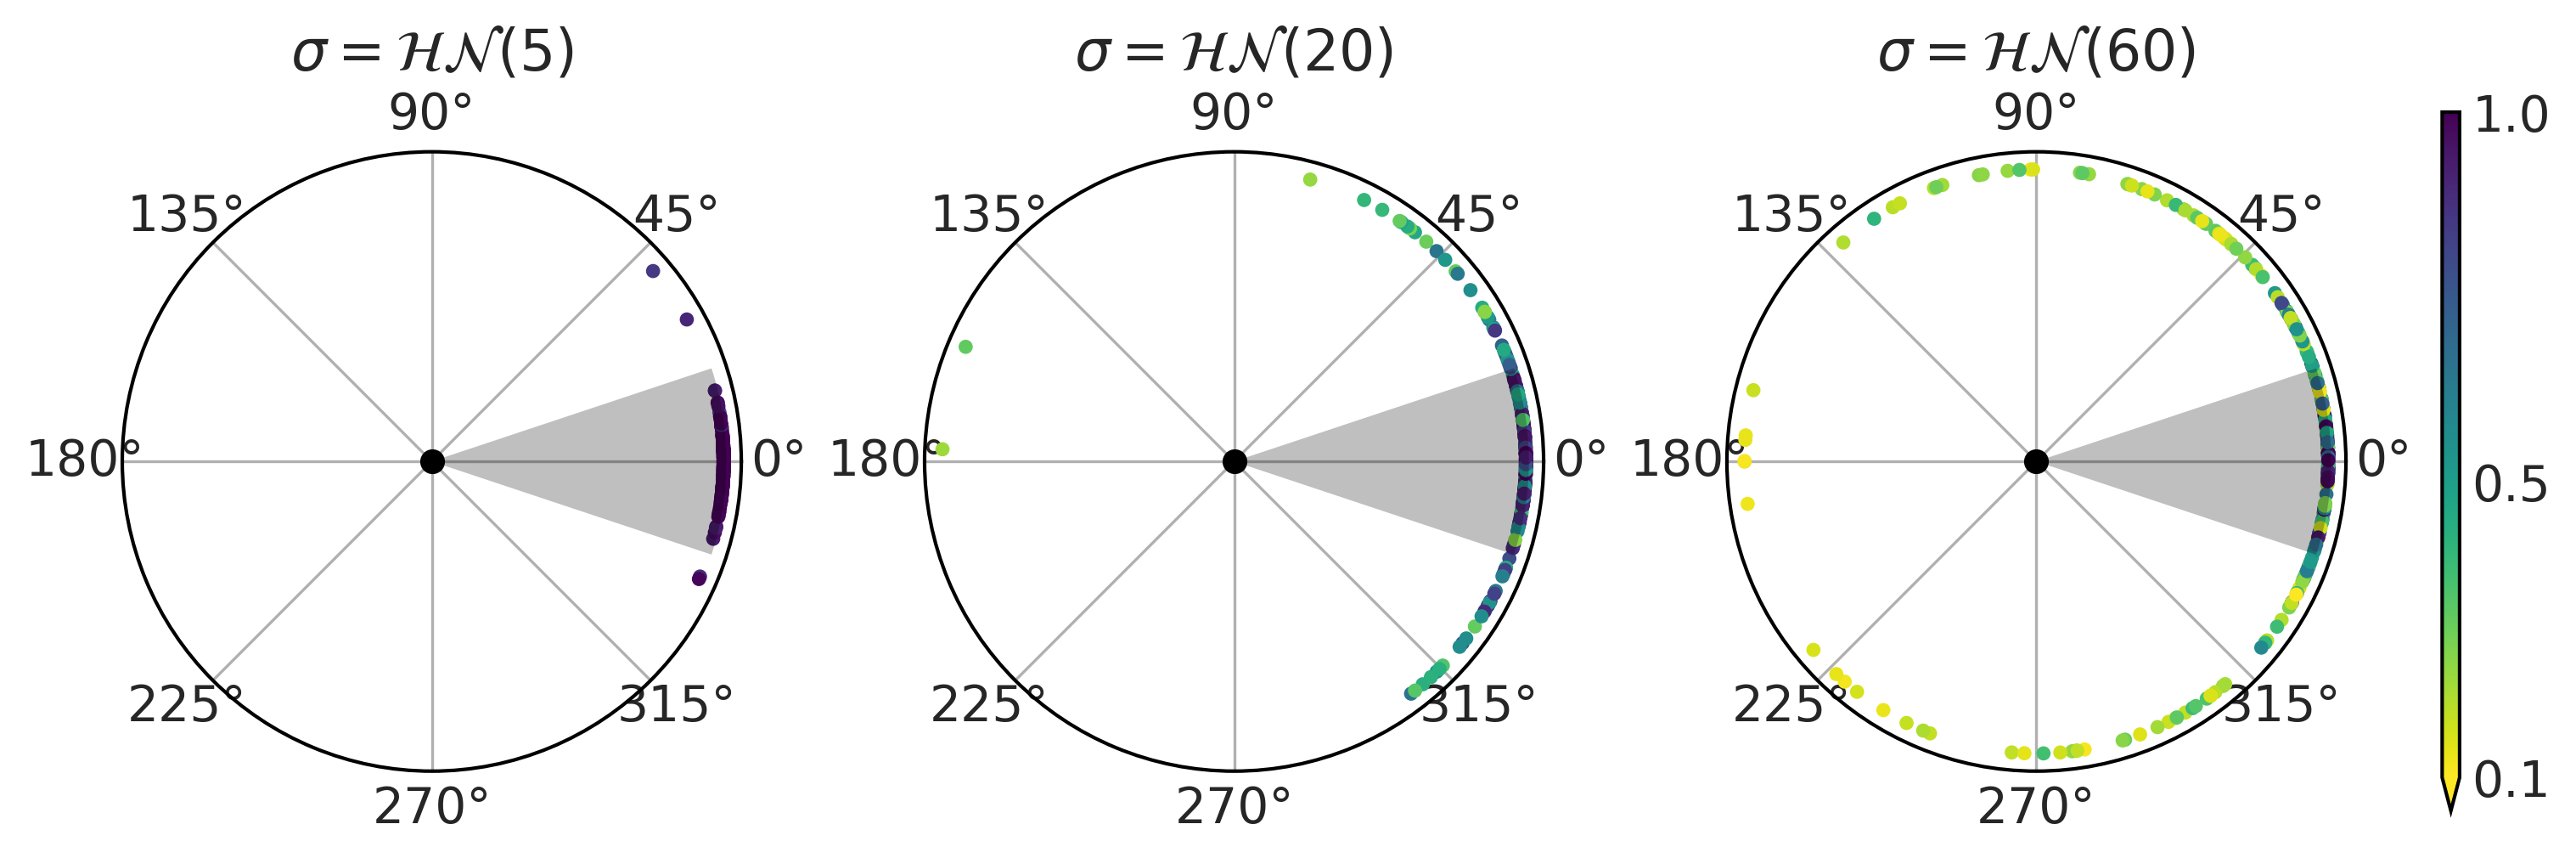

In [4]:
fig, axes = plt.subplots(1, 3, subplot_kw=dict(projection="polar"), figsize=(10, 4))

max_angle = np.arctan(half_length/penalty_point)

for sigma, pps, ax in zip(sigmas_deg, ppss, axes):
    cutoff = pps.prior["p_goal"] > 0.1
    values = pps.prior["α"].where(cutoff)
    cax = ax.scatter(values, np.ones_like(values), c=pps.prior["p_goal"].where(cutoff),
               marker=".", cmap="viridis_r", vmin=0.1)
    ax.fill_between(np.linspace(-max_angle, max_angle, 100), 0, 1.01, alpha=0.25)
    ax.set_yticks([])
    ax.set_title(f"$\sigma = \mathcal{{HN}}({sigma})$")
    ax.plot(0,0, 'o')
fig.colorbar(cax, extend="min", ticks=[1, 0.5, 0.1], shrink=0.7, aspect=40)

plt.savefig("img/chp02/prior_predictive_distributions_00.png", bbox_inches="tight")

At this point we have a few alternatives: we can rethink our model to
incorporate further geometric insights. Alternatively we can use a prior
that reduces the chance of nonsensical results even if we do not exclude
them completely, or we can just fit the data and see if the data is
informative enough to estimate a posterior that excludes nonsensical
values. {numref}`fig:prior_predictive_check_01` shows another example of
what we may consider unexpected [^5]. The example shows how for a
logistic regression [^6] with binary predictors and priors
$\mathcal{N}(0, 1)$ on the regression coefficients. As we increase the
number of predictors, the mean of the prior predictive distributions
shifts from being more concentrated around 0.5 (first panel) to Uniform
(middle) to favor extreme, 0 or 1, values (last panel). This example
shows us that as the number of predictors increase, the induced prior
predictive distribution puts more mass on extreme values. Thus we need a
*stronger regularizing prior* (e.g., Laplace distribution) in order to
keep the model away from those extreme values.

```{figure} figures/prior_predictive_distributions_01.png
:name: fig:prior_predictive_check_01
:width: 8.00in
Prior predictive distribution for a logistic regression models with 2,
5, or 15 binary predictors and with 100 data points. The KDE represents
the distributions of the mean of the simulated data over 10000
simulations. Even when the prior for each coefficient,
$\mathcal{N}(0, 1)$, is the same for all 3 panels, increasing the
numbers of the predictor is effectively equivalent to using a prior
favoring extreme values.
```

[^5]: The example has been adapted from {cite:p}`Gelman2020`.

[^6]: See Chapter [3](chap2) for details of the logistic
    regression model.

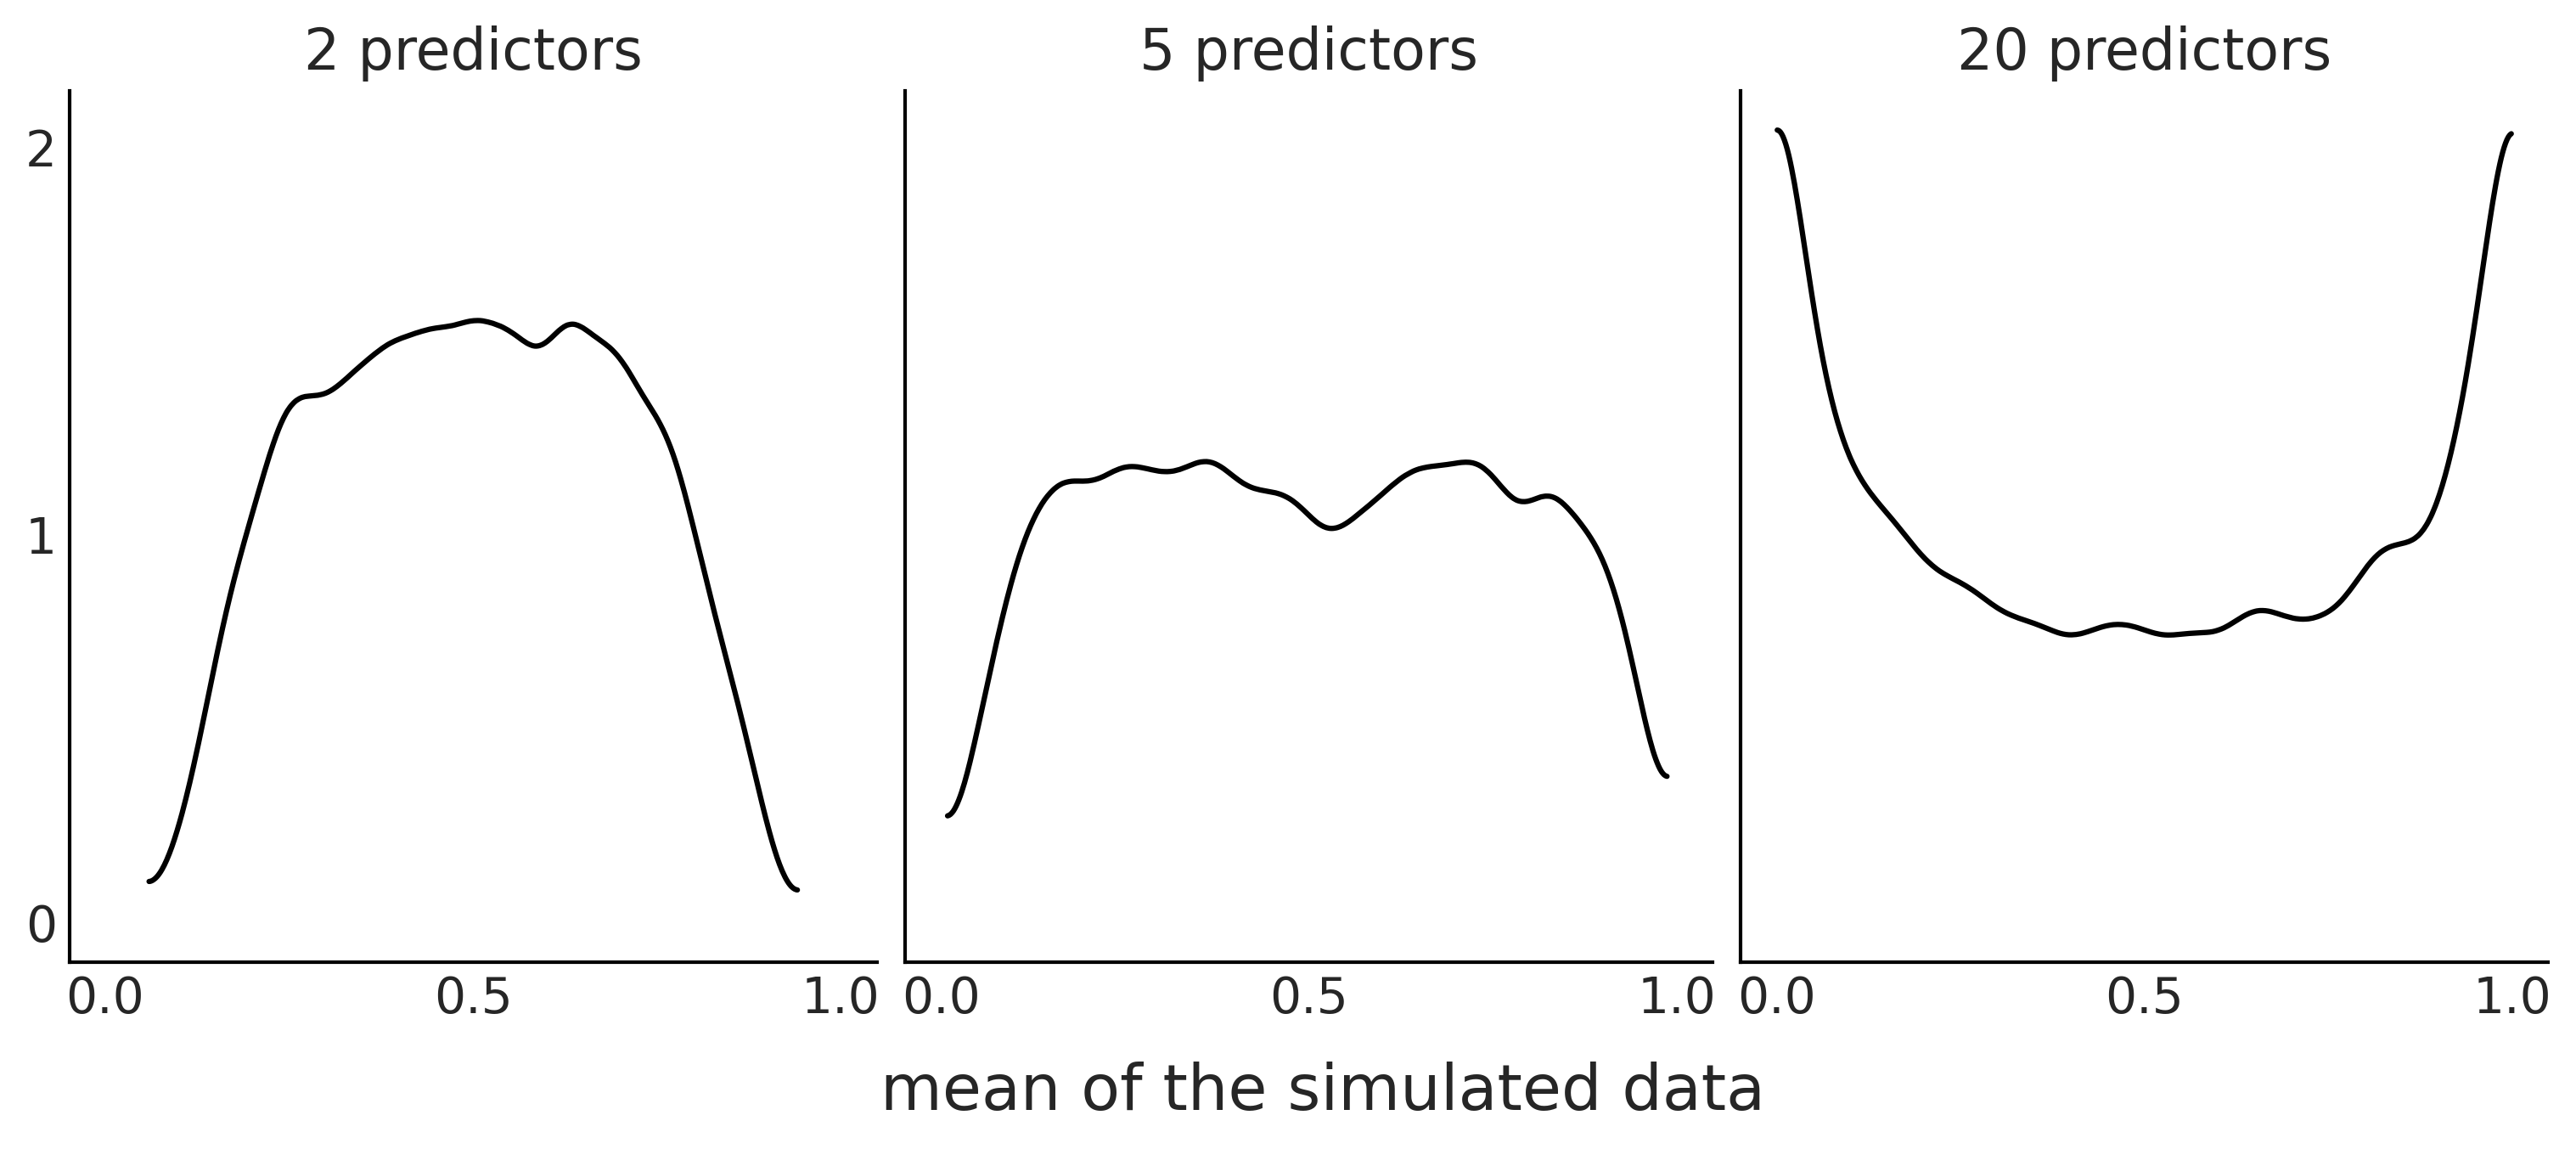

In [5]:
from scipy.special import expit
fig, axes = plt.subplots(1, 3, figsize=(10, 4), sharex=True,  sharey=True)
axes = np.ravel(axes)

for dim, ax in zip([2, 5, 20], axes):
    β = np.random.normal(0, 1, size=(10000, dim))
    X = np.random.binomial(n=1, p=0.75, size=(dim, 500))
    az.plot_kde(expit(β @ X).mean(1), ax=ax)
    ax.set_title(f"{dim} predictors")
    ax.set_xticks([0, 0.5, 1])
    ax.set_yticks([0, 1, 2])

fig.text(0.34, -0.075, size=18, s="mean of the simulated data")
plt.savefig("img/chp02/prior_predictive_distributions_01.png", bbox_inches="tight")

Both previous examples show that priors can not be understood in
isolation, we need to put them in the context of a particular model. As
thinking in terms of observed values is generally easier than thinking
in terms of the model's parameters, prior predictive distributions can
help make model evaluation easier. This becomes even more useful for
complex models where parameters get transformed through many
mathematical operations, or multiple priors interact with each other.
Additionally, prior predictive distributions can be used to present
results or discuss models in a more intuitive way to a wide audience. A
domain expert may not be familiar with statistical notation or code and
thus using those devices may not lead to a productive discussion, but if
you show them the implications of one or more models, you provide them
more material to discuss. This can provide valuable insight both for
your domain partner and yourself. And again computing the prior
predictive has other advantages, such as helping us debug models,
ensuring they are properly written and able to run in our computational
environment.

(posterior_pd)=

## 2.3 Understanding Your Predictions

As we can use synthetic data, that is generated data, from the prior
predictive distribution to help us inspect our model, we can perform a
similar analysis with the posterior predictive distribution, introduced
in Section {ref}`Bayesian_inference` and Equation
[eq:post_pred_dist](eq:post_pred_dist). This procedure is generally
referred as **posterior predictive checks**. The basic idea is to
evaluate how close the synthetic observations are to the actual
observations. Ideally the way we assess closeness should be
problem-dependent, but we can also use some general rules. We may even
want to use more than one metric in order to assess different ways our
models (mis)match the data.

{numref}`fig:posterior_predictive_check` shows a very simple example for
a binomial model and data. On the left panel we are comparing the number
of observed successes in our data (blue line) with the number of
predicted successes over 1000 samples from the posterior predictive
distribution. On the right panel is an alternative way of representing
the results, this time showing the proportion of success and failures in
our data (blue line) against 1000 samples from the posterior
distribution. As we can see the model is doing a very good job at
capturing the mean value in this case, even when the model recognizes
there is a lot of uncertainty. We should not be surprised that the model
is doing a good job at capturing the mean. The reason is that we are
directly modeling the mean of the binomial distribution. In the next
chapters we will see examples when posterior predictive checks provide
less obvious and thus more valuable information about our model's fit to
the data.

```{figure} figures/posterior_predictive_check.png
:name: fig:posterior_predictive_check
:width: 8.00in
Posterior predictive check for a Beta-Binomial model. On the left panel
we have the number of predicted success (gray histogram), the dashed
black line represents the mean predicted success. The blue line is the
mean computed from the data. On the right panel we have the same
information but represented in an alternative way. Instead of the number
of success we are plotting the probability of getting 0's or 1's. We are
using a line to represent that the probability of $p(y=0) = 1-p(y=1)$.
the dashed black line is the mean predicted probability, and the blue
line is the mean computed from the data.
```

In [6]:
Y = stats.bernoulli(0.7).rvs(100)
with pm.Model() as model:
    θ = pm.Beta("θ", 1, 1)
    y_obs = pm.Binomial("y_obs",n=1, p=θ, observed=Y)
    idata_b = pm.sample(1000)
    idata_b.extend(pm.sample_posterior_predictive(idata_b))

Sampling ... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:00:00

In [7]:
pred_dist = az.extract(idata_b, group="posterior_predictive", num_samples=1000)["y_obs"].values
pred_dist.sum(0).shape

(1000,)

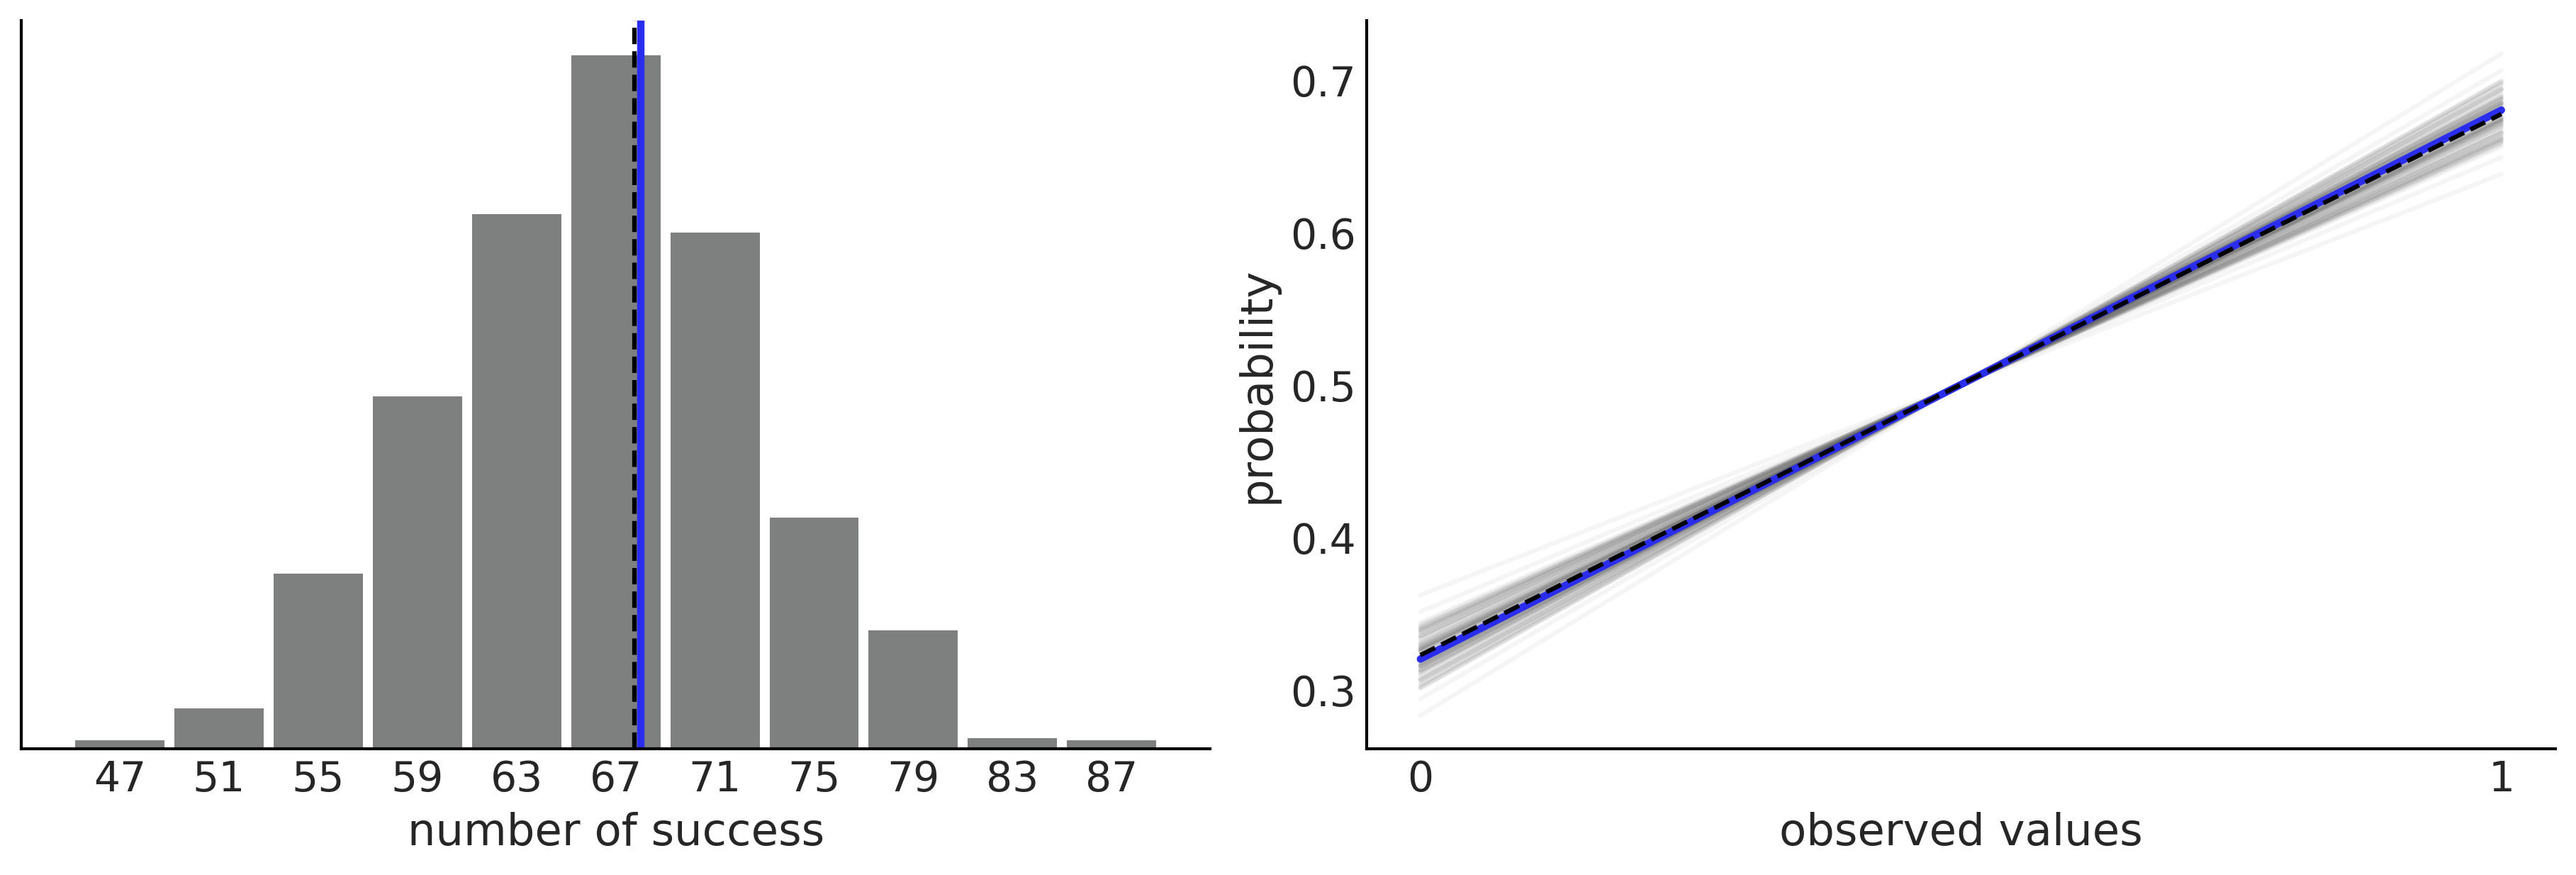

In [8]:
_, ax = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)

az.plot_dist(pred_dist.sum(0),
             hist_kwargs={"color":"C2"}, ax=ax[0])
ax[0].axvline(Y.sum(), color="C4", lw=2.5)
ax[0].axvline(pred_dist.sum(0).mean(), color="k", ls="--")
ax[0].set_yticks([])
ax[0].set_xlabel("number of success")

pps_ = pred_dist.mean(1)
ax[1].plot((np.zeros_like(pps_), np.ones_like(pps_)), (1-pps_, pps_), 'C1', alpha=0.05)

ax[1].plot((0, 1), (1-Y.mean(), Y.mean()), 'C4', lw=2.5)
ax[1].plot((0, 1), (1-pps_.mean(), pps_.mean()), 'k--')
ax[1].set_xticks((0,1))
ax[1].set_xlabel("observed values")
ax[1].set_ylabel("probability")
plt.savefig("img/chp02/posterior_predictive_check.png")

Posterior predictive checks are not restricted to plots. We can also
perform numerical tests {cite:p}`GelmanBayesianDataAnalysis2013`. One way of
doing this is by computing:

```{math}
:label: eq:post_pred_test_quantity
p_{B} = p(T_{sim} \leq T_{obs} \mid \tilde Y)

```

where $p_{B}$ is a Bayesian p-value and is defined as the probability
the simulated test statistic $T_{sim}$ is less or equal than the
observed statistic $T_{obs}$. The statistic $T$ is basically any metric
we may want to use to assess our models fit to the data. Following the
binomial example we can choose $T_{obs}$ as the observed success rate
and then compare it against the posterior predictive distribution
$T_{sim}$. The ideal value of $p_{B}=0.5$ means that we compute a
$T_{sim}$ statistic that half the time is below and half the time above
the observed statistics $T_{obs}$, which is the expected outcome for a
good fit.

Because we love plots, we can also create plots with Bayesian p-values.
The first panel of {numref}`fig:posterior_predictive_check_pu_values`
shows the distribution of Bayesian p-values in black solid line, the
dashed line represents the expected distribution for a dataset of the
same size. We can obtain such a plot with ArviZ
`az.plot_bpv(., kind="p_value")`. The second panel is conceptually
similar, the twist is that we evaluate how many of the simulations are
below (or above) the observed data "per observation\". For a
well-calibrated model, all observations should be equally well
predicted, that is the expected number of predictions above or below
should be the same. Thus we should get a Uniform distribution. As for
any finite dataset, even a perfectly calibrated model will show
deviations from a Uniform distribution, we plot a band where we expected
to see 94% of the Uniform-like curves.

::: {admonition} Bayesian p-values

We call $p_{B}$ Bayesian p-values as the quantity in
Equation {eq}`eq:post_pred_test_quantity` is essentially the definition
of a p-value, and we say they are Bayesian because, instead of using the
distribution of the statistic $T$ under the null hypothesis as the
sampling distribution we are using the posterior predictive
distribution. Notice that we are not conditioning on any null
hypothesis. Neither are we using any predefined threshold to declare
statistical significance or to perform hypothesis testing.
:::

```{figure} figures/posterior_predictive_check_pu_values.png
:name: fig:posterior_predictive_check_pu_values
:width: 8.00in
Posterior predictive distribution for a Beta-Binomial model. In the
first panel, the curve with the solid line is the KDE of the proportion
of predicted values that are less or equal than the observed data. The
dashed lines represent the expected distribution for a dataset of the
same size as the observed data. On the second panel, the black line is a
KDE for the proportion of predicted values that are less or equal than
the observed computed per observation instead of over each simulation as
in the first panel. The white line represents the ideal case, a standard
Uniform distribution, and the gray band deviations of that Uniform
distribution that we expect to see for a dataset of the same size.
```

As we said before we can choose from many $T$ statistics to summarize
observations and predictions.
{numref}`fig:posterior_predictive_check_tstat` shows two examples, in
the first panel $T$ is the mean and in the second one $T$ is the
standard deviation. The curves are KDEs representing the distribution of
the $T$ statistics from the posterior predictive distribution and the
dot is the value for the observed data.

```{figure} figures/posterior_predictive_check_tstat.png
:name: fig:posterior_predictive_check_tstat
:width: 8.00in
Posterior predictive distribution for a Beta-Binomial model. In the
first panel, the curve with the solid line is the KDE of the proportion
of simulations of predicted values with mean values less or equal than
the observed data. On the second panel, the same but for the standard
deviation. The black dot represented the mean (first panel) or standard
deviation (second panel) computed from the observed data.
```

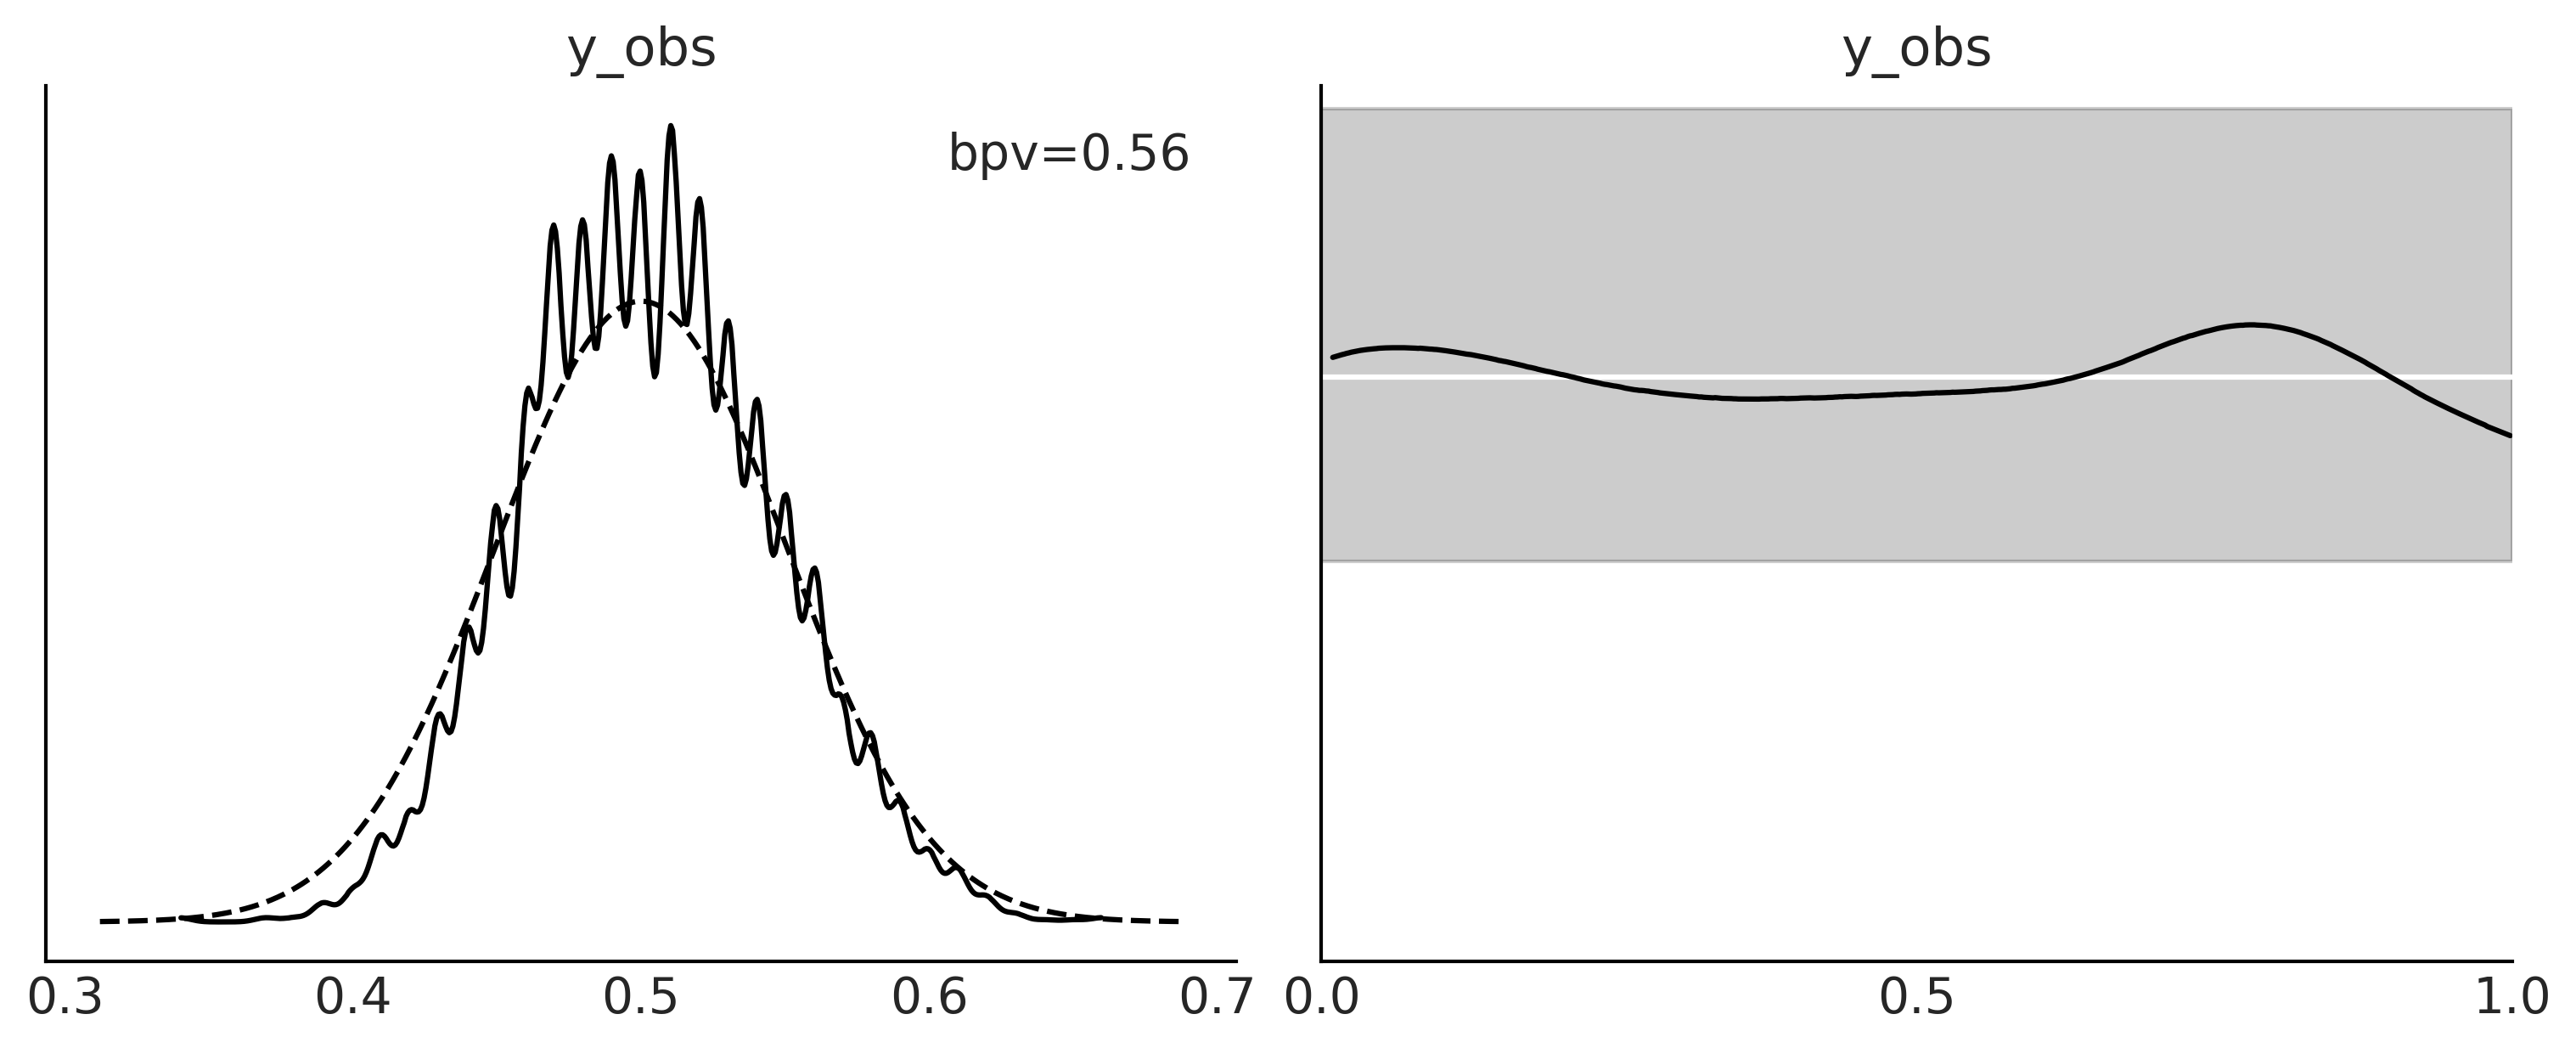

In [9]:
_, ax = plt.subplots(1, 2, figsize=(10, 4))
az.plot_bpv(idata_b, kind="p_value", ax=ax[0])
ax[0].legend([f"bpv={(Y.mean() > pred_dist.mean(1)).mean():.2f}"], handlelength=0)
az.plot_bpv(idata_b, kind="u_value", ax=ax[1])
ax[1].set_yticks([])
ax[1].set_xticks([0., 0.5, 1.])
plt.savefig("img/chp02/posterior_predictive_check_pu_values.png")

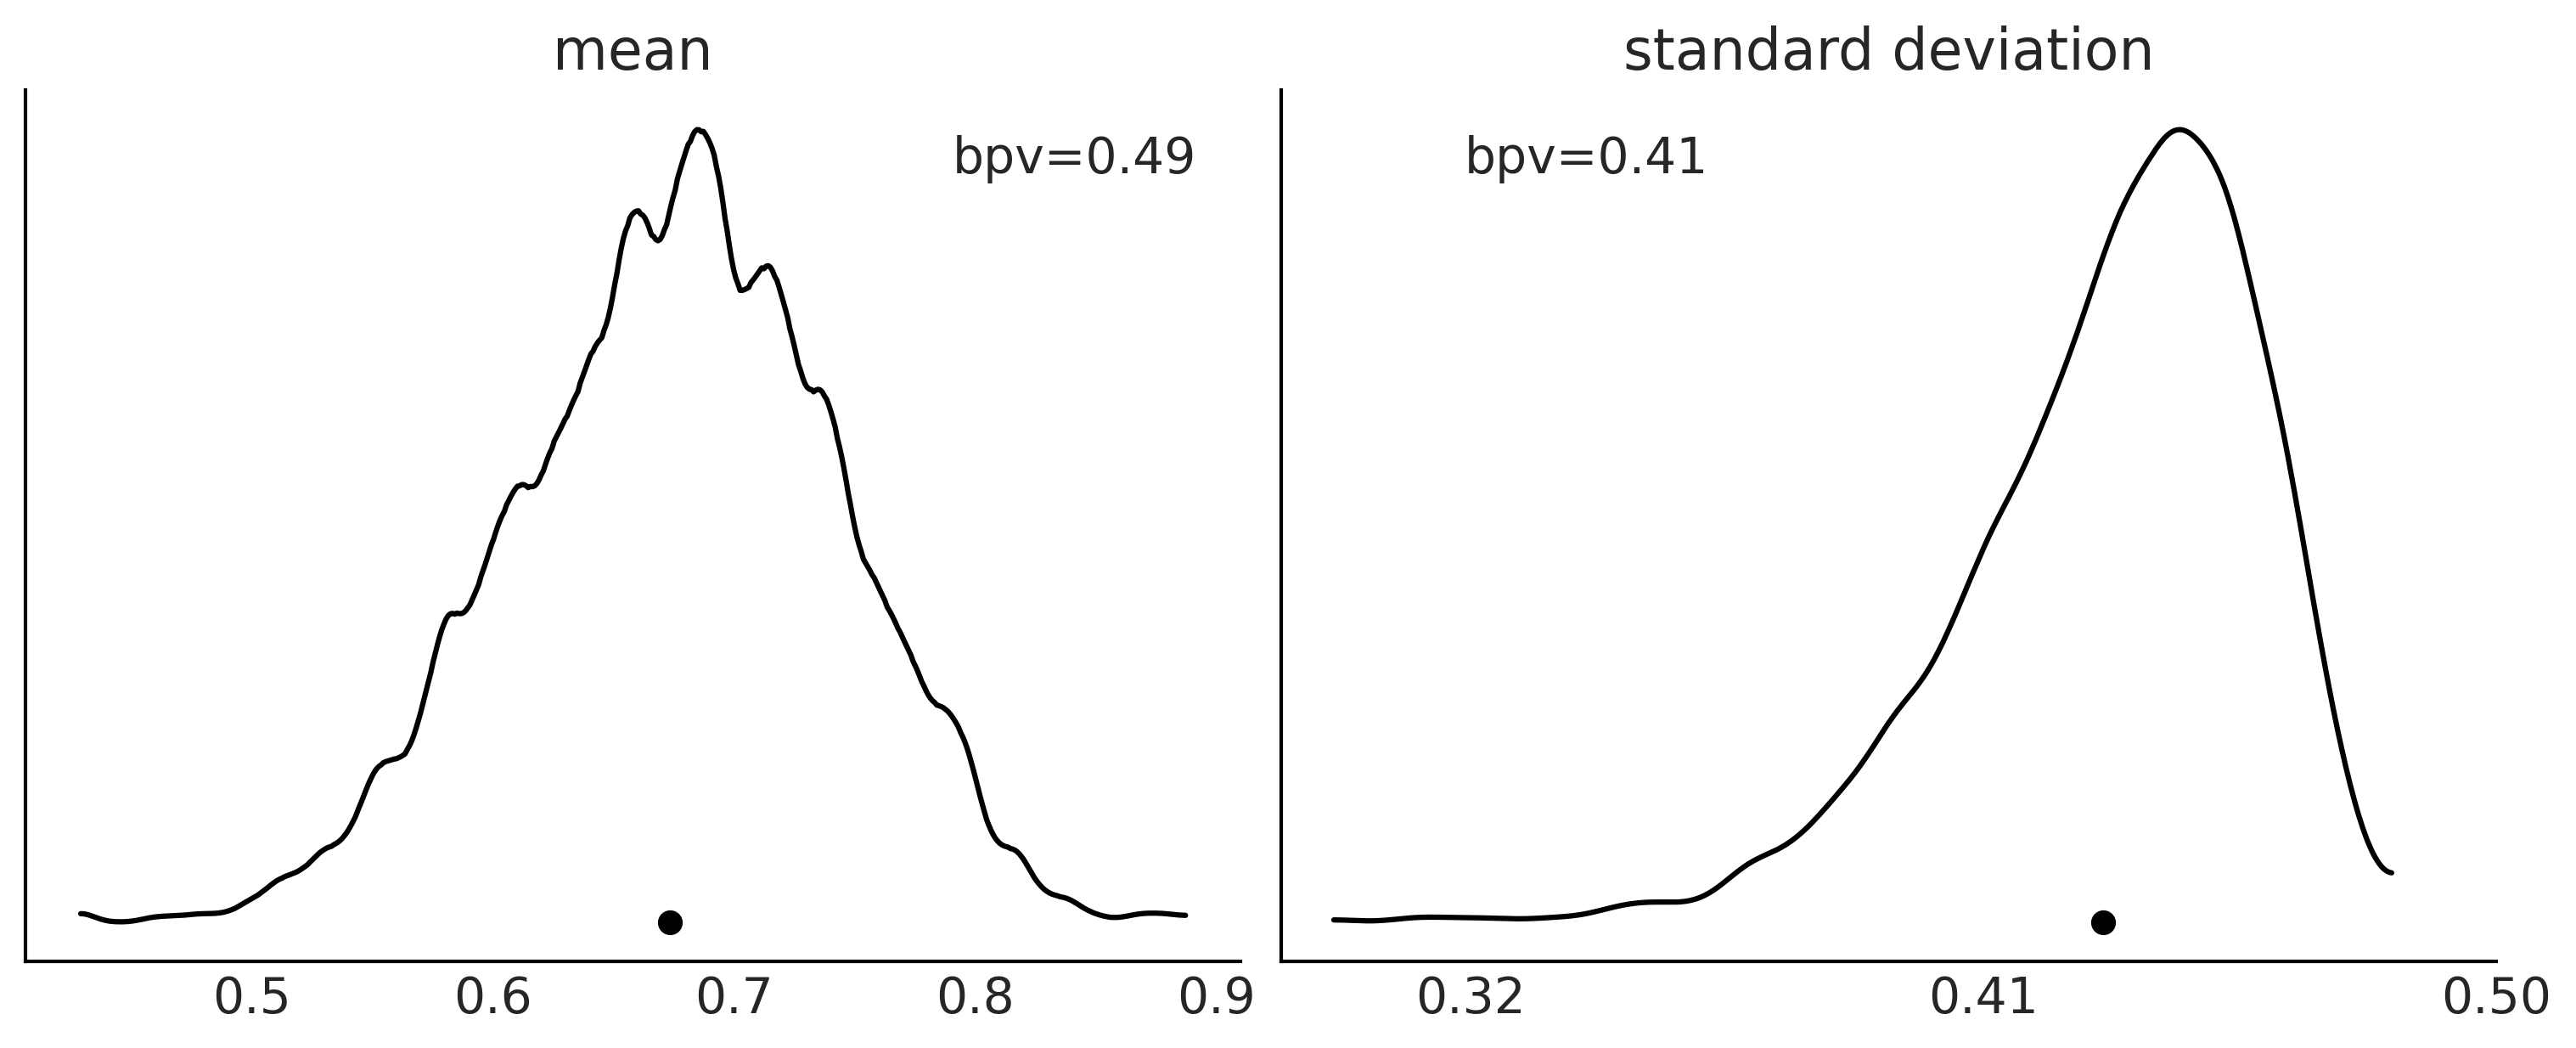

In [10]:
_, ax = plt.subplots(1, 2, figsize=(10, 4))
az.plot_bpv(idata_b, kind="t_stat", t_stat="mean", ax=ax[0])
ax[0].set_title("mean")
az.plot_bpv(idata_b, kind="t_stat", t_stat="std", ax=ax[1])
ax[1].set_title("standard deviation")
ax[1].set_xticks([0.32, 0.41, 0.5])
plt.savefig("img/chp02/posterior_predictive_check_tstat.png")

Before continue reading you should take a moment to carefully inspect
{numref}`fig:posterior_predictive_many_examples` and try to understand
why the plots look like they do. In this figure we have a series of
simple examples to help us gain intuition about how to interpret
posterior predictive checks plots[^7]. In all these examples the
observed data (in blue) follows a Gaussian distribution.

1.  On the first row, the model predicts observations that are
    systematically shifted to higher values with respect to the observed
    data.

2.  On the second row, the model is making predictions that are more
    spread than the observed data.

3.  On the third row we have the opposite scenario, the model is not
    generating enough predictions at the tails.

4.  On the last row shows a model making predictions following a mixture
    of Gaussians.

We are now going to pay special attention to the third column from
{numref}`fig:posterior_predictive_many_examples`. Plots in this column
are very useful but at the same time they can be confusing at first.
From top to bottom, you can read them as:

1.  The model is missing observations on the left tail (and making more
    on the right).

2.  The model is making less predictions at the middle (and more at the
    tails).

3.  The model is making less predictions for both tails.

4.  The model is making more or less well-calibrated predictions, but I
    am a skeptical person so I should run another posterior predictive
    check to confirm.

If this way of reading the plots still sounds confusing to you, we could
try from a different perspective that is totally equivalent, but it may
be more intuitive, as long as you remember that you can change the
model, not the observations [^8]. From top to bottom, you can read them
as:

1.  There are more observations on the left

2.  There are more observations on the middle

3.  There are more observations at the tails.

4.  Observations seem well distributed (at least within the expected
    boundaries), but you should not trust me. I am just a platonic model
    in a platonic world.

We hope {numref}`fig:posterior_predictive_many_examples` and the
accompanying discussion provide you with enough intuition to better
perform model checking in real scenarios.

```{figure} figures/posterior_predictive_many_examples.png
:name: fig:posterior_predictive_many_examples
:width: 8.00in
Posterior predictive checks for a set of simple hypothetical models. On
the first column, the blue solid line represents the observed data and
the light-gray ones predictions from an hypothetical model. On the
second column, the solid line is the KDE of the proportion of predicted
values that are less or equal than the observed data. The dashed lines
represent the expected distribution for a dataset of the same size as
the observed data. On the third panel, the KDE is for the proportion of
predicted values that are less or equal than the observed computed per
each observation. The white lines represent the expected Uniform
distribution and the gray band the expected deviations from uniformity
for a dataset of the same size as the one used. This figure was made
using the ArviZ's functions `az.plot_ppc(.)`,
`az.plot_bpv(., kind="p_values")` and `az.plot_bpv(., kind="u_values")`.
```

Posterior predictive checks, either using plots or numerical summaries,
or even a combination of both, is a very flexible idea. This concept is
general enough to let the practitioner use their imagination to come up
with different ways to explore, evaluate, and better understand model
through their predictions and how well a model (or models) work for a
particular problem.

[^7]: Posterior predictive checks are a very general idea. These figures
    do not try to show the only available choices, just some of the
    options offered by ArviZ.

[^8]: Unless you realize you need to collect data again, but that is
    another story.

/home/hwting/anaconda3/envs/rapids-24.12/lib/python3.11/site-packages/arviz/plots/ppcplot.py:242: FutureWarning: color has been deprecated in favor of colors
  warnings.warn("color has been deprecated in favor of colors", FutureWarning)


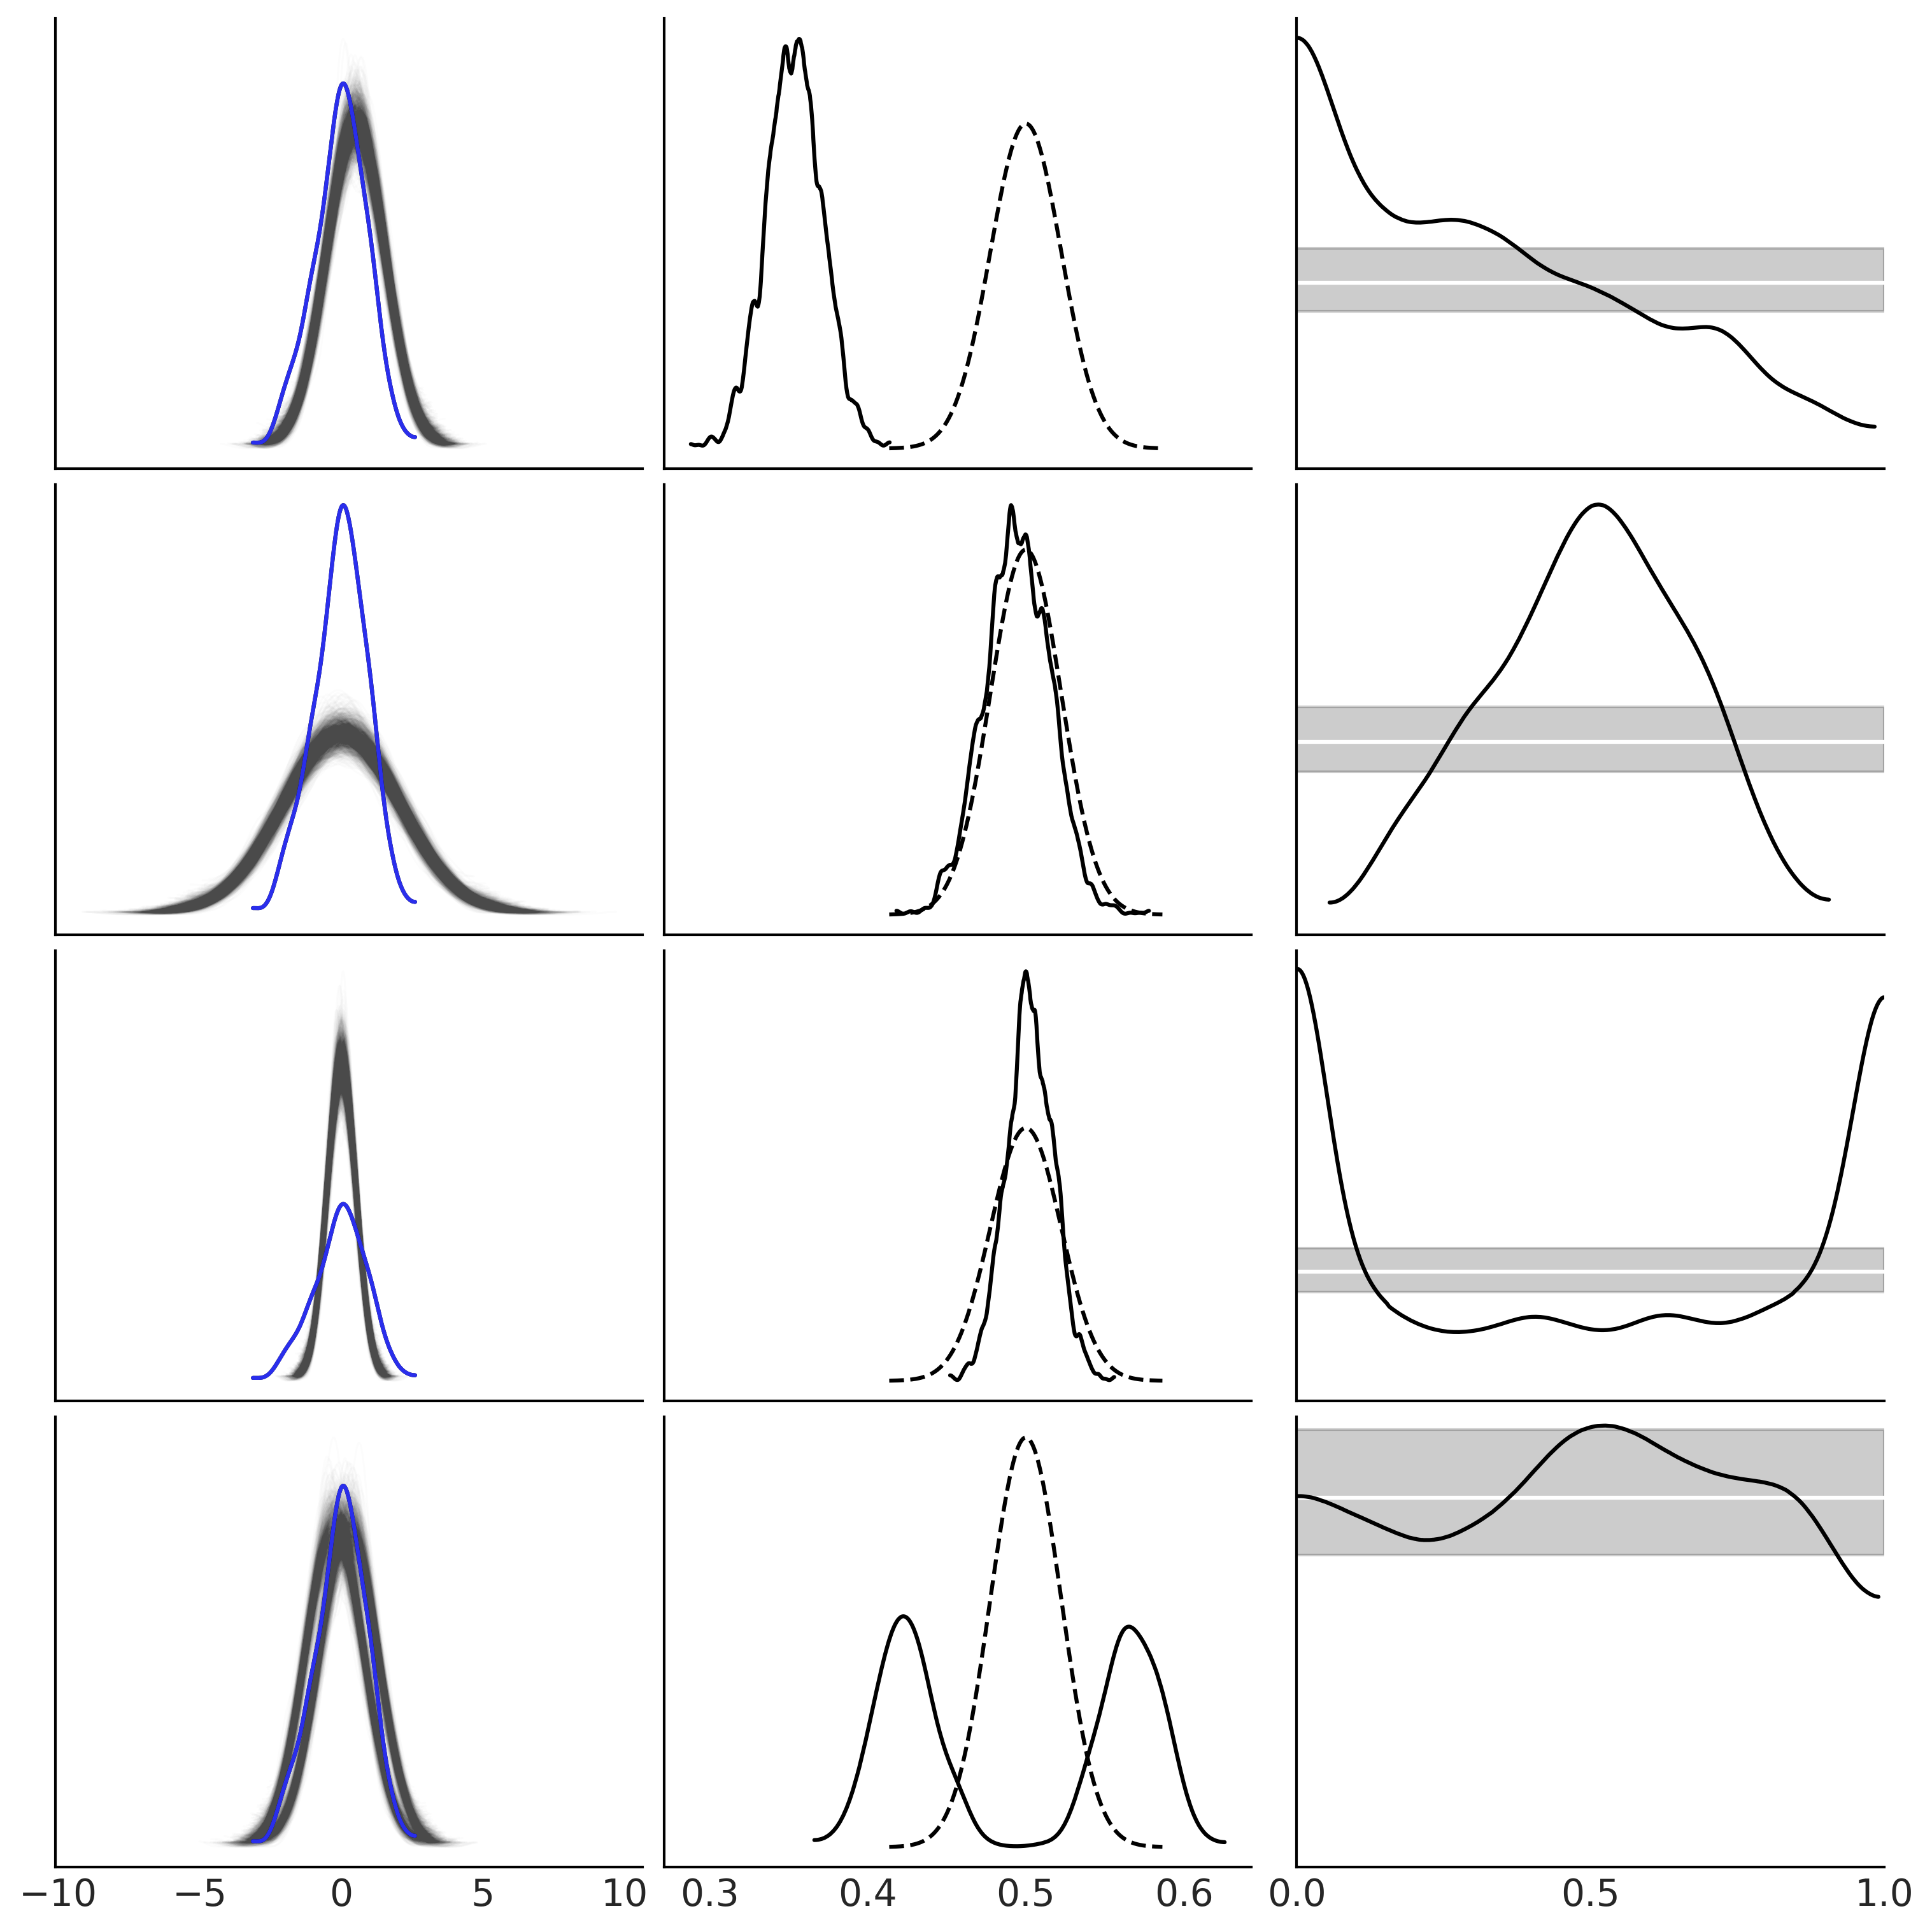

In [11]:
n_obs = 500
samples = 2000
y_obs = np.random.normal(0, 1, size=n_obs)

idata1 = az.from_dict(posterior_predictive={"y":np.random.normal(0.5, 1, size=(1, samples, n_obs))},
                      observed_data={"y":y_obs})

idata2 = az.from_dict(posterior_predictive={"y":np.random.normal(0, 2, size=(1, samples, n_obs))},
                      observed_data={"y":y_obs})

idata3 = az.from_dict(posterior_predictive={"y":np.random.normal(0, 0.5, size=(1, samples,n_obs))},
                      observed_data={"y":y_obs})

idata4 = az.from_dict(posterior_predictive={"y":np.concatenate(
                                                [np.random.normal(-0.25, 1, size=(1, samples//2, n_obs)),
                                                 np.random.normal(0.25, 1, size=(1, samples//2, n_obs))]
                                                                )},
                      observed_data={"y":y_obs})

idatas = [idata1,
          idata2,
          idata3,
          idata4,
]

_, axes = plt.subplots(len(idatas), 3, figsize=(10, 10), sharex="col")

for idata, ax in zip(idatas, axes):
    az.plot_ppc(idata, ax=ax[0], color="C1", alpha=0.01, mean=False, legend=False)
    az.plot_kde(idata.observed_data["y"].values, ax=ax[0], plot_kwargs={"color":"C4", "zorder":3})
    ax[0].set_xlabel("")
    az.plot_bpv(idata, kind="p_value", ax=ax[1])
    az.plot_bpv(idata, kind="u_value", ax=ax[2])
    ax[2].set_yticks([])
    ax[2].set_xticks([0., 0.5, 1.])
    for ax_ in ax:
        ax_.set_title("")

plt.savefig("img/chp02/posterior_predictive_many_examples.png")

(diagnosing_inference)=

## 2.4 Diagnosing Numerical Inference

Using numerical methods to approximate the posterior distribution allows
us to solve Bayesian models that could be tedious to solve with pen and
paper or that could be mathematically intractable. Unfortunately, they
do not always work as expected. For that reason we must always evaluate
if the results they offer are of any use. We can do that using a
collection of numerical and visual diagnostic tools. In this section we
will discuss the most common and useful diagnostics tools for Markov
chain Monte Carlo methods.

To help us understand these diagnostic tools, we are going to create
three *synthetic posteriors*. The first one is a sample from a
$\text{Beta}(2, 5)$. We generate it using SciPy, and we call it
`good_chains`. This is an example of a "good\" sample because we are
generating independent and identically distributed (iid) draws and
ideally this is what we want in order to approximate the posterior. The
second one is called `bad_chains0` and represents a poor sample from the
posterior. We generate it by sorting `good_chains` and then adding a
small Gaussian error. `bad_chains0` is a poor sample for two reasons:

-   The values are not independent. On the contrary they are highly
    autocorrelated, meaning that given any number at any position in the
    sequence we can compute the values coming before and after with high
    precision.

-   The values are not identically distributed, as we are reshaping a
    previously flattened and sorted array into a 2D array, representing
    two chains.

The third *synthetic posterior* called `bad_chains1` is generated from
`good_chains`, and we are turning it into a representation of a poor
sample from the posterior, by randomly introducing portions where
consecutive samples are highly correlated to each other. `bad_chains1`
represents a very common scenario, a sampler can resolve a region of the
parameter space very well, but one or more regions are difficult to
sample.

```python
good_chains = stats.beta.rvs(2, 5,size=(2, 2000))
bad_chains0 = np.random.normal(np.sort(good_chains, axis=None), 0.05,
                               size=4000).reshape(2, -1)

bad_chains1 = good_chains.copy()
for i in np.random.randint(1900, size=4):
    bad_chains1[i%2:,i:i+100] = np.random.beta(i, 950, size=100)

chains = {"good_chains":good_chains,
          "bad_chains0":bad_chains0,
          "bad_chains1":bad_chains1}
```



In [12]:
np.random.seed(5201)

In [13]:
good_chains = stats.beta.rvs(2, 5,size=(2, 2000))
bad_chains0 = np.random.normal(np.sort(good_chains, axis=None), 0.05,
                               size=4000).reshape(2, -1)

bad_chains1 = good_chains.copy()
for i in np.random.randint(1900, size=4):
    bad_chains1[i%2:,i:i+100] = np.random.beta(i, 950, size=100)

chains = {"good_chains":good_chains,
          "bad_chains0":bad_chains0,
          "bad_chains1":bad_chains1}

Notice that the 3 synthetic posteriors are samples from a scalar (single
parameter) posterior distribution. This is enough for our current
discussion as all the diagnostics we will see are computed per parameter
in the model.

(ess)=

### 2.4.1 Effective Sample Size

When using MCMC sampling methods, it is reasonable to wonder if a
particular sample is large enough to confidently compute the quantities
of interest, like a mean or an HDI. This is something we can not
directly answer just by looking at the number of samples, the reason is
that samples from MCMC methods will have some degree of
**autocorrelation**, thus the actual *amount of information* contained
in that sample will be less than the one we would get from an iid sample
of the same size. We say a series of values are autocorrelated when we
can observe a similarity between them as a function of the time lag
between them. For example, if today the sunset was at 6:03 am, you know
tomorrow the sunset will be about the same time. In fact the closer you
are to the equator the longer you will be able to predict the time for
future sunsets given the value of today. That is, the autocorrelation is
larger at the equator than closer to the poles [^9].

We can think of the effective sample size (ESS) as an estimator that
takes autocorrelation into account and provides the number of draws we
would have if our sample was actually iid. This interpretation is
appealing, but we have to be careful about not over-interpreting it as
we will see next.

Using ArviZ we can compute the effective sample size for the mean with
`az.ess()`

```python
az.ess(chains)
```

```none
<xarray.Dataset>
Dimensions:      ()
Data variables:
    good_chains  float64 4.389e+03
    bad_chains0  float64 2.436
    bad_chains1  float64 111.1
```

[^9]: Try <https://www.timeanddate.com/sun/ecuador/quito>

In [14]:
az.ess(chains)

<xarray.Dataset> Size: 24B
Dimensions:      ()
Data variables:
    bad_chains0  float64 8B 2.436
    bad_chains1  float64 8B 111.1
    good_chains  float64 8B 4.389e+03

We can see that even when the count of actual samples in our synthetic
posteriors is 4000, `bad_chains0` has efficiency equivalent to an iid
sample of size $\approx 2$. This is certainly a low number indicating a
problem with the sampler. Given the method used by ArviZ to compute the
ESS and how we created `bad_chains0`, this result is totally expected.
`bad_chains0` is a bimodal distribution with each chain stuck in each
mode. For such cases the ESS will be approximately equal to the number
of modes the MCMC chains explored. For `bad_chains1` we also get a low
number $\approx 111$ and only ESS for `good_chains` is close to the
actual number of samples.

::: {admonition} On the effectiveness of effective samples

If you rerun the generation of these synthetic posteriors, using a different random seed,
you will see that the effective sample size you get will be different each time. This
is expected as the samples will not be exactly the same, they are after
all samples. For `good_chains`, on average, the value of effective
sample size will be lower than the number of samples. But notice that
ESS could be in fact larger! When using the NUTS sampler (see Section
{ref}`inference_methods`) values of ESS larger than
the total number of samples can happen for parameters which posterior
distributions are close to Gaussian and which are almost independent of
other parameters in the model.
:::

Convergence of Markov chains is not uniform across the parameter space
{cite:p}`vehtari_rank_2019`, intuitively it is easier to get a good
approximation from the bulk of a distribution than from the tails,
simply because the tails are dominated by rare events. The default value
returned by `az.ess()` is `bulk-ESS` which mainly assesses how well the
*center* of the distribution was resolved. If you also want to report
posterior intervals or you are interested in rare events, you should
check the value of `tail-ESS`, which corresponds to the minimum ESS at
the percentiles 5 and 95. If you are interested in specific quantiles,
you can ask ArviZ for those specific values using
`az.ess(., method='quantile')`.

As the ESS values vary across the parameter space, we may find it useful
to visualize this variation in a single plot. We have at least two ways
to do it. Plotting the ESS for specifics quantiles
`az.plot_ess(., kind="quantiles")` or for small intervals defined between
two quantiles `az.plot_ess(., kind="local")` as shown in
{numref}`fig:plot_ess`.

```python
_, axes = plt.subplots(2, 3, sharey=True, sharex=True)
az.plot_ess(chains, kind="local", ax=axes[0]);
az.plot_ess(chains, kind="quantile", ax=axes[1]);
```

```{figure} figures/plot_ess.png
:name: fig:plot_ess
:width: 8.00in
Top: Local ESS of small interval probability estimates. Bottom: Quantile
ESS estimates. The dashed lines represent the minimum suggested value of
400 at which we would consider the effective sample size to be
sufficient. Ideally, we want the local and quantile ESS to be high
across all regions of the parameter space.
```

As a general rule of thumb we recommend a value of ESS greater than 400,
otherwise, the estimation of the ESS itself and the estimation of other
quantities, like $\hat R$ that we will see next, will be basically
unreliable {cite:p}`vehtari_rank_2019`. Finally, we said that the ESS provides
the number of draws we would have if our sample was actually iid.
Nevertheless, we have to be careful with this interpretation as the
actual value of ESS will not be the same for different regions of the
parameter space. Taking that detail into account, the intuition still
seems useful.

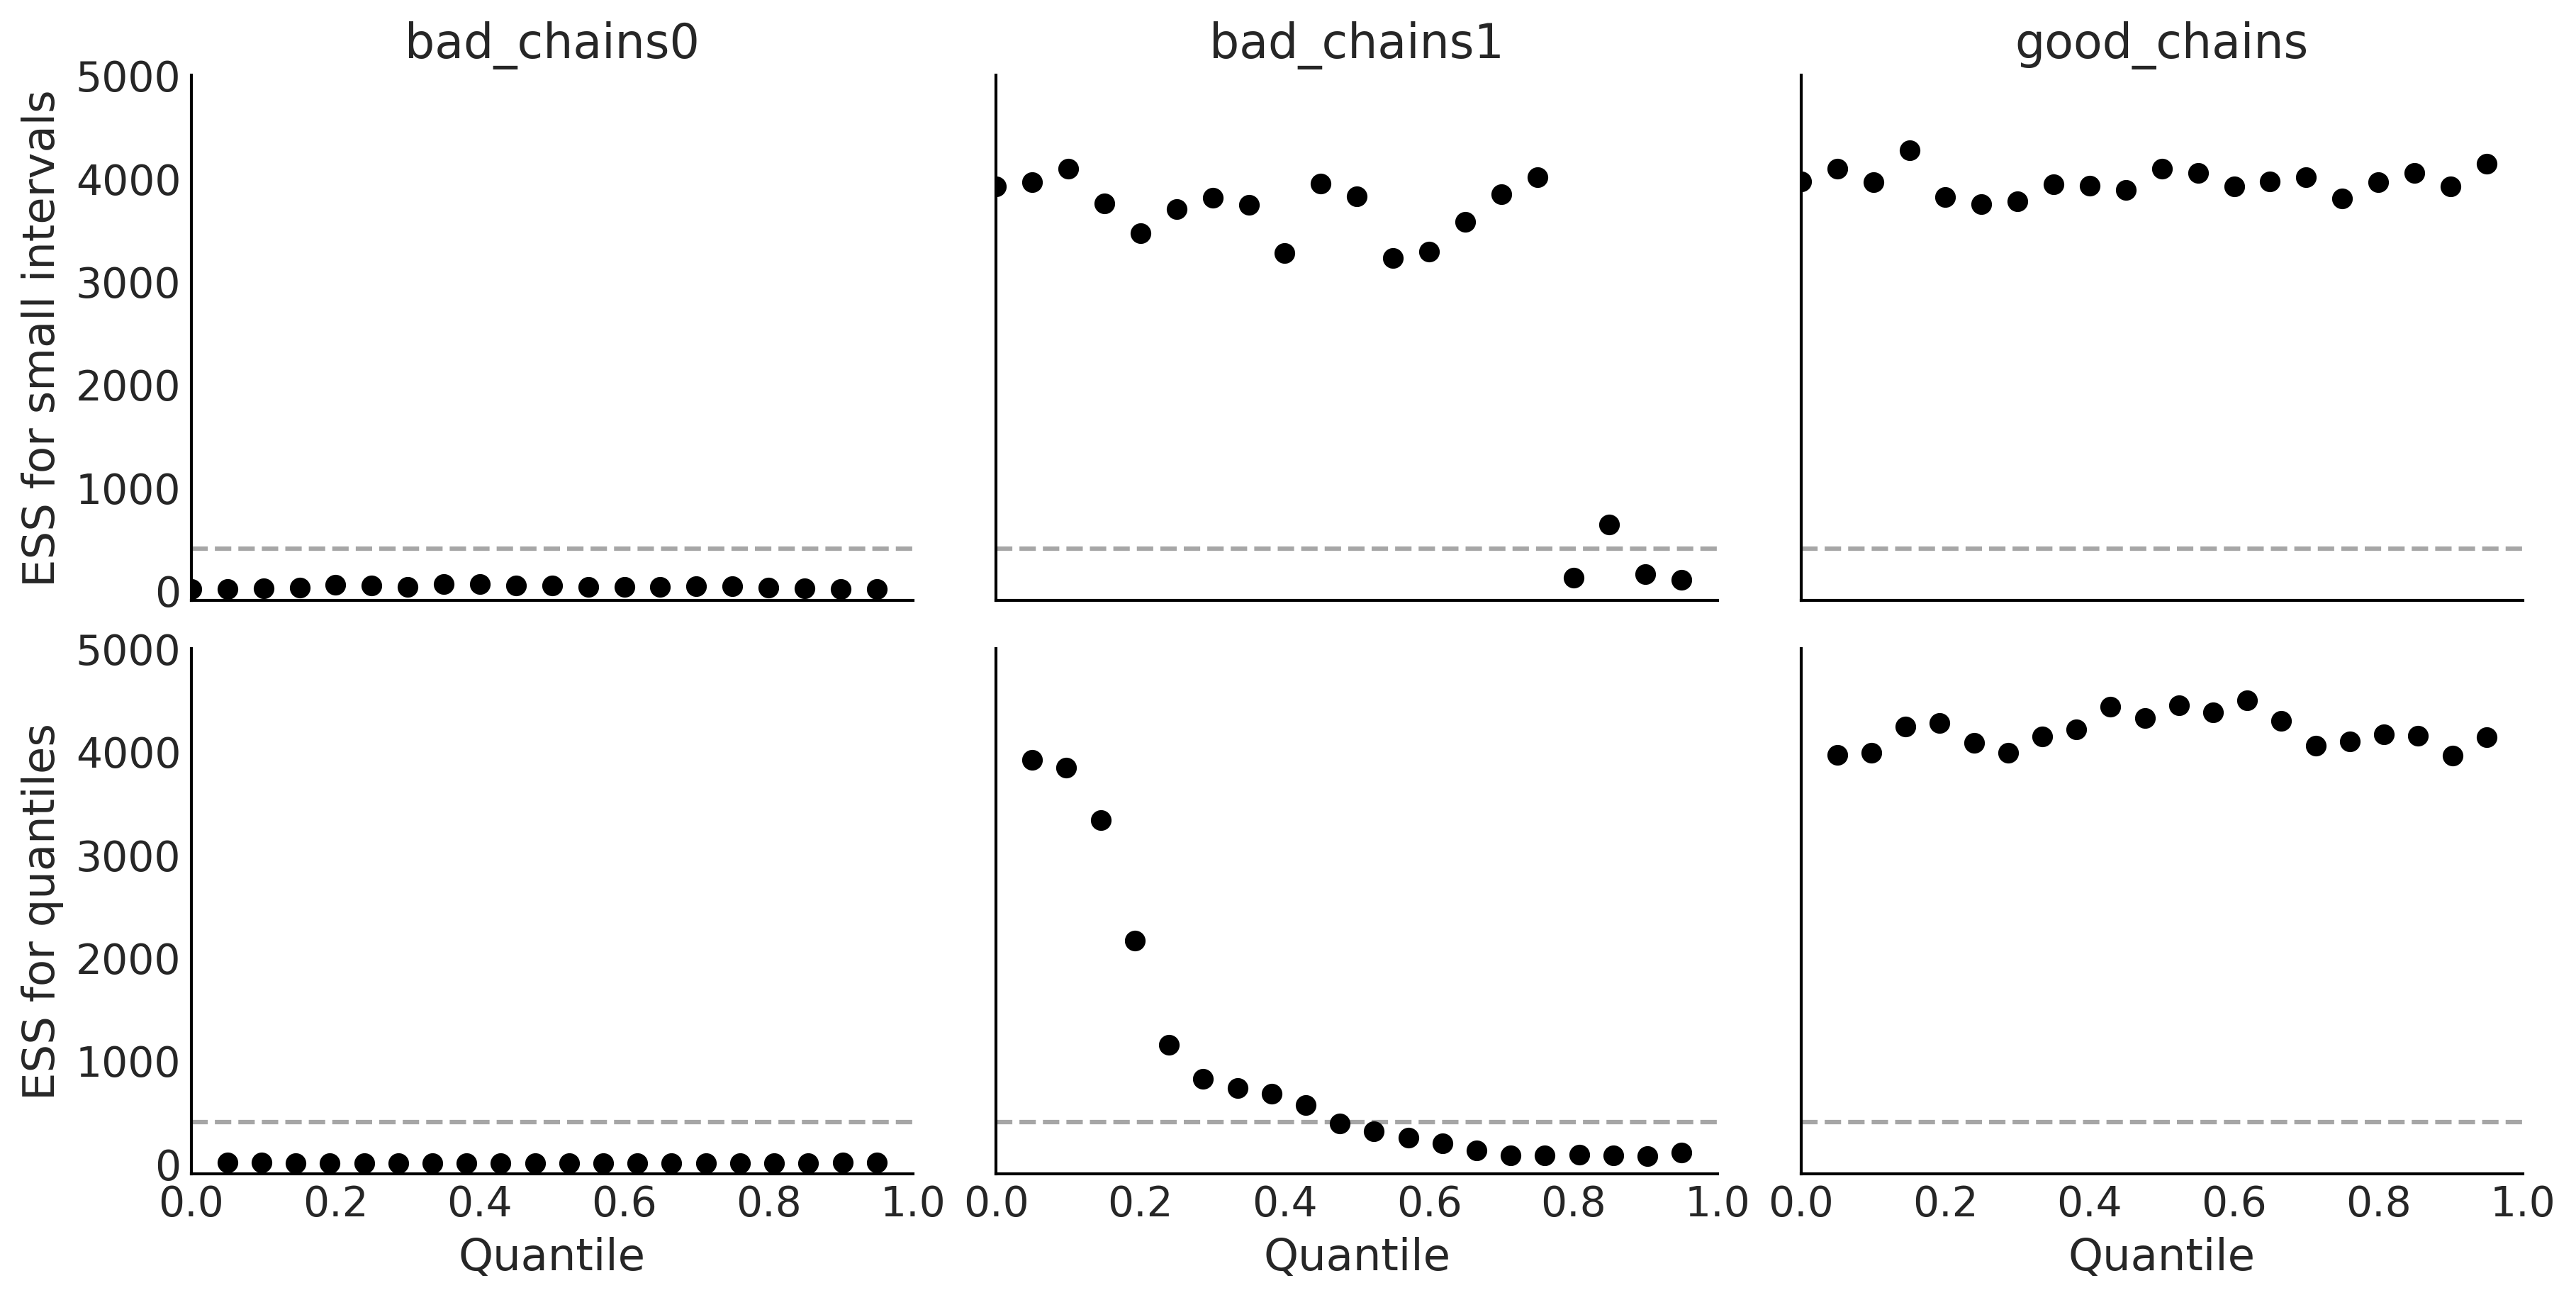

In [15]:
_, axes = plt.subplots(2, 3, figsize=(12, 6), sharey=True, sharex=True)
az.plot_ess(chains, kind="local", ax=axes[0])
az.plot_ess(chains, kind="quantile", ax=axes[1])

for ax_ in axes[0]:
    ax_.set_xlabel("")
for ax_ in axes[1]:
    ax_.set_title("")

for ax_ in axes[:,1:].ravel():
    ax_.set_ylabel("")
plt.ylim(-100, 5000)
plt.savefig("img/chp02/plot_ess.png")

(potential-scale-reduction-factor-hat-r)=

### 2.4.2 Potential Scale Reduction Factor $\hat R$

Under very general conditions Markov chain Monte Carlo methods have
theoretical guarantees that they will get the right answer irrespective
of the starting point. Unfortunately, the fine print says that the
guarantees are valid only for infinite samples. Thus in practice we need
ways to estimate convergence for finite samples. One pervasive idea is
to run more than one chain, starting from very different points and then
check the resulting chains to see if they *look similar* to each other.
This intuitive notion can be formalized into a numerical diagnostic
known as $\hat R$. There are many versions of this estimator, as it has
been refined over the years {cite:p}`vehtari_rank_2019`. Originally the
$\hat R$ diagnostic was interpreted as the overestimation of variance
due to MCMC finite sampling. Meaning that if you continue sampling
infinitely you should get a reduction of the variance of your estimation
by a $\hat R$ factor. And hence the name "potential scale reduction
factor\", with the target value of 1 meaning that increasing the number
of samples will not reduce the variance of the estimation further.
Nevertheless, in practice it is better to just think of it as a
diagnostic tool without trying to over-interpret it.

The $\hat R$ for the parameter $\theta$ is computed as the standard
deviation of all the samples of $\theta$, that is including all chains
together, divided by the root mean square of the separated within-chain
standard deviations. The actual computation is a little bit more
involved but the overall idea remains true {cite:p}`vehtari_rank_2019`. Ideally
we should get a value of 1, as the variance between chains should be the
same as the variance within-chain. From a practical point of view values
of $\hat R \lessapprox 1.01$ are considered safe.

Using ArviZ we can compute the $\hat R$ diagnostics with the `az.rhat()`
function

```python
az.rhat(chains)
```

```none
<xarray.Dataset>
Dimensions:      ()
Data variables:
    good_chains  float64 1.000
    bad_chains0  float64 2.408
    bad_chains1  float64 1.033
```

From this result we can see that $\hat R$ correctly identifies
`good_chains` as a good sample and `bad_chains0` and `bad_chains1` as
samples with different degree of problems. While `bad_chains0` is a
total disaster, `bad_chains1` seems to be closer to reaching the
*ok-chain status*, but still off.

In [16]:
az.rhat(chains)

<xarray.Dataset> Size: 24B
Dimensions:      ()
Data variables:
    bad_chains0  float64 8B 2.408
    bad_chains1  float64 8B 1.033
    good_chains  float64 8B 1.0

(Monte_Carlo_standard_error)=

### 2.4.3 Monte Carlo Standard Error

When using MCMC methods we introduce an additional layer of uncertainty
as we are approximating the posterior with a finite number of samples.
We can estimate the amount of error introduced using the Monte Carlo
standard error (MCSE), which is based on Markov chain central limit
theorem (see Section {ref}`markov_chains`). The MCSE takes into
account that the samples are not truly independent of each other and are
in fact computed from the ESS {cite:p}`vehtari_rank_2019`. While the values of
ESS and $\hat R$ are independent of the scale of the parameters,
interpreting whether MCSE is small enough requires domain expertise. If
we want to report the value of an estimated parameter to the second
decimal, we need to be sure the MCSE is below the second decimal
otherwise, we will be, wrongly, reporting a higher precision than we
really have. We should check the MCSE only once we are sure ESS is high
enough and $\hat R$ is low enough; otherwise, MCSE is of no use.

Using ArviZ we can compute the MCSE with the function `az.mcse()`


```python
az.mcse(chains)
```

```none
<xarray.Dataset>
Dimensions:      ()
Data variables:
    good_chains  float64 0.002381
    bad_chains0  float64 0.1077
    bad_chains1  float64 0.01781
```

In [17]:
az.mcse(chains)

<xarray.Dataset> Size: 24B
Dimensions:      ()
Data variables:
    bad_chains0  float64 8B 0.1077
    bad_chains1  float64 8B 0.01781
    good_chains  float64 8B 0.002381

As with the ESS the MCSE varies across the parameter space and then we
may also want to evaluate it for different regions, like specific
quantiles. Additionally, we may also want to visualize several values at
once as in {numref}`fig:plot_mcse`.

```python
az.plot_mcse(chains)
```

```{figure} figures/plot_mcse.png
:name: fig:plot_mcse
:width: 8.00in
Local MCSE for quantiles. Subplots y-axis share the same scale to ease
comparison between them. Ideally, we want the MCSE to be small across
all regions of the parameter space. Note how the MCSE values for
`good_chains` is relatively low across all values compared to MCSE of
both bad chains.
```

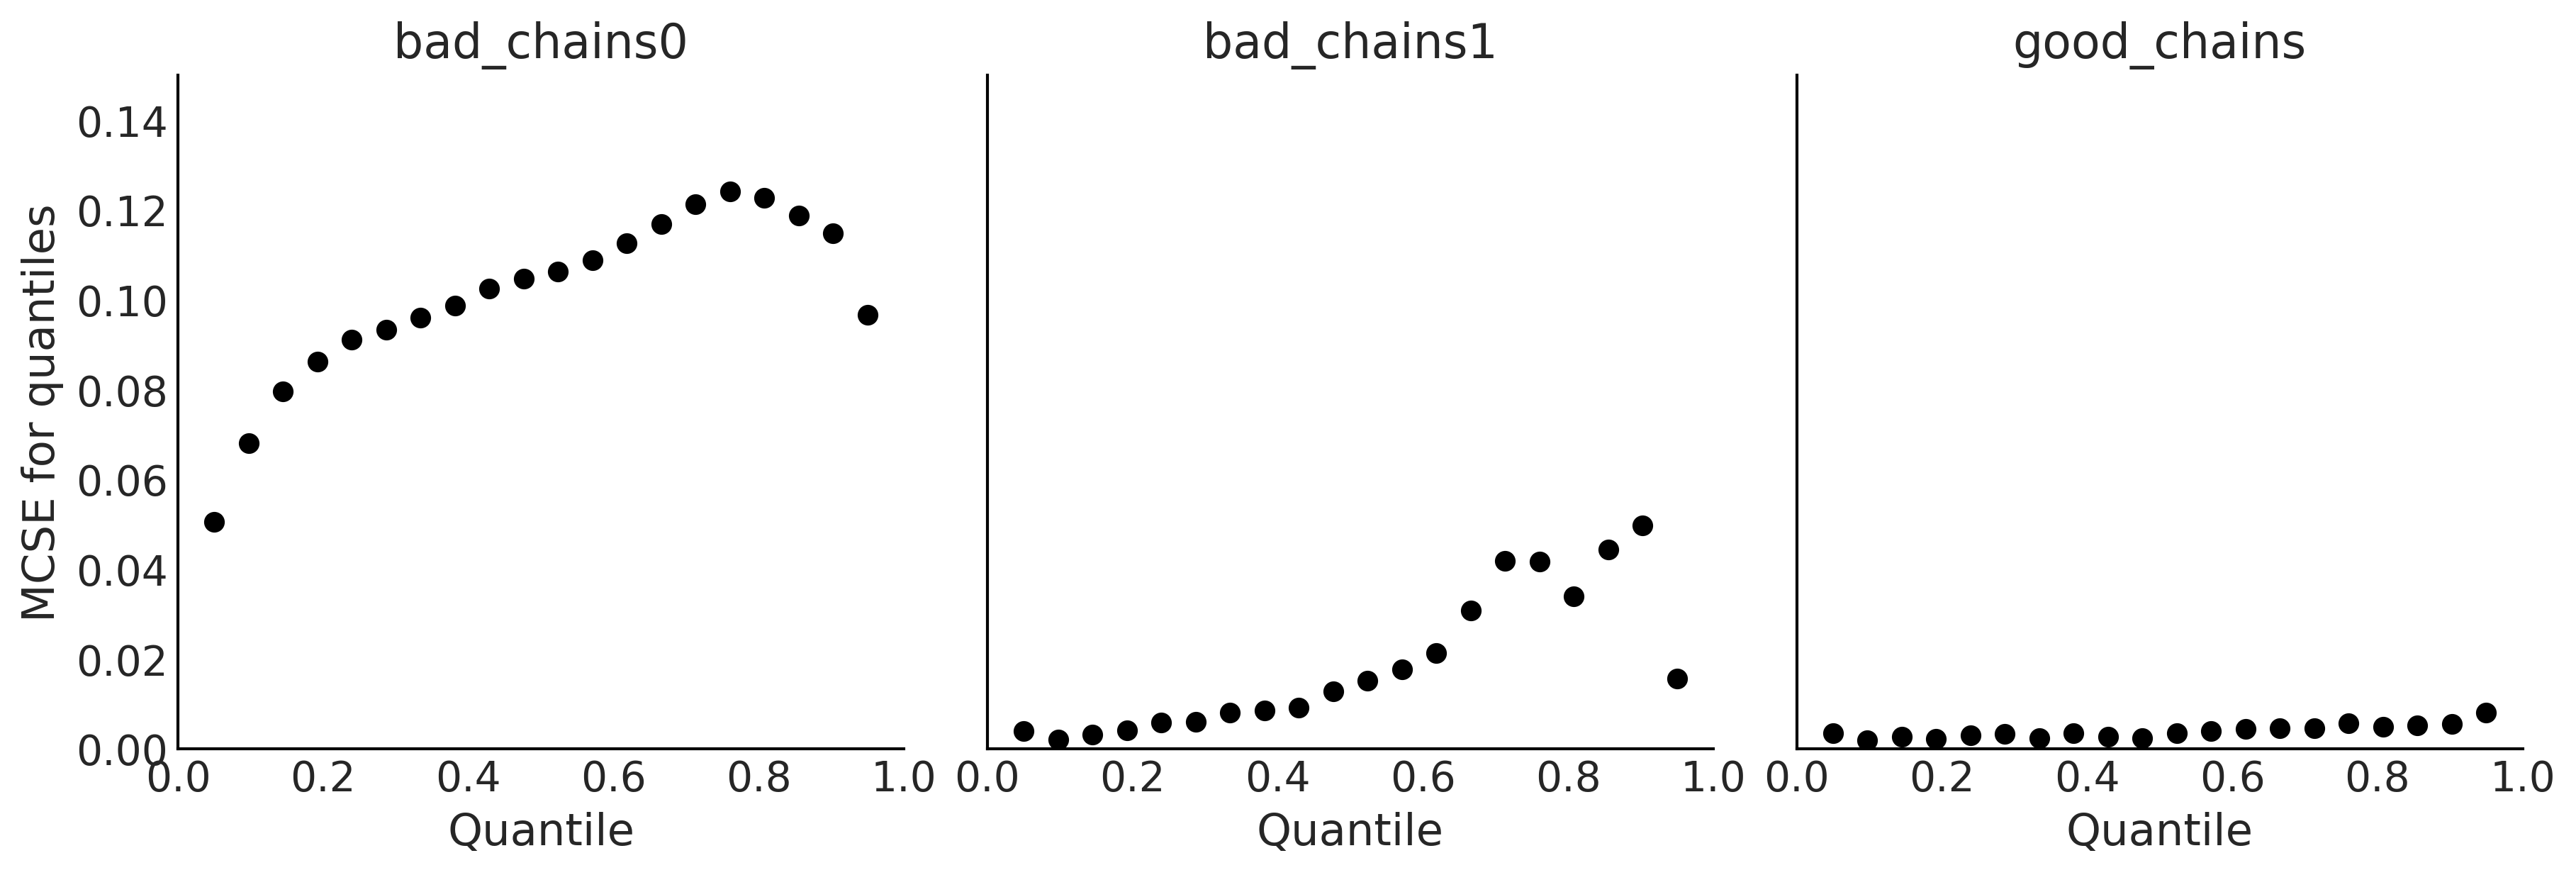

In [18]:
_, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
az.plot_mcse(chains, ax=axes)
for ax_ in axes[1:]:
    ax_.set_ylabel("")
    ax_.set_ylim(0, 0.15)

plt.savefig("img/chp02/plot_mcse.png")

Finally, the ESS, $\hat R$, and MCSE can all be computed with a single
call to the `az.summary(.)` function.

```python
az.summary(chains, kind="diagnostics")
```

```{list-table}
* -
  - **mcse_mean***
  - **mcse_sd**
  - **ess_bulk**
  - **ess_tail**
  - **r_hat**
* - good_chains
  - 0.002
  - 0.002
  - 4389.0
  - 3966.0
  - 1.00
* - bad_chains0
  - 0.108
  - 0.088
  - 2.0
  - 11.0
  - 2.41
* - bad_chains1
  - 0.018
  - 0.013
  - 111.0
  - 105.0
  - 1.03
```

In [19]:
az.summary(chains, kind="diagnostics")

mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
bad_chains0      0.108    0.088       2.0      11.0   2.41
bad_chains1      0.018    0.013     111.0     105.0   1.03
good_chains      0.002    0.002    4389.0    3966.0   1.00

The first column is the Monte Carlo standard error for the mean or
(expectation), the second one is the Monte Carlo standard error for the
standard deviation [^10]. Then we have the bulk and tail effective
sample size and finally the $\hat R$ diagnostic.

[^10]: Do not confuse with the standard deviation of the MCSE for the

(trace-plots)=

### 2.4.4 Trace Plots

Trace plots are probably the most popular plots in Bayesian literature.
They are often the first plot we make after inference, to visually check
*what we got*. A trace plot is made by drawing the sampled values at
each iteration step. From these plots we should be able to see if
different chains converge to the same distribution, we can get a *sense*
of the degree of autocorrelation, etc. In ArviZ by calling the function
`az.plot_trace(.)` we get a trace plot on the right plus a
representation of the distribution of the sample values, using a KDE for
continuous variables and a histogram for discrete ones on the left.

```python
az.plot_trace(chains)
```

```{figure} figures/trace_plots.png
:name: fig:trace_plots
:width: 8.00in
On the left column, we see one KDE per chain. On the right, column we
see the values of the sampled values per chain per step. Note the
differences in the KDE and trace plots between each of the example
chains, particularly the *fuzzy caterpillar* appearance in `good_chains`
versus the irregularities in the other two.
```

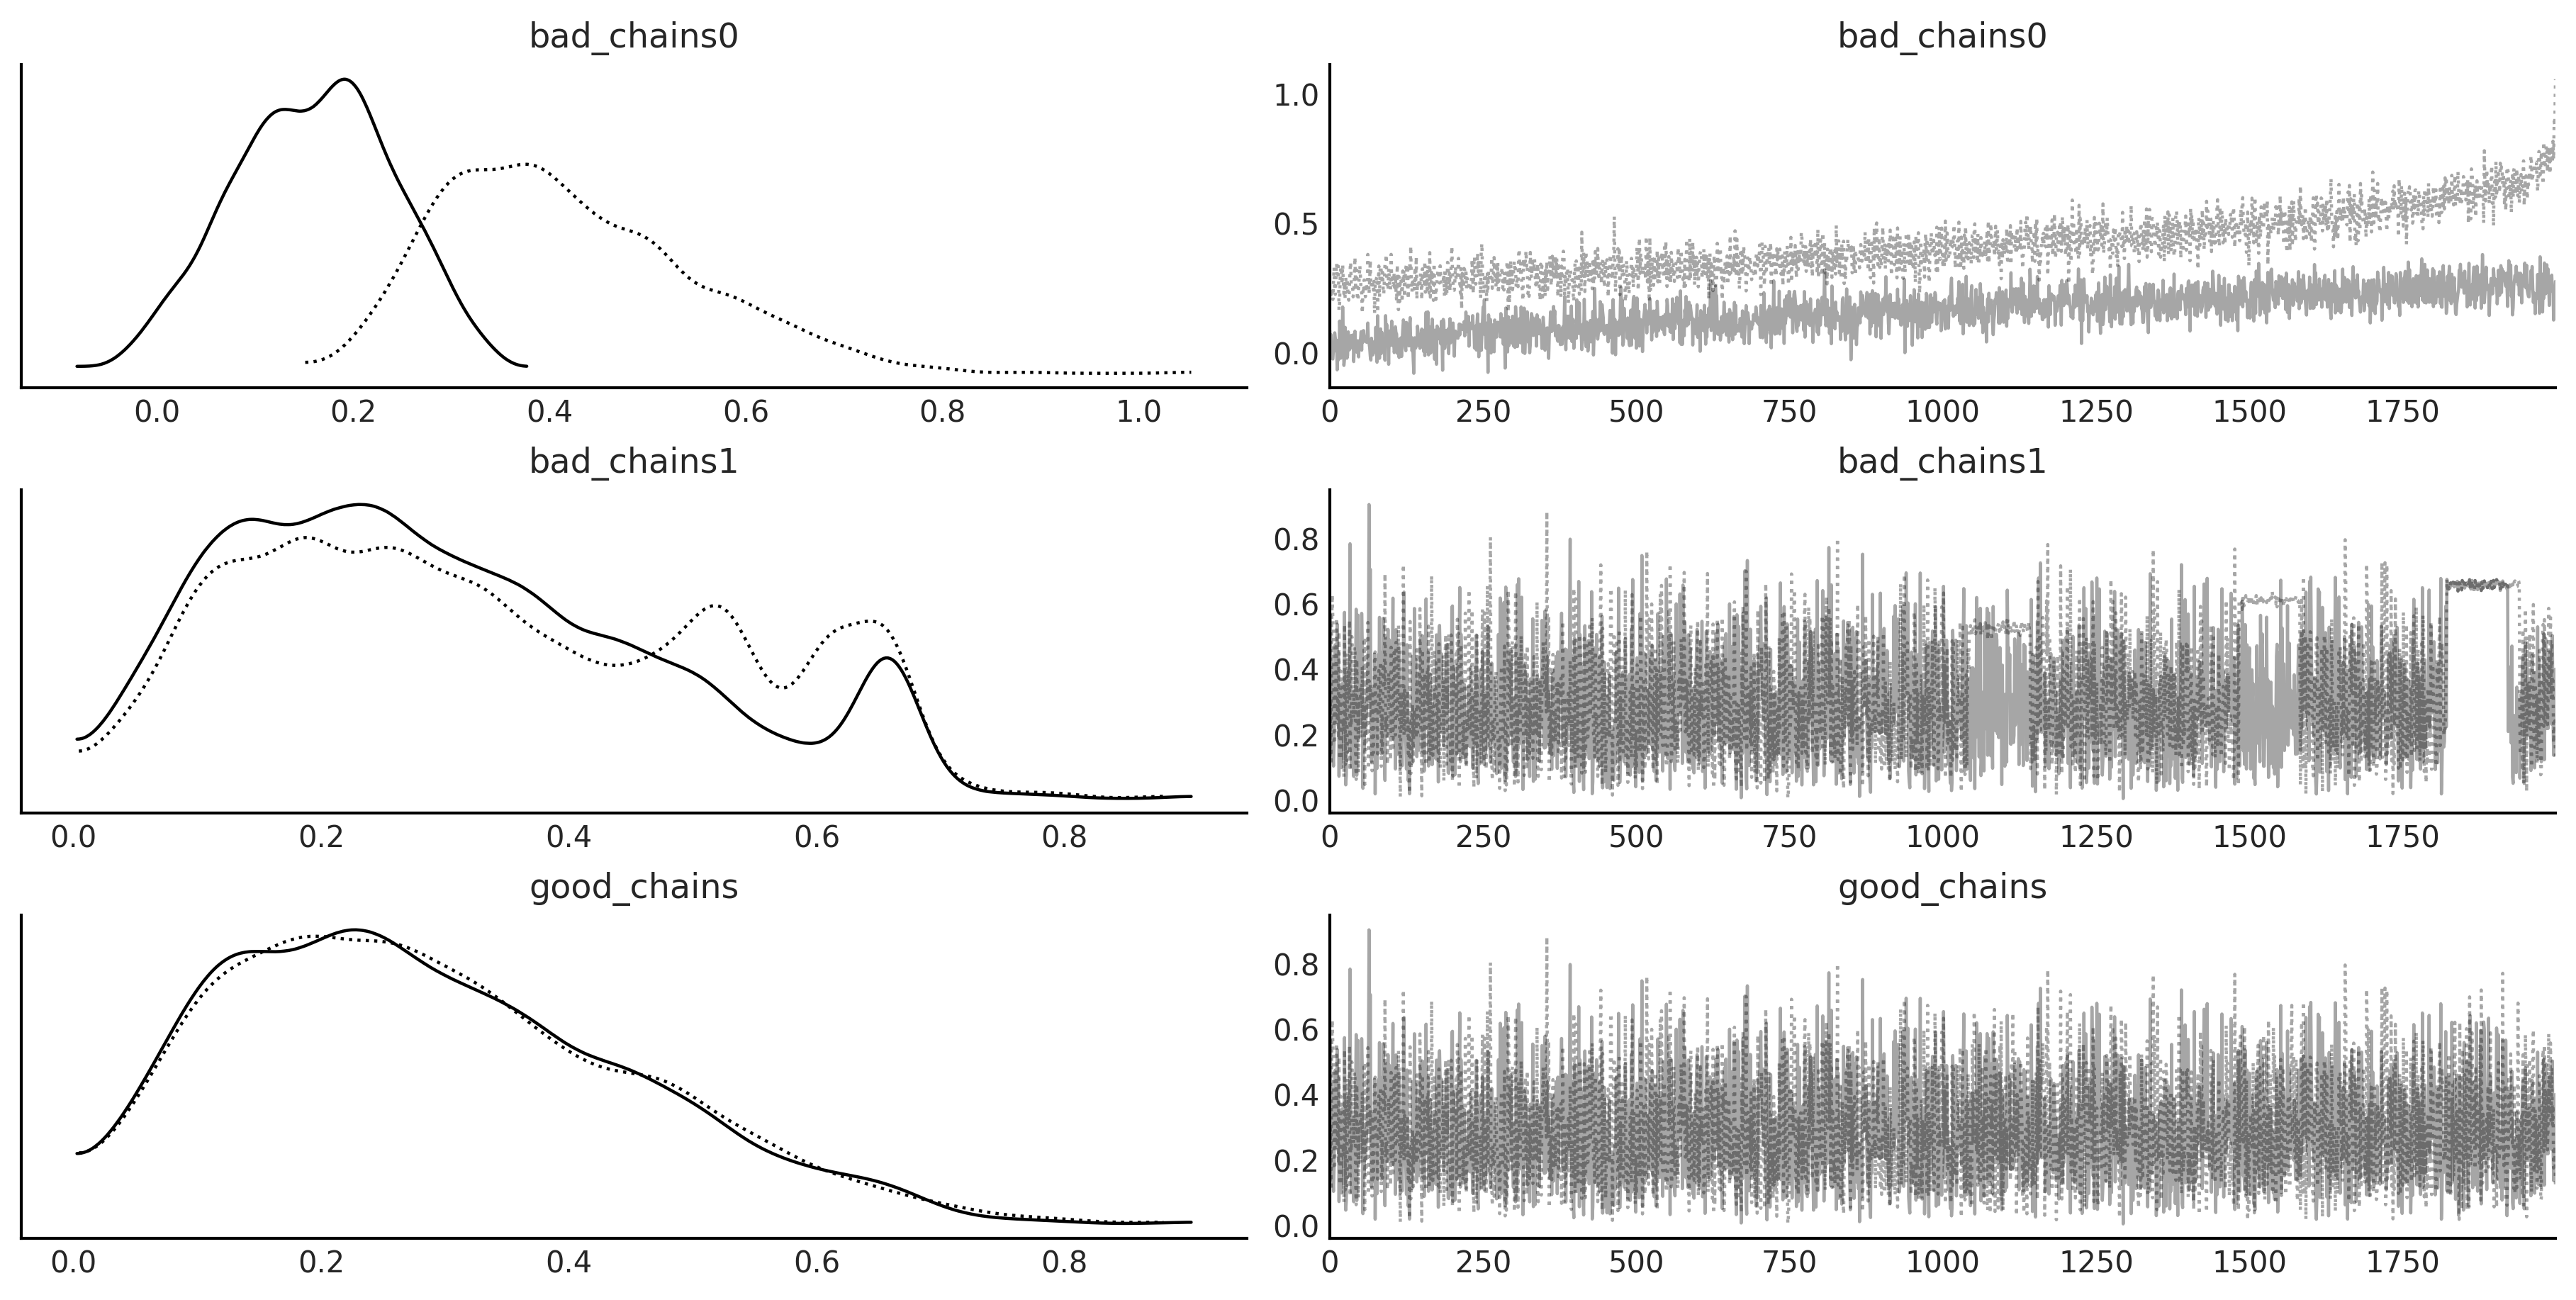

In [20]:
az.plot_trace(chains)
plt.savefig("img/chp02/trace_plots.png")

{numref}`fig:trace_plots` shows the trace plots for `chains`. From it,
we can see that the draws in `good_chains` belong to the same
distribution as there are only small (random) differences between both
chains. When we see the draws ordered by iteration (i.e. the trace
itself) we can see that chains look rather *noisy* with no apparent
trend or pattern, it is also difficult to distinguish one chain from the
other. This is in clear contrast to what we get for `bad_chains0`. For
this sample we clearly see two different distributions with only some
overlap. This is easy to see both from the KDE and from the trace. The
chains are exploring two different regions of the parameter space. The
situation for `bad_chains1` is a little bit more subtle. The KDE shows
distributions that seem to be similar to those from `good_chains` the
differences between the two chains are more clear. Do we have 2 or 3
peaks? The distributions do not seem to agree, maybe we just have one
mode and the extra peaks are artifacts! Peaks generally look suspicious
unless we have reasons to believe in multi-modal distributions arising,
for example, from sub-populations in our data. The trace also seems to
be somehow similar to the one from `good_chains`, but a more careful
inspection reveals the presence of long regions of monotonicity (the
lines parallel to the x-axis). This is a clear indication that the
sampler is getting stuck in some regions of the parameter space, maybe
because we have a multimodal posterior with barrier between modes of
very low probability or perhaps because we have some regions of the
parameter space with a curvature that is too different from the rest.

(autocorr_plot)=

### 2.4.5 Autocorrelation Plots

As we saw when we discussed the effective sample size, autocorrelation
decreases the actual amount of information contained in a sample and
thus something we want to keep at a minimum. We can directly inspect the
autocorrelation with `az.plot_autocorr`.

```python
az.plot_autocorr(chains, combined=True)
```

```{figure} figures/autocorrelation_plot.png
:name: fig:autocorrelation_plot
:width: 8.00in
Bar plot of the autocorrelation function over a 100 steps window. The
height of the bars for `good_chains` is close to zero (and mostly inside
the gray band) for the entire plot, which indicates very low
autocorrelation. The tall bars in `bad_chains0` and `bad_chains1`
indicate large values of autocorrelation, which is undesirable. The gray
band represents the 95% confidence interval.
```

What we see in {numref}`fig:autocorrelation_plot` is at least
qualitatively expected after seeing the results from `az.ess`.
`good_chains` shows essentially zero autocorrelation, `bad_chains0` is
highly correlated and `bad_chains1` is not that bad, but autocorrelation
is still noticeable and is long-range, i.e. it does not drop quickly.

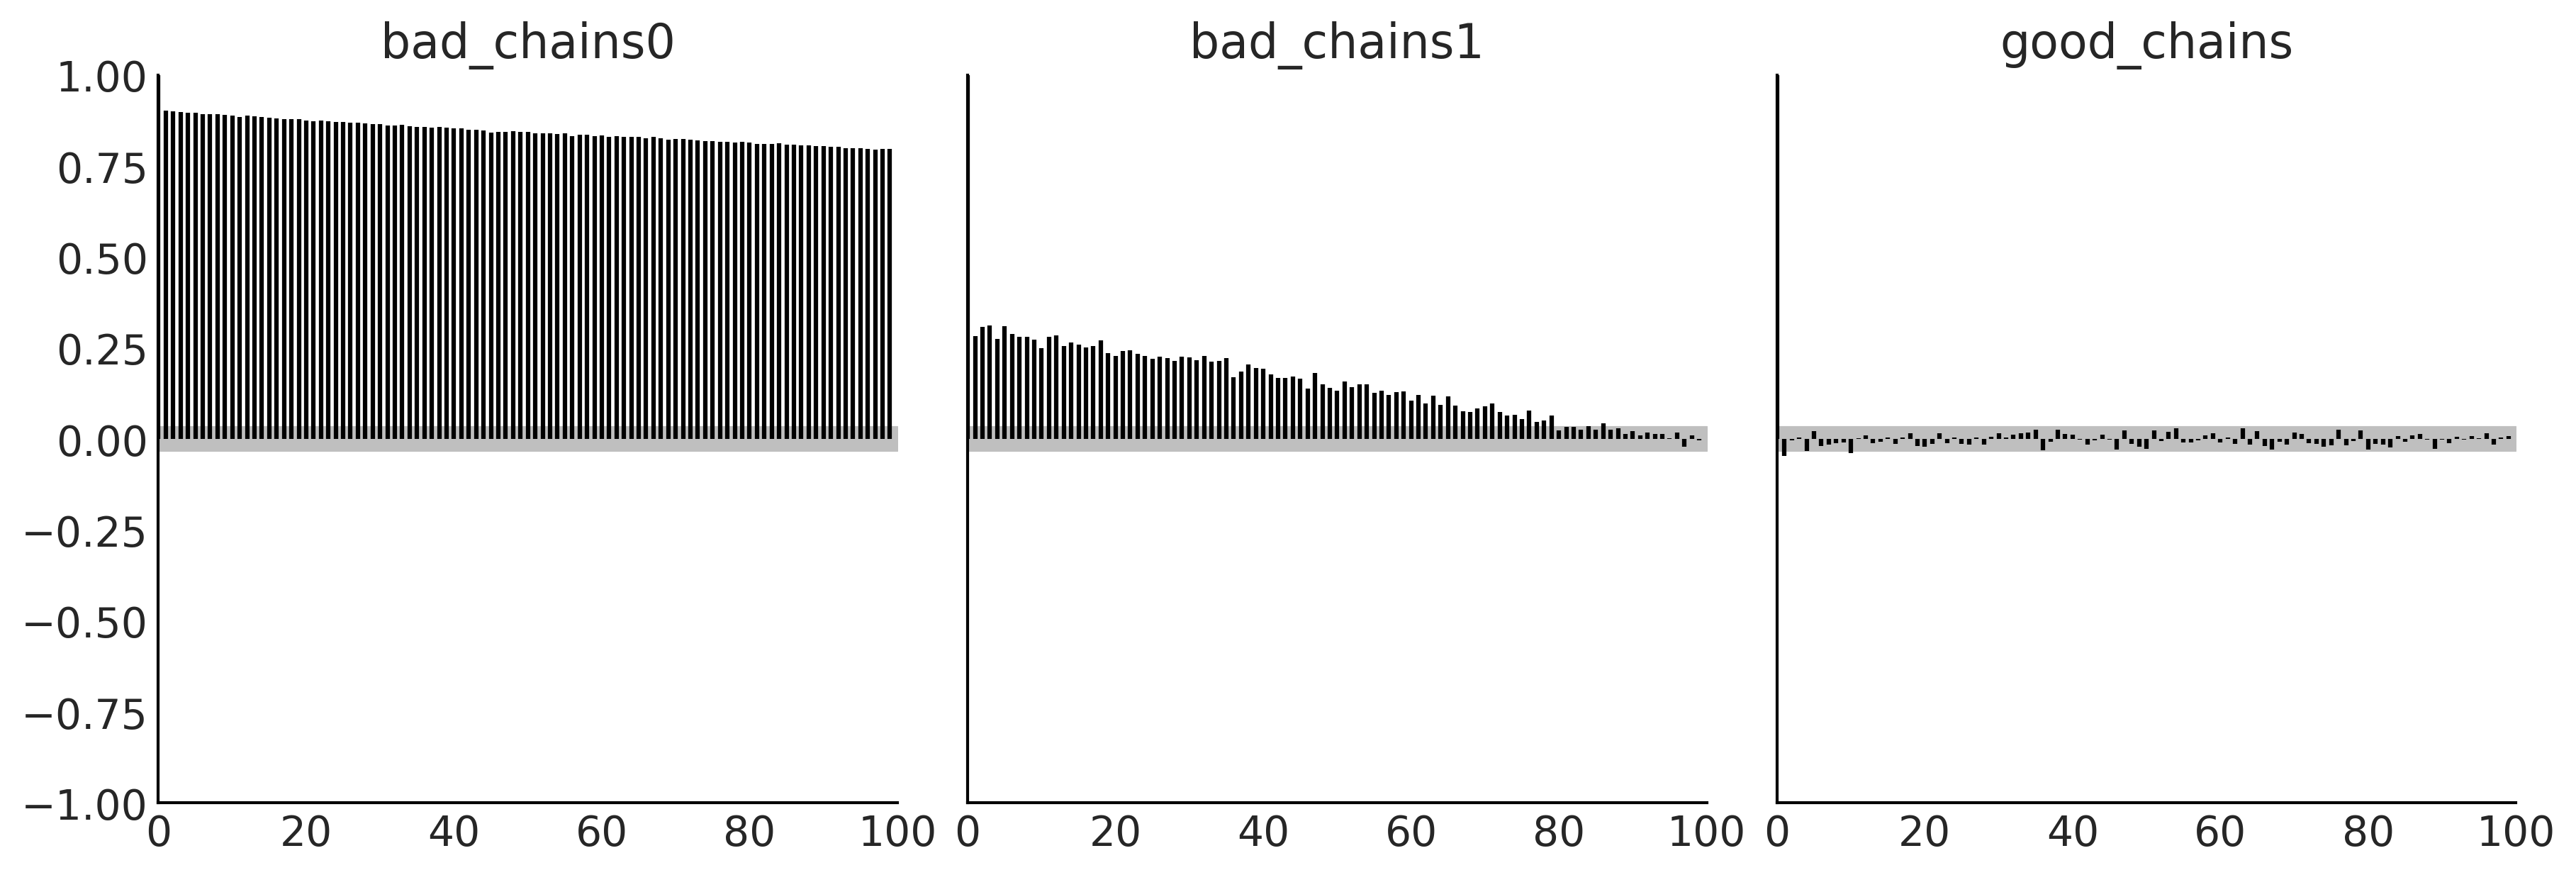

In [21]:
az.plot_autocorr(chains, combined=True, figsize=(12, 4))
plt.savefig('img/chp02/autocorrelation_plot.png')

(rank-plots)=

### 2.4.6 Rank Plots

Rank plots are another visual diagnostic we can use to compare the
sampling behavior both within and between chains. Rank plots, simply
put, are histograms of the ranked samples. The ranks are computed by
first combining all chains but then plotting the results separately for
each chain. If all of the chains are targeting the same distribution, we
expect the ranks to have a Uniform distribution. Additionally if rank
plots of all chains look similar, this indicates good mixing of the
chains {cite:p}`vehtari_rank_2019`.

```python
az.plot_rank(chains, ax=ax[0], kind="bars")
```

```{figure} figures/rank_plot_bars.png
:name: fig:rank_plot_bars
:width: 8.00in
Rank plots using the `bar` representation. In particular, compare the
height of the bar to the dashed line representing a Uniform
distribution. Ideally, the bars should follow a Uniform distribution.
```

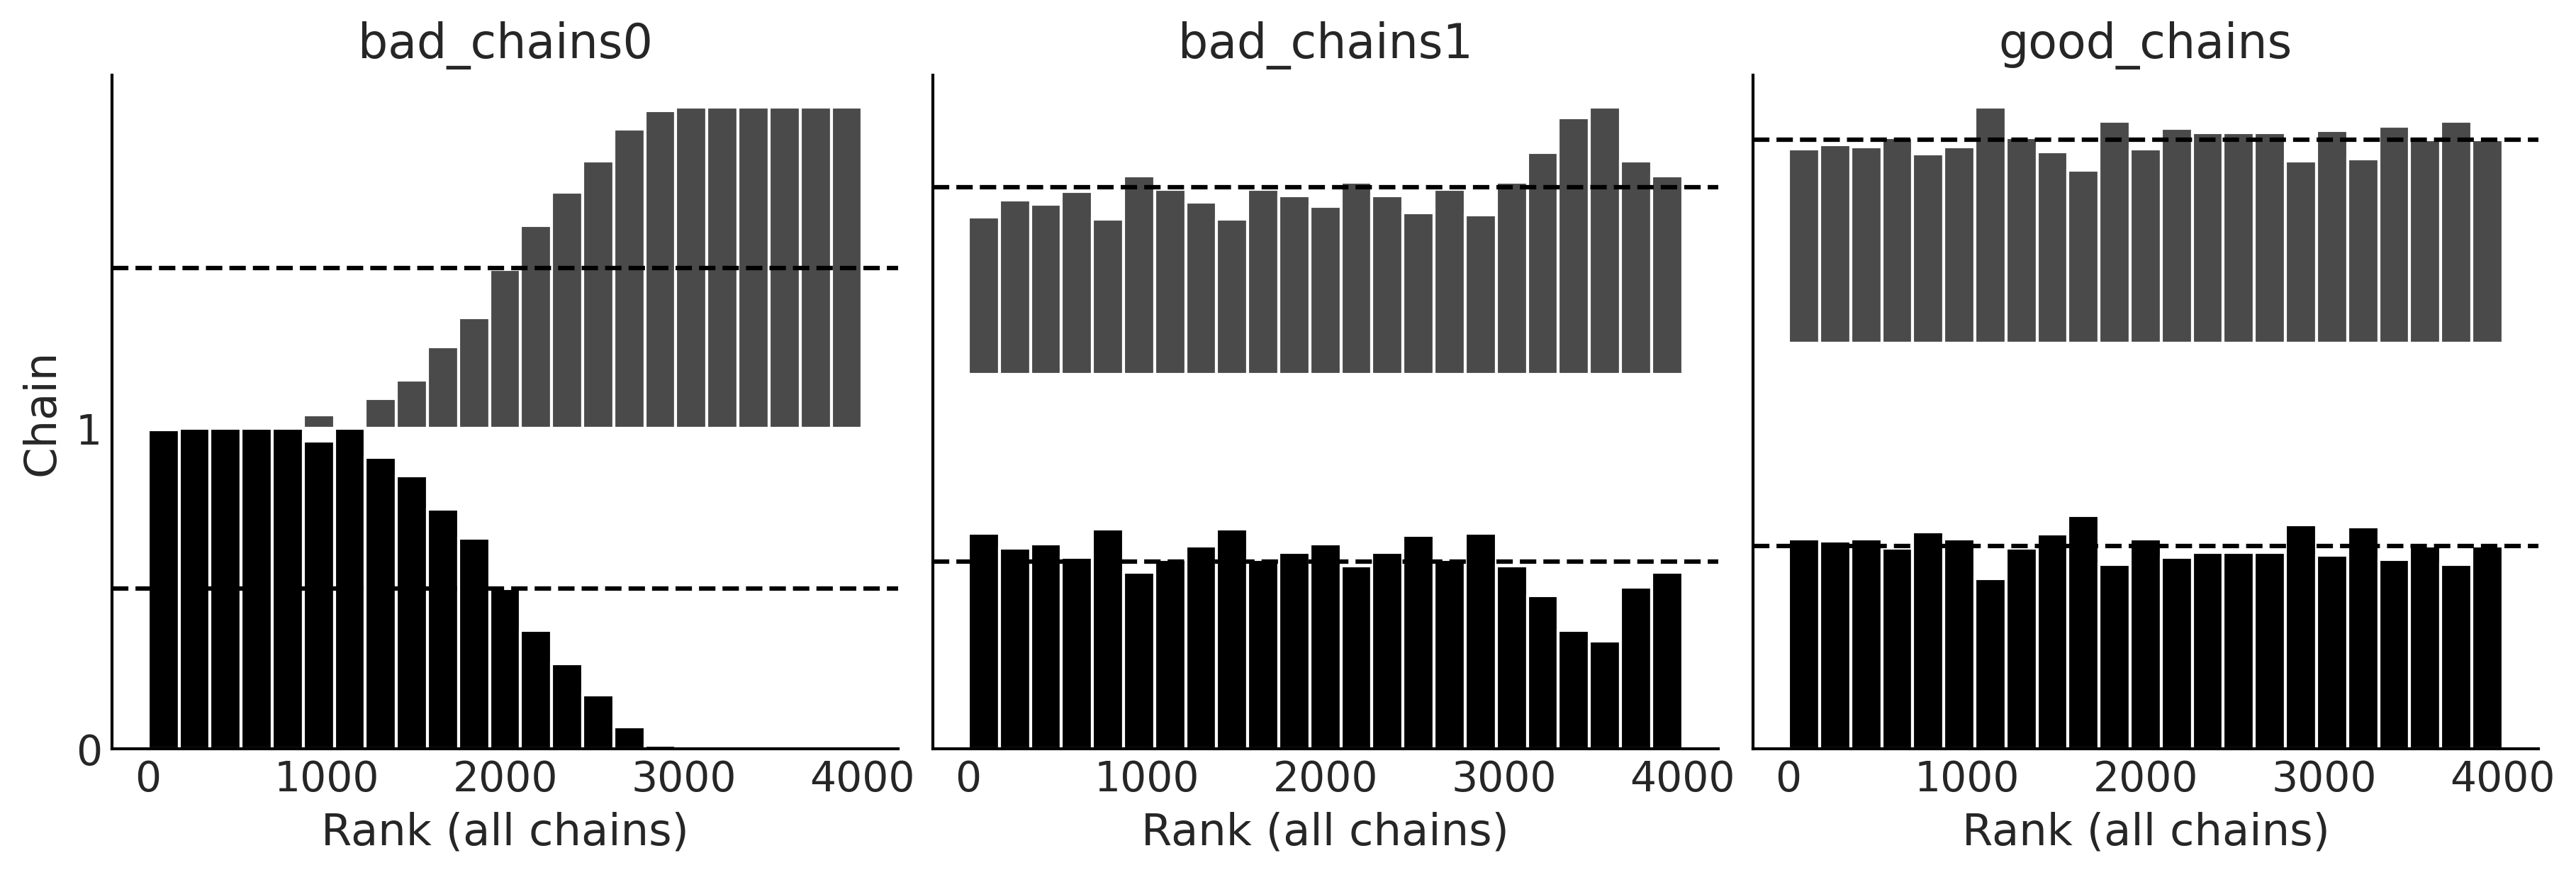

In [22]:
_, axes = plt.subplots(1, 3, figsize=(12, 4))
az.plot_rank(chains, kind="bars", ax=axes)
for ax_ in axes[1:]:
    ax_.set_ylabel("")
    ax_.set_yticks([])

plt.savefig('img/chp02/rank_plot_bars.png')

One alternative to the "bars\" representation is vertical lines,
shortened to "vlines\".

```python
az.plot_rank(chains, kind="vlines")
```

```{figure} figures/rank_plot_vlines.png
:name: fig:rank_plot_vlines
:width: 8.00in
Rank plots using the `vline` representation. The shorter the vertical
lines the better. vertical lines above the dashed line indicate an
excess sampled values for a particular rank, vertical lines below
indicate a lack of sampled values.
```

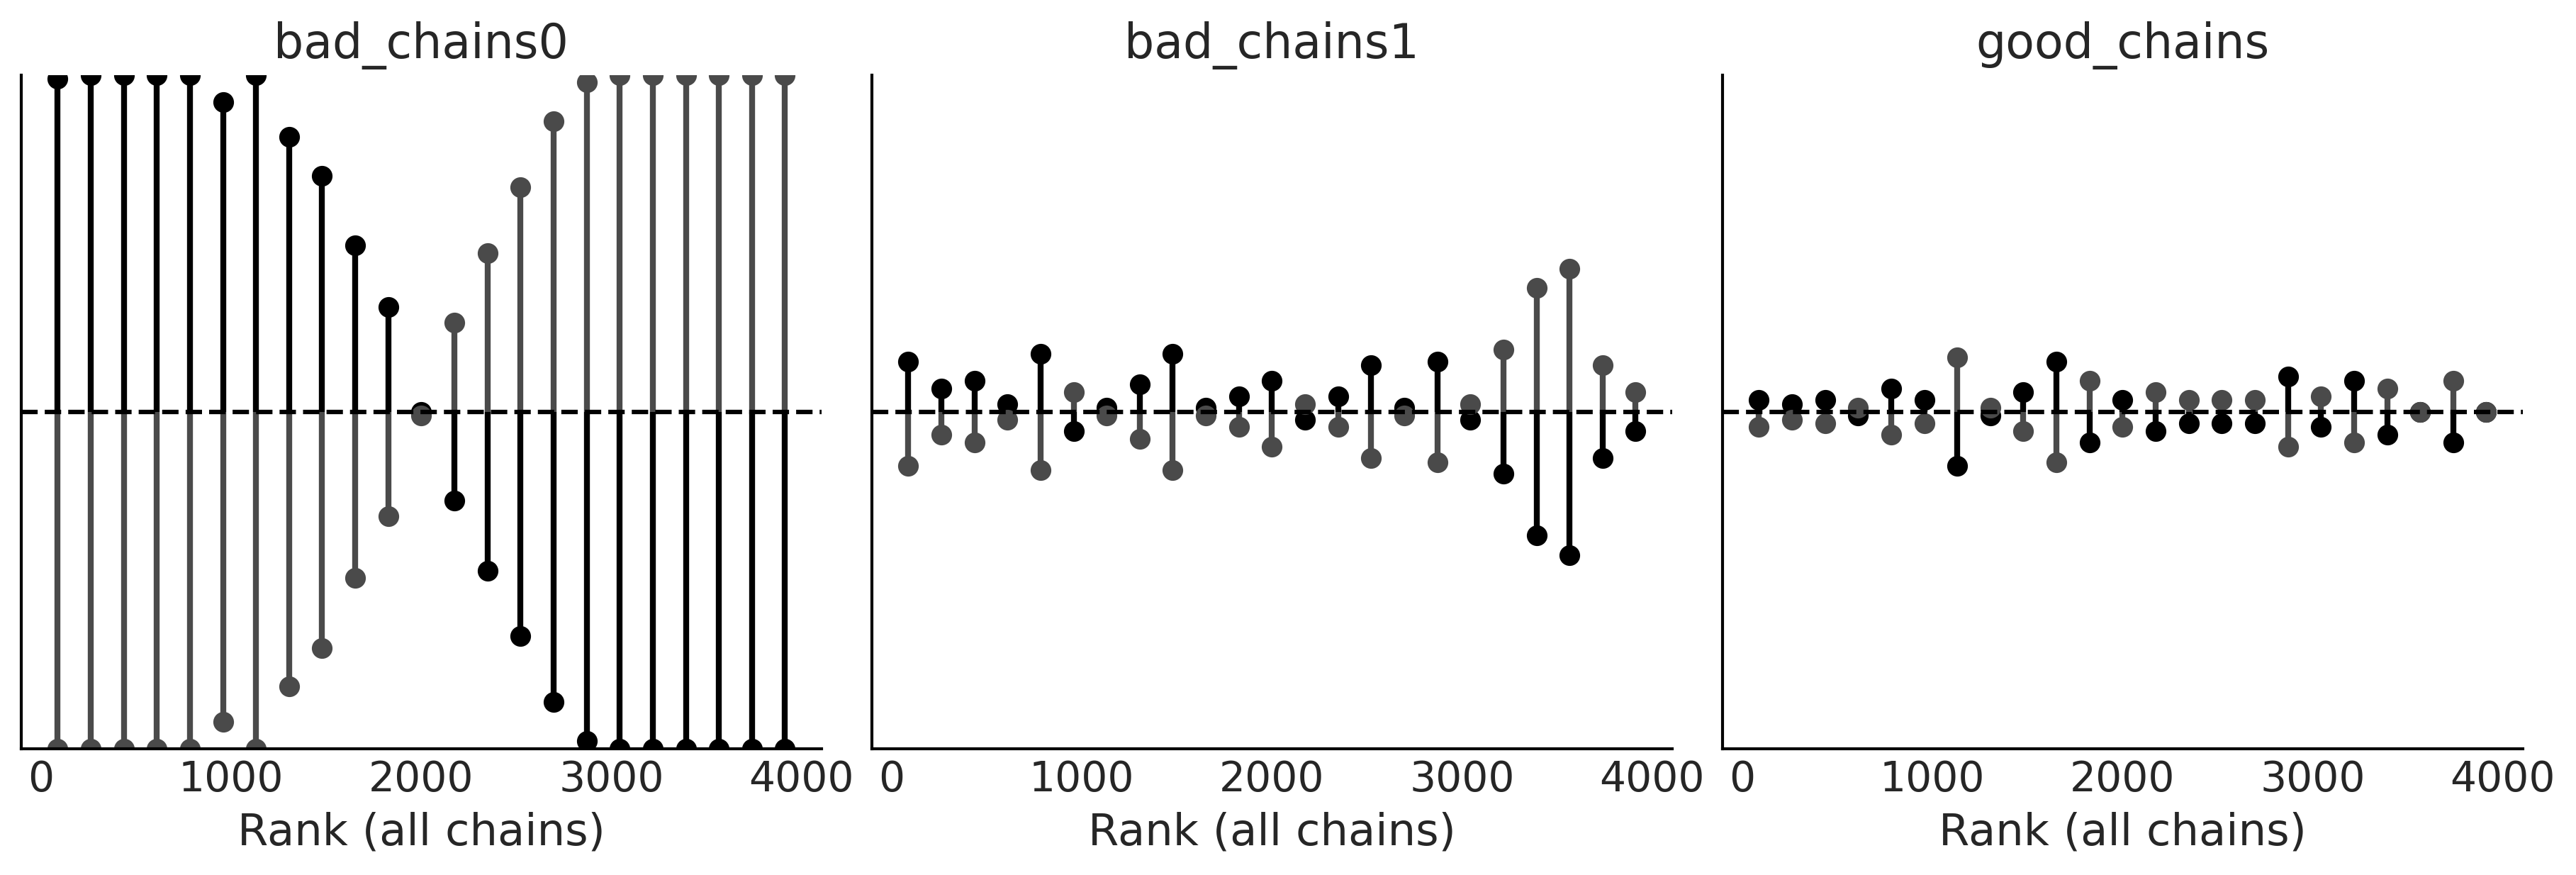

In [23]:
az.plot_rank(chains, kind="vlines", figsize=(12, 4))
plt.savefig('img/chp02/rank_plot_vlines.png')

We can see in Figures {numref}`fig:rank_plot_bars` and
{numref}`fig:rank_plot_vlines` that for `good_chains` the ranks are very
close to Uniform and that both chains look similar to each other with
not distinctive pattern. This is in clear contrast with the results for
`bad_chains0` where the chains depart from uniformity, and they are
exploring two separate sets of value, with some overlap over the middle
ranks. Notice how this is consistent to the way we created `bad_chains0`
and also with what we saw in its trace plot. `bad_chains1` is somehow
Uniform but with a few large deviations here and there, reflecting that
the problems are more *local* than those from `bad_chains0`.

Rank plots can be more sensitive than trace plots, and thus we recommend
them over the latter. We can obtain them using
`az.plot_trace(., kind="rank_bars")` or
`az.plot_trace(., kind="rank_vlines")`. These functions not only plot
the ranks but also the marginal distributions of the posterior. This
kind of plot can be useful to quickly get a sense of what the posterior
*looks like*, which in many cases can help us to spot problems with
sampling or model definition, especially during the early phases of
modeling when we are most likely not sure about what we really want to
do and as a result, we need to explore many different alternatives. As
we progress and the model or models start to make more sense we can then
check that the ESS, $\hat R$, and MCSE are okay and if not okay know
that our model needs further refinements.

(divergences)=

### 2.4.7 Divergences

So far we have been diagnosing how well a sampler works by studying the
generated samples. Another way to perform a diagnostic is by monitoring
the behavior of the inner workings of the sampling method. One prominent
example of such diagnostics is the concept of divergences present in
some **Hamiltonian Monte Carlo** (HMC) methods [^11]. Divergences, or
more correctly divergent transitions, are a powerful and sensitive way
of diagnosing samples and works as complement to the diagnostics we saw
in the previous sections.

Let us discuss divergences in the context of a very simple model, we
will find more realistic examples later through the book. Our model
consists of a parameter $\theta2$ following a Uniform distribution in
the interval $[-\theta1, \theta1]$, and $\theta1$ is sampled from a
normal distribution. When $\theta1$ is large $\theta2$ will follow a
Uniform distribution spanning a wide range, and when $\theta1$
approaches zero, the width of $\theta2$ will also approach zero. Using
PyMC3 we can write this model as:

```{code-block} python
:name: divm0
:caption: divm0

with pm.Model() as model_0:
    θ1 = pm.Normal("θ1", 0, 1, testval=0.1)
    θ2 = pm.Uniform("θ2", -θ1, θ1)
    idata_0 = pm.sample(return_inferencedata=True)
```

[^11]: Most useful and commonly used sampling methods for Bayesian
    inference are variants of HMC, including for example, the default
    method for continuous variables in PyMC3. For more details of this
    method, see Section {ref}`hmc`).

In [24]:
with pm.Model() as model_0:
    θ1 = pm.Normal("θ1", 0, 1, initval=0.1)
    θ2 = pm.Uniform("θ2", -θ1, θ1)
    idata_0 = pm.sample(return_inferencedata=True)

with pm.Model() as model_1:
    θ1 = pm.HalfNormal("θ1", 1 / (2/np.pi)**0.5)
    θ2 = pm.Uniform("θ2", -θ1, θ1)
    idata_1 = pm.sample(return_inferencedata=True)

with pm.Model() as model_1bis:
    θ1 = pm.HalfNormal("θ1", 1 / (2/np.pi)**0.5)
    θ2 = pm.Uniform("θ2", -θ1, θ1)
    idata_1bis = pm.sample(return_inferencedata=True, target_accept=0.95)

idatas = [idata_0, idata_1, idata_1bis]

Sampling 4 chains, 0 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:00:00

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


::: {admonition} The ArviZ InferenceData format

`az.InferenceData` is a specialized data format designed for MCMC Bayesian users.
It is based on xarray
{cite:p}`hoyer2017`, a flexible N dimensional array package. The main purpose
of the InferenceData object is to provide a convenient way to store and
manipulate the information generated during a Bayesian workflow,
including samples from distributions like the posterior, prior,
posterior predictive, prior predictive and other information and
diagnostics generated during sampling. InferenceData objects keeps all
this information organized using a concept called groups.

In this book we extensively utilize `az.InferenceData`. We use it to
store Bayesian inference results, calculate diagnostics, generate plots,
and read and write from disk. Refer to the ArviZ documentation for a
full technical specification and API.
:::

Notice how the model in Code Block [divm0](divm0) is not
conditioned on any observations, which means `model_0` specifies a
posterior distribution parameterized by two unknowns (`θ1` and `θ2`).
You may have also noticed that we have included the argument
`testval=0.1`. We do this to instruct PyMC3 to start sampling from a
particular value ($0.1$ in this example), instead of from its default.
The default value is $\theta1 = 0$ and for that value the probability
density function of $\theta2$ is a Dirac delta [^12], which will produce
an error. Using `testval=0.1` only affects how the sampling is
initialized.

In {numref}`fig:divergences_trace` we can see vertical bars at the
bottom of the KDEs for `model0`. Each one of these bars represents a
divergence, indicating that something went wrong during sampling. We can
see something similar using other plots, like with
`az.plot_pair(., divergences=True)` as shown in
{numref}`fig:divergences_pair`, here the divergences are the blue dots,
which are everywhere!

```{figure} figures/divergences_trace.png
:name: fig:divergences_trace
:width: 8.00in
KDEs and rank plots for Model 0 Code [divm0](divm0), Model
1 [divm1](divm1) and Model 1bis, which is the same as
Model 1 [divm1](divm1) but with
`pm.sample(., target_accept=0.95)`. The black vertical bars represent
divergences.
```

```{figure} figures/divergences_pair.png
:name: fig:divergences_pair
:width: 8.00in
Scatter plot of the posterior samples from Model 0 from Code
[divm0](divm0), Model 1 from Code Block
[divm1](divm1), and Model 1bis, which is the same as Model
1 in Code Block [divm1](divm1) but with
`pm.sample(., target_accept=0.95)`. The blue dots represent divergences.
```                             

[^12]: A function which is zero everywhere and infinite at zero.

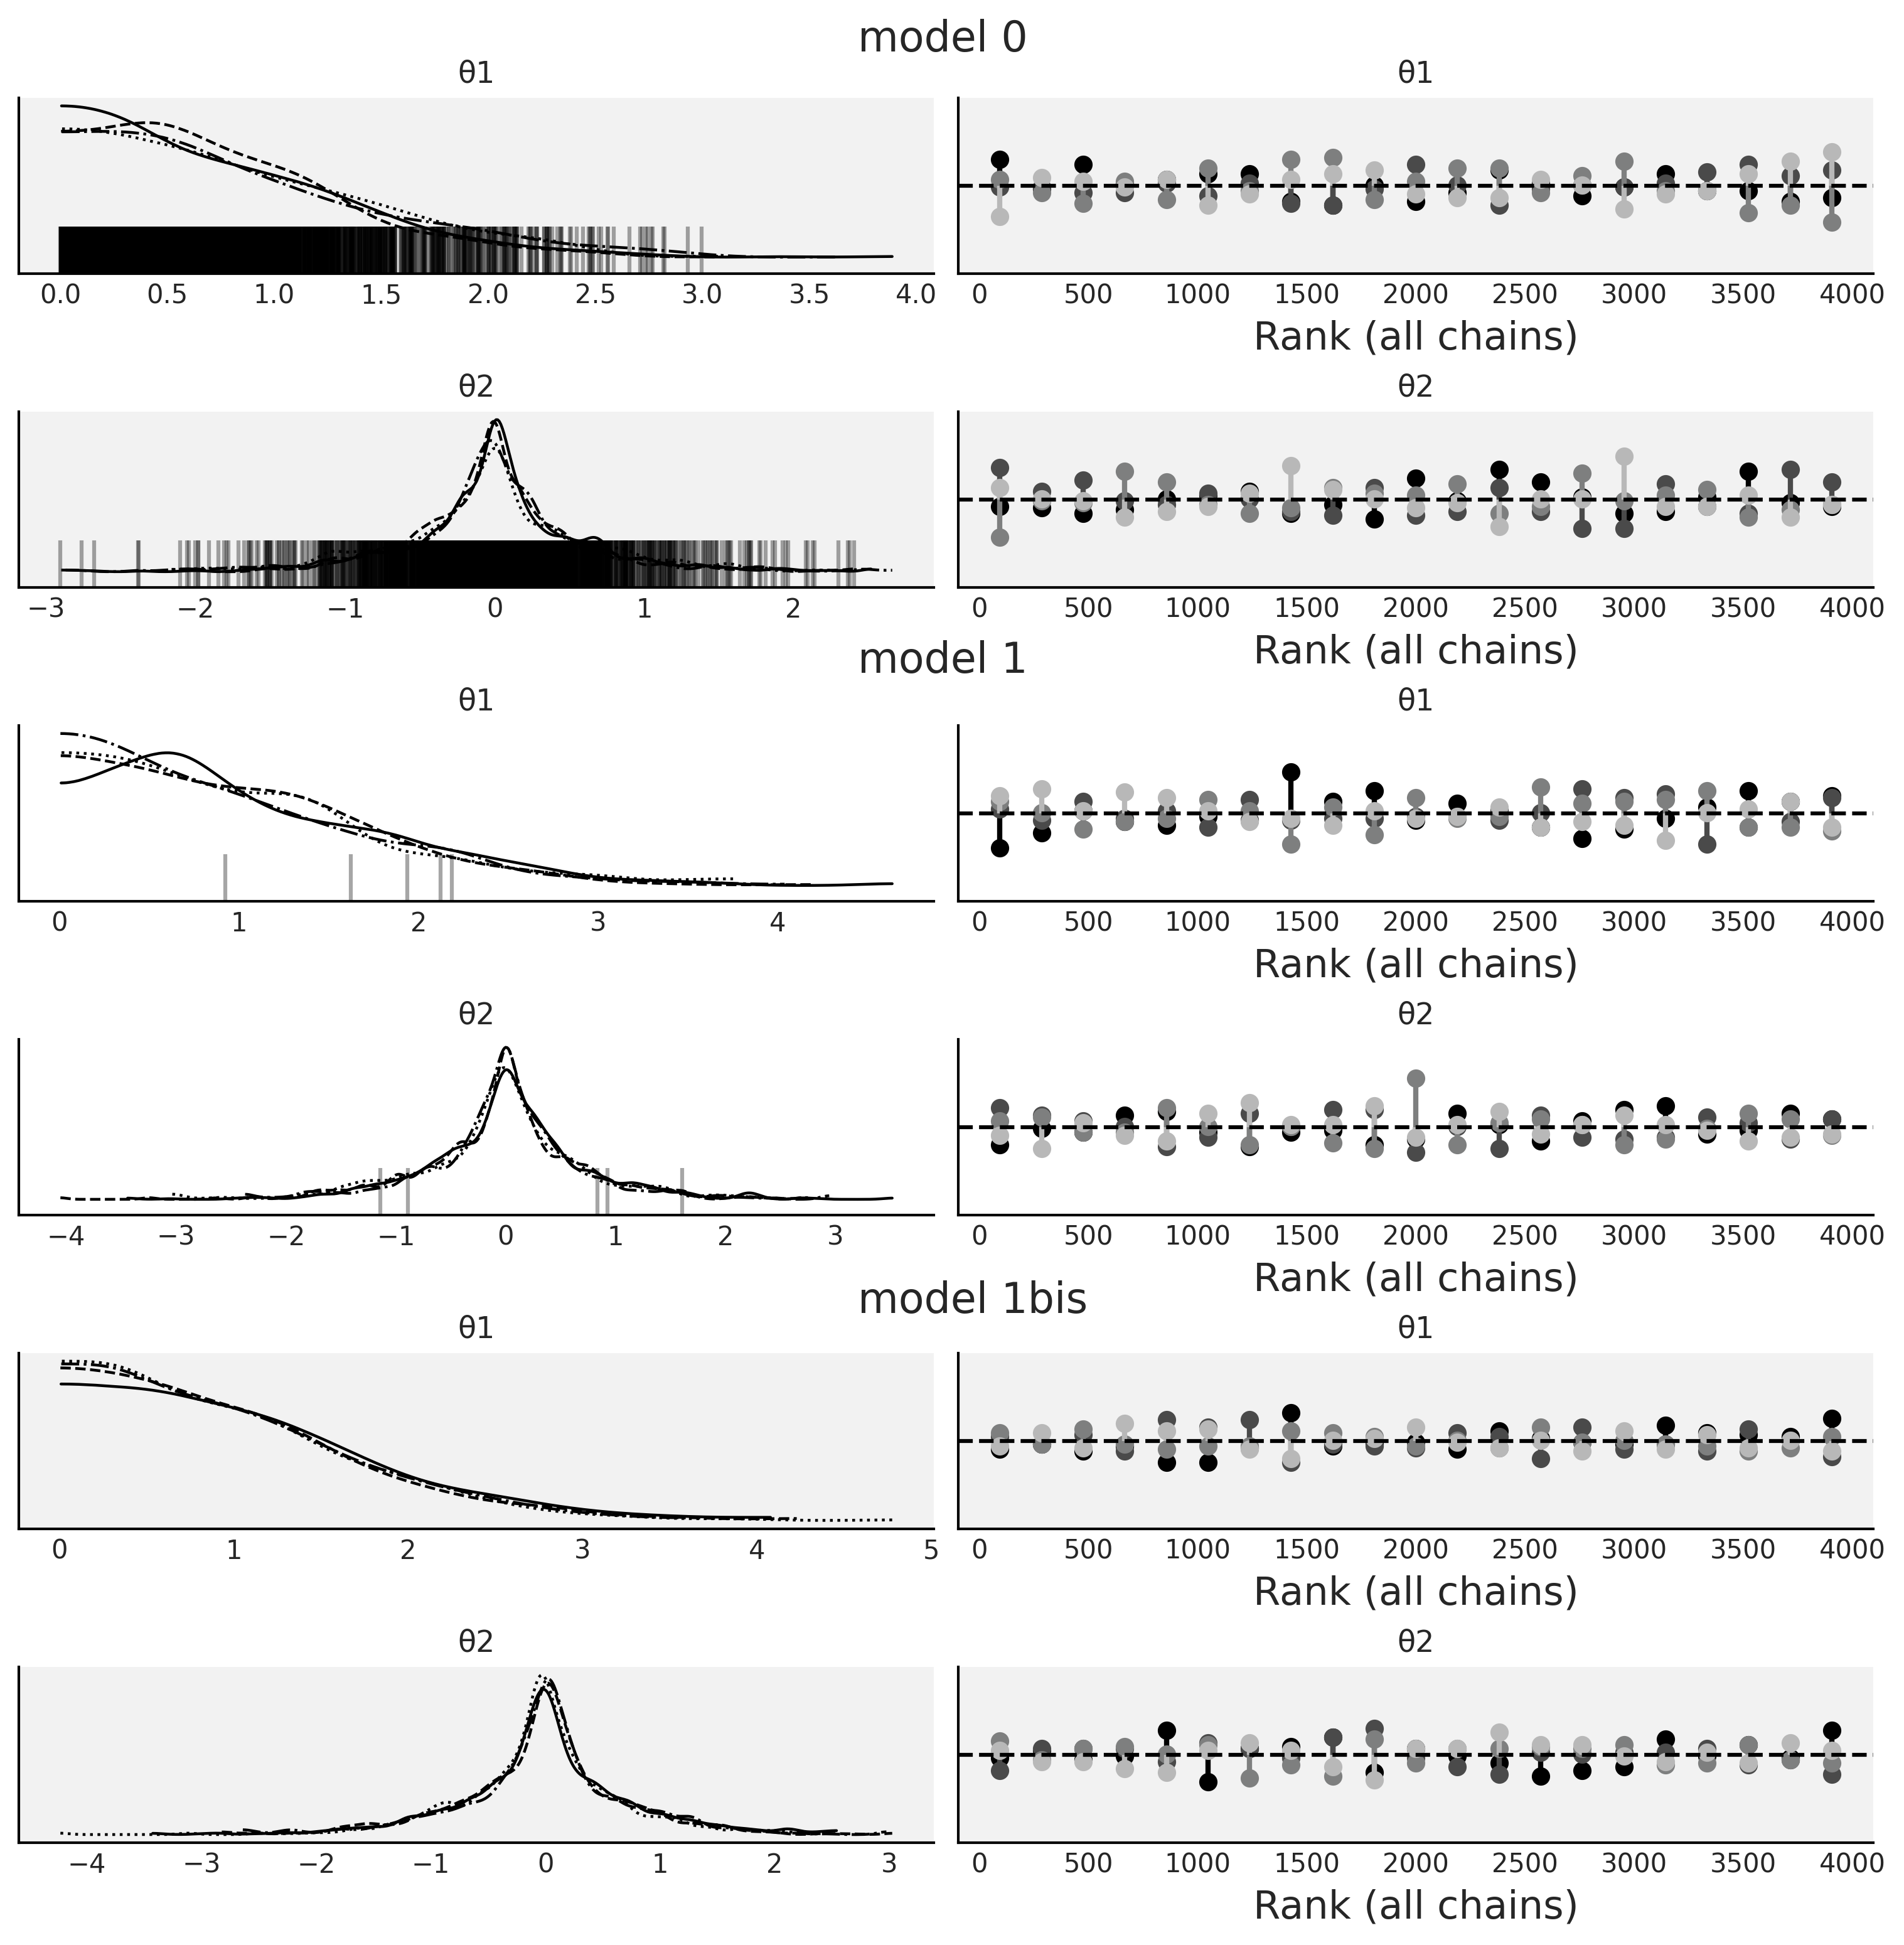

In [25]:
fig, axes = plt.subplots(6, 2, figsize=(10, 10))

axes = axes.reshape(3, 2, 2)
for idata, ax, color in zip(idatas, axes, ["0.95", "1", "0.95"]):
    az.plot_trace(idata, kind="rank_vlines", axes=ax);
    [ax_.set_facecolor(color) for ax_ in ax.ravel()]
fig.text(0.45, 1, s="model 0", fontsize=16)
fig.text(0.45, 0.67, s="model 1", fontsize=16)
fig.text(0.45, 0.33, s="model 1bis", fontsize=16)
plt.savefig("img/chp02/divergences_trace.png", bbox_inches="tight")

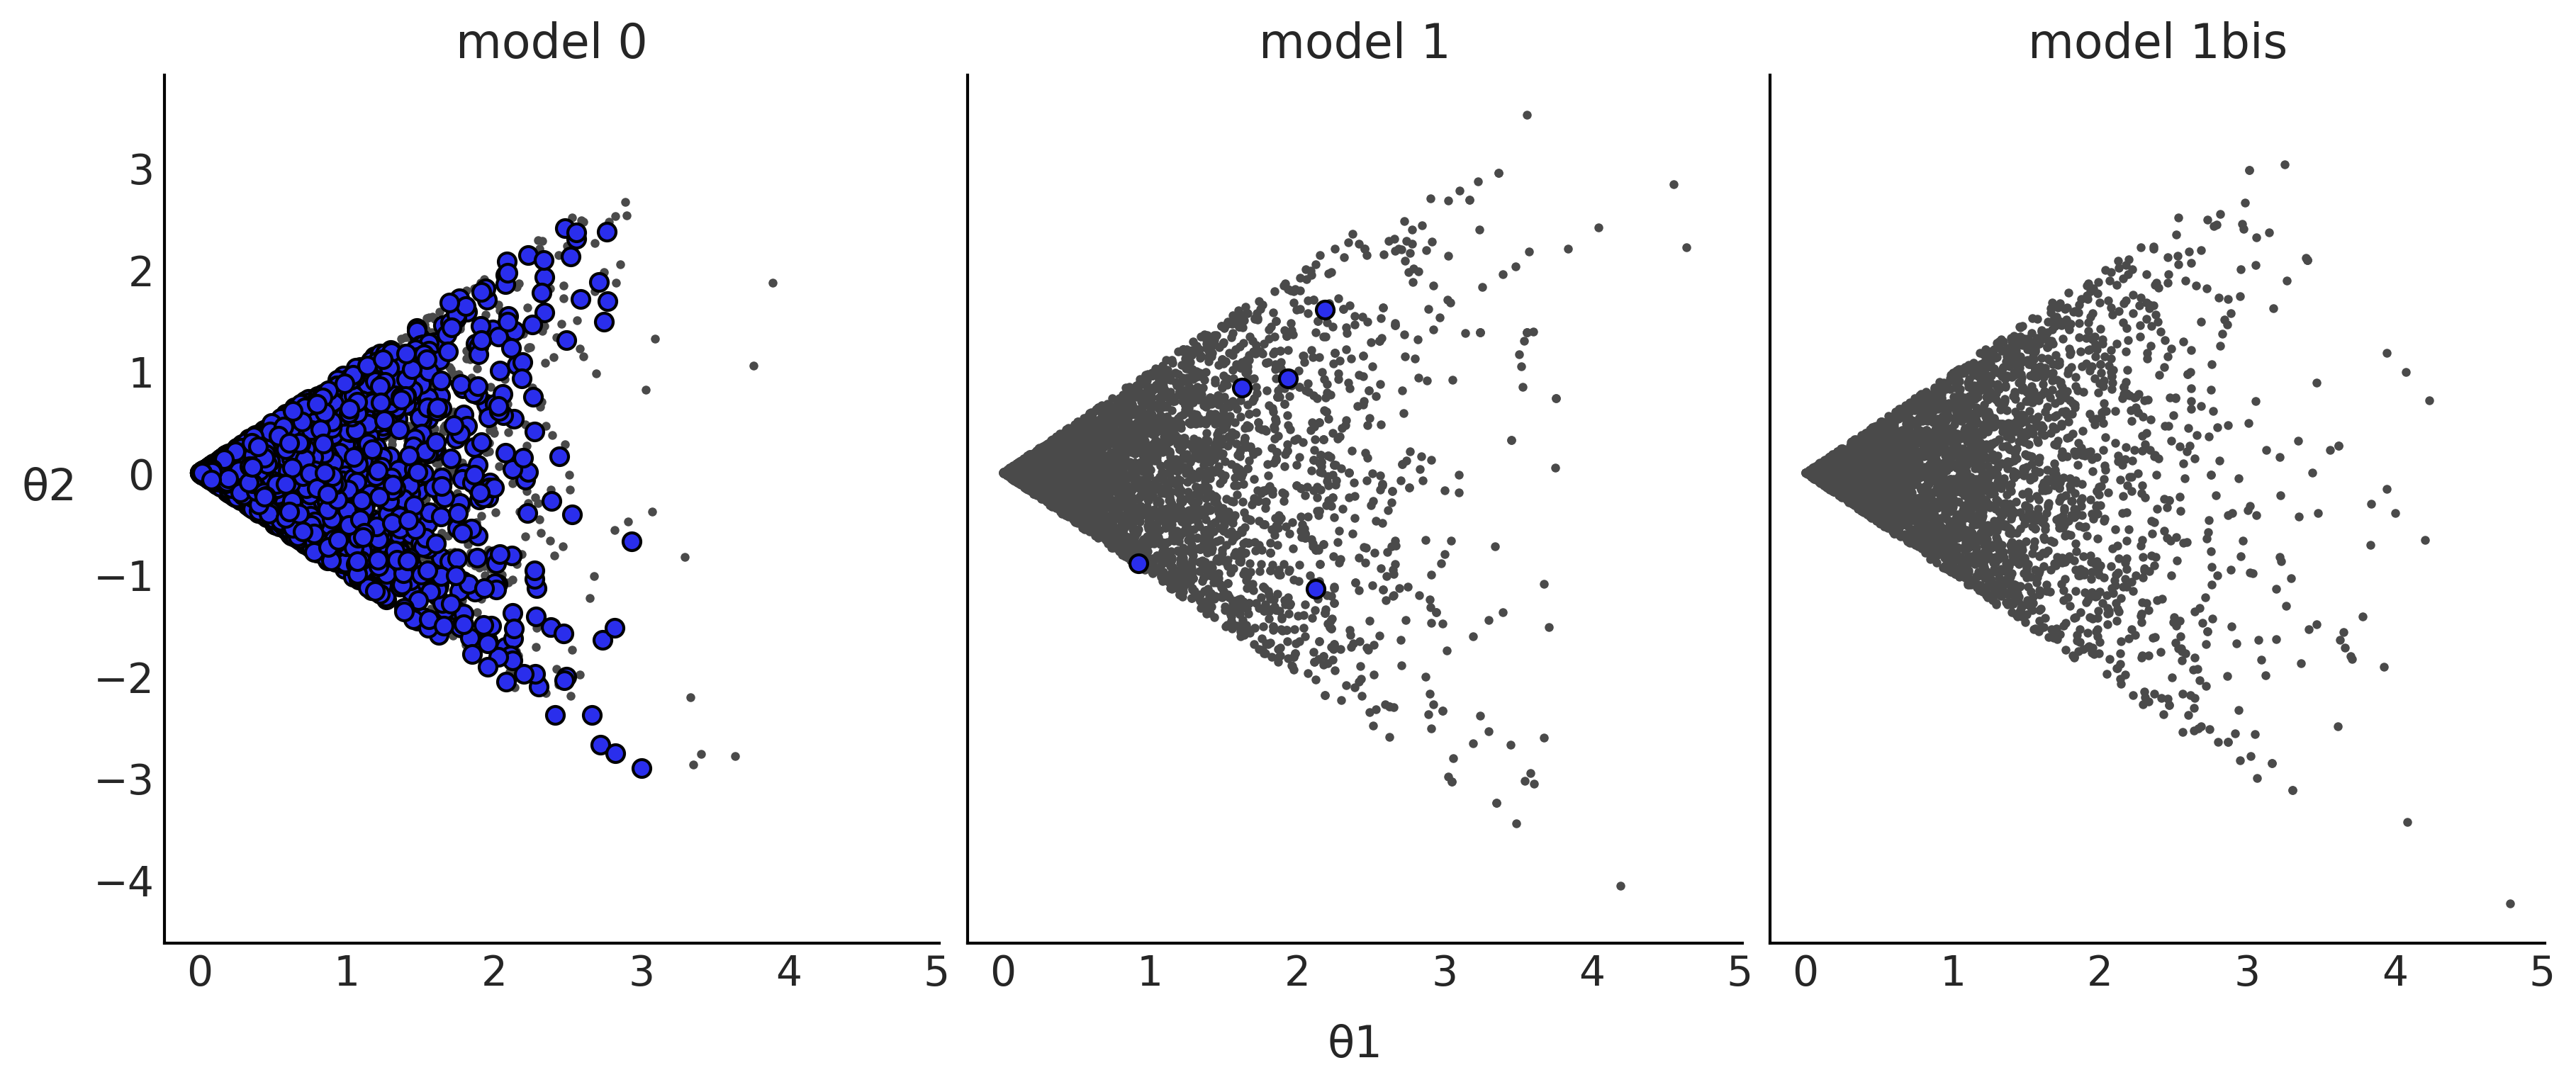

In [26]:
_, axes = plt.subplots(1, 3, figsize=(12, 5), sharex=True, sharey=True)

for idata, ax, model in zip(idatas, axes, ["model 0", "model 1", "model 1bis"]):
    az.plot_pair(idata, divergences=True, scatter_kwargs={"color":"C1"}, divergences_kwargs={"color":"C4"}, ax=ax)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title(model)
axes[0].set_ylabel('θ2', rotation=0, labelpad=15)
axes[1].set_xlabel('θ1', labelpad=10)
plt.savefig("img/chp02/divergences_pair.png")

Something is definitely problematic with `model0`. Upon inspection of
the model definition in Code Block [divm0](divm0) we may
realize that we defined it in a weird way. $\theta1$ is a Normal
distribution centered at 0, and thus we should expect half of the values
to be negative, but for negative values $\theta2$ will be defined in the
interval $[\theta1, -\theta1]$, which is at least a little bit weird.
So, let us try to **reparameterize** the model, i.e. express the model
in a different but mathematically equivalent way. For example, we can
do:

```{code-block} python
:name: divm1
:caption: divm1
with pm.Model() as model_1:
    θ1 = pm.HalfNormal("θ1", 1 / (1-2/np.pi)**0.5)
    θ2 = pm.Uniform("θ2", -θ1, θ1)
    idata_1 = pm.sample(return_inferencedata=True)
```

Now $\theta1$ will always provide reasonable values we can feed into the
definition of $\theta2$. Notice that we have defined the standard
deviation of $\theta1$ as $\frac{1}{\sqrt{(1-\frac{2}{\pi})}}$ instead
of just 1. This is because the standard deviation of the half-normal is
$\sigma \sqrt{(1-\frac{2}{\pi})}$ where $\sigma$ is the scale parameter
of the half-normal. In other words, $\sigma$ is the standard deviation
of the *unfolded* Normal, not the Half-normal distribution.

Anyway, let us see how these reparameterized models do with respect to
divergences. {numref}`fig:divergences_trace` and
{numref}`fig:divergences_pair` show that the number of divergences has
been reduced dramatically for `model1`, but we still can see a few of
them. One easy option we can try to reduce divergences is increasing the
value of `target_accept` as shown in Code Block
[divm2](divm2), by default this value is 0.8 and the
maximum valid value is 1 (see Section {ref}`hmc` for details).

```{code-block} python
:name: divm2
:caption: divm2
with pm.Model() as model_1bis:
    θ1 = pm.HalfNormal("θ1", 1 / (1-2/np.pi)**0.5)
    θ2 = pm.Uniform("θ2", -θ1, θ1)
    idata_1bis = pm.sample(target_accept=.95, return_inferencedata=True)
```

`model1bis` in {numref}`fig:divergences_trace` and
{numref}`fig:divergences_pair` is the same as `model1` but with we have
changed the default value of one of the sampling parameters
`pm.sample(., target_accept=0.95)`. We can see that finally we have
removed all the divergences. This is already good news, but in order to
trust these samples, we still need to check the value of $\hat R$ and
ESS as explained in previous sections.

::: {admonition} Reparameterization

Reparameterization can be useful to turn a difficult
to sample posterior geometry into an easier one. This could help to
remove divergences, but it can also help even if no divergences are
present. For example, we can use it to speed up sampling or increase the
number of effective samples, without having to increase the
computational cost. Additionally, reparameterization can also help to
better interpret or communicate models and their results (see Alice and
Bob example in Section {ref}`conjugate_priors`).
:::

(sampler-parameters-and-other-diagnostics)=

### 2.4.8 Sampler Parameters and Other Diagnostics

Most sampler methods have hyperparameters that affect the sampler
performance. While most PPLs try to use sensible defaults, in practice,
they will not work for every possible combination of data and models. As
we saw in the previous sections, divergences can sometimes be removed by
increasing the parameter `target_accept`, for example, if the
divergences originated from numerical imprecision. There are other
sampler parameters that can also help with sampling issues, for example,
we may want to increase the number of iterations used to tune MCMC
samplers. In PyMC3 we have `pm.sample(.,tune=1000)` by default. During
the tuning phase sampler parameters get automatically adjusted. Some
models are more complex and require more interactions for the sampler to
learn better parameters. Thus increasing the tuning steps can help to
increase the ESS or lower the $\hat R$. Increasing the number of draws
can also help with convergence but in general other routes are more
productive. If a model is failing to converge with a few thousands of
draws, it will generally still fail with 10 times more draws or the
slight improvement will not justify the extra computational cost.
Reparameterization, improved model structure, more informative priors,
or even changing the model will most often be much more effective [^13].
We want to note that in the early stages of modeling we could use a
relatively low number of draws to test that the model runs, that we have
actually written the intended model, that we broadly get reasonable
results. For this initial check around 200 or 300 is typically
sufficient., Then we can increase the number of draws to a few thousand,
maybe around 2000 or 4000, when we are more confident about the model.

In addition to the diagnostics shown in this chapter, additional
diagnostics exist, such as parallel plots, and separation plots. All
these diagnostics are useful and have their place but for the brevity of
this text we have omitted them from this section. To see others we
suggest visiting the ArviZ documentation and plot gallery which contains
many more examples.

[^13]: For a sampler like Sequential Monte Carlo, increasing the number
    of draws also increases the number of particles, and thus it could
    actually provide better convergence. See Section {ref}`smc_details`.

(model_cmp)=

## 2.5 Model Comparison

Usually we want to build models that are not too simple that they miss
valuable information in our data nor too complex that they fit the noise
in the data. Finding this *sweet spot* is a complex task. Partially
because there is not a single criteria to define an optimal solution,
partly because such optimal solution may not exist, and partly because
in practice we need to choose from a limited set of models evaluated
over a finite dataset.

Nevertheless, we can still try to find good general strategies. One
useful solution is to compute the generalization error, also known as
out-of-sample predictive accuracy. This is an estimate of how well a
model behaves at predicting data not used to fit it. Ideally, any
measure of predictive accuracy should take into account the details of
the problem we are trying to solve, including the benefits and costs
associated with the model's predictions. That is, we should apply a
decision theoretic approach. However, we can also rely on general
devices that are applicable to a wide range of models and problems. Such
devices are sometimes referred to as scoring rules, as they help us to
score and rank models. From the many possible scoring rules it has been
shown that the logarithmic scoring rule has very nice theoretical
properties {cite:p}`gneiting_2007`, and thus is widely used. Under a Bayesian
setting the log scoring rule can be computed as.

```{math}
:label: eq:elpd
\text{ELPD} = \sum_{i=1}^{n} \int p_t(\tilde y_i) \; \log p(\tilde y_i \mid y_i) \; d\tilde y_i

```

where $p_t(\tilde y_i)$ is the distribution of the true data-generating
process for $\tilde y_i$ and $p(\tilde y_i \mid y_i)$ is the posterior
predictive distribution. The quantity defined in Equation {eq}`eq:elpd`
is known as the **expected log pointwise predictive density** (ELPD).
Expected because we are integrating over the true data-generating
process i.e over all the possible datasets that could be generated from
that process, and pointwise because we perform the computations per
observation ($y_i$), over the $n$ observations. For simplicity we use
the term density for both continuous and discrete models [^14].

For real problems we do not know $p_t(\tilde y_i)$ and thus the ELPD as
defined in Equation {eq}`eq:elpd` is of no immediate use, in practice we
can instead compute:

```{math}
:label: eq:elpd_practice
\sum_{i=1}^{n} \log \int \ p(y_i \mid \boldsymbol{\theta}) \; p(\boldsymbol{\theta} \mid y) d\boldsymbol{\theta}

```

The quantity defined by Equation {eq}`eq:elpd_practice` (or that
quantity multiplied by some constant) is usually known as the deviance,
and it is used in both Bayesians and non-Bayesians contexts [^15]. When
the likelihood is Gaussian, then Equation {eq}`eq:elpd_practice` will be
proportional to the quadratic mean error.

To compute Equation {eq}`eq:elpd_practice` we used the same data used to
fit the model and thus we will, on average, overestimate the ELPD
(Equation {eq}`eq:elpd`) which will lead us to choose models prone to
overfitting. Fortunately, there are a few ways to produce better
estimations of the ELPD. One of them is cross-validation as we will see
in the next section.

[^14]: Strictly speaking we should use probabilities for discrete
    models, but that distinction rapidly becomes annoying in practice.

[^15]: In non-Bayesians contexts $\boldsymbol{\theta}$ is a point
    estimate obtained, for example, by maximizing the likelihood.

(CV_and_LOO)=

### 2.5.1 Cross-validation and LOO

Cross-validation (CV) is a method of estimating out-of-sample predictive
accuracy. This method requires re-fitting a model many times, each time
excluding a different portion of the data. The excluded portion is then
used to measure the accuracy of the model. This process is repeated many
times and the estimated accuracy of the model will be the average over
all runs. Then the entire dataset is used to fit the model one more time
and this is the model used for further analysis and/or predictions. We
can see CV as a way to simulate or approximate out-of-sample statistics,
while still using all the data.

Leave-one-out cross-validation (LOO-CV) is a particular type of
cross-validation when the data excluded is a single data-point. The ELPD
computed using LOO-CV is $\text{ELPD}_\text{LOO-CV}$:

```{math}
:label: eq:elpd_loo_cv
\text{ELPD}_\text{LOO-CV} = \sum_{i=1}^{n} \log
    \int \ p(y_i \mid \boldsymbol{\theta}) \; p(\boldsymbol{\theta} \mid y_{-i}) d\boldsymbol{\theta}

```

Computing Equation {eq}`eq:elpd_loo_cv` can easily become too costly as
in practice we do not know $\boldsymbol{\theta}$ and thus we need to
compute $n$ posteriors, i.e. as many values of
$\boldsymbol{\theta_{-i}}$ as observations we have in our dataset.
Fortunately, we can approximate $\text{ELPD}_\text{LOO-CV}$ from a
single fit to the data by using a method known as Pareto smoothed
importance sampling leave-one-out cross validation PSIS-LOO-CV (see Section
{ref}`loo_depth` for details). For brevity, and for
consistency with ArviZ, in this book we call this method LOO. It is
important to remember we are talking about PSIS-LOO-CV and unless we
state it otherwise when we refer to ELPD we are talking about the ELPD
as estimated by this method.

ArviZ provides many LOO-related functions, using them is very simple but
understanding the results may require a little bit of care. Thus, to
illustrate how to interpret the output of these functions we are going
to use 3 simple models. The models are defined in Code Block
[pymc3_models_for_loo](pymc3_models_for_loo).

```{code-block} python
:name: pymc3_models_for_loo
:caption: pymc3_models_for_loo

y_obs = np.random.normal(0, 1, size=100)
idatas_cmp = {}

# Generate data from Skewnormal likelihood model
# with fixed mean and skewness and random standard deviation
with pm.Model() as mA:
    σ = pm.HalfNormal("σ", 1)
    y = pm.SkewNormal("y", 0, σ, alpha=1, observed=y_obs)
    idataA = pm.sample(return_inferencedata=True)

# add_groups modifies an existing az.InferenceData
idataA.add_groups({"posterior_predictive":
                  {"y":pm.sample_posterior_predictive(idataA)["y"][None,:]}})
idatas_cmp["mA"] = idataA

# Generate data from Normal likelihood model
# with fixed mean with random standard deviation
with pm.Model() as mB:
    σ = pm.HalfNormal("σ", 1)
    y = pm.Normal("y", 0, σ, observed=y_obs)
    idataB = pm.sample(return_inferencedata=True)

idataB.add_groups({"posterior_predictive":
                  {"y":pm.sample_posterior_predictive(idataB)["y"][None,:]}})
idatas_cmp["mB"] = idataB

# Generate data from Normal likelihood model
# with random mean and random standard deviation
with pm.Model() as mC:
    μ = pm.Normal("μ", 0, 1)
    σ = pm.HalfNormal("σ", 1)
    y = pm.Normal("y", μ, σ, observed=y_obs)
    idataC = pm.sample(return_inferencedata=True)

idataC.add_groups({"posterior_predictive":
                  {"y":pm.sample_posterior_predictive(idataC)["y"][None,:]}})
idatas_cmp["mC"] = idataC
```

In [27]:
np.random.seed(90210)

In [28]:
y_obs =  np.random.normal(0, 1, size=100)
idatas_cmp = {}

with pm.Model() as mA:
    σ = pm.HalfNormal("σ", 1)
    y = pm.SkewNormal("y", mu=0, sigma=σ, alpha=1, observed=y_obs)
    idataA = pm.sample(idata_kwargs={"log_likelihood":True})
    idataA.extend(pm.sample_posterior_predictive(idataA))
    idatas_cmp["mA"] = idataA

with pm.Model() as mB:
    σ = pm.HalfNormal("σ", 1)
    y = pm.Normal("y", 0, σ, observed=y_obs)
    idataB = pm.sample(idata_kwargs={"log_likelihood":True})
    idataB.extend(pm.sample_posterior_predictive(idataB))
    idatas_cmp["mB"] = idataB

with pm.Model() as mC:
    μ = pm.Normal("μ", 0, 1)
    σ = pm.HalfNormal("σ", 1)
    y = pm.Normal("y", μ, σ, observed=y_obs)
    idataC = pm.sample(idata_kwargs={"log_likelihood":True})
    idataC.extend(pm.sample_posterior_predictive(idataC))
    idatas_cmp["mC"] = idataC

Sampling ... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:00:00

To compute LOO we just need samples from the posterior [^16]. Then we
can call `az.loo(.)`, which allows us to compute LOO for a single model.
In practice it is common to compute LOO for two or more models, and thus
a commonly used function is `az.compare(.)`.
{numref}`table:compare_00` was generated using `az.compare(idatas_cmp)`.

```{list-table} Summary of model comparison. Models are ranked from lowest to highest ELPD values (loo column).
:name: table:compare_00
* -
  - **rank**
  - **loo**
  - **p_loo**
  - **d_loo**
  - **weight**
  - **se**
  - **dse**
  - **warning**
  - **loo_scale**
* - mB
  - 0
  - -137.87
  - 0.96
  - 0.00
  - 1.0
  - 7.06
  - 0.00
  - False
  - log
* - mC
   - 1
   - -138.61
   - 2.03
   - 0.74
   - 0.0
   - 7.05
   - 0.85
   - False
   - log
*  - mA
   - 2
   - -168.06
   - 1.35
   - 30.19
   -  0.0
   - 10.32
   - 6.54
   - False
   - log
```

[^16]: We are also computing samples from the posterior predictive
    distribution to use them to compute LOO-PIT.

In [29]:
cmp = az.compare(idatas_cmp)
cmp.round(2)

rank  elpd_loo  p_loo  elpd_diff  weight     se   dse  warning scale
mB     0   -137.84   0.94       0.00     1.0   7.09  0.00    False   log
mC     1   -138.55   1.97       0.71     0.0   7.04  0.84    False   log
mA     2   -168.06   1.35      30.22     0.0  10.36  6.55    False   log

There are many columns in {numref}`table:compare_00`  so let us detail their meaning one by one:

1.  The first column is the index which lists the names of the models
    taken from the keys of the dictionary passed to `az.compare(.)`.

2.  `rank`: The ranking of the models starting from 0 (the model with
    the highest predictive accuracy) to the number of models.

3.  `loo`: The list of ELPD values. The DataFrame is always sorted from
    best ELPD to worst.

4.  `p_loo`: The list of values for the penalization term. We can roughly
    think of this value as the estimated effective number of parameters
    (but do not take that too seriously). This value can be lower than
    the actual number of parameters in a model that *has more structure*
    like a hierarchical model or can be much higher than the actual
    number when the model has very weak predictive capability and may
    indicate a severe model misspecification.

5.  `d_loo`: The list of relative differences between the value of LOO
    for the top-ranked model and the value of LOO for each model. For
    this reason we will always get a value of 0 for the first model.

6.  `weight`: The weights assigned to each model. These weights can be
    loosely interpreted as the probability of each model (among the
    compared models) given the data. See Section {ref}`model_averaging` for
    details.

7.  `se`: The standard error for the ELPD computations.

8.  `dse`: The standard errors of the difference between two values of
    the ELPD. `dse` is not necessarily the same as the `se` because the
    uncertainty about the ELPD can be correlated between models. The
    value of `dse` is always 0 for the top-ranked model.

9.  `warning`: If `True` this is a warning that the LOO approximation
    may not be reliable (see Section {ref}`k-paretto` for details).

10. `loo_scale`: The scale of the reported values. The default is the
    log scale. Other options are deviance, this is the log-score
    multiplied by -2 (this will reverse the order: a lower ELPD will be
    better). And negative-log, this is the log-score multiplied by -1,
    as with the deviance scale, a lower value is better.

We can also represent part of the information in
{numref}`table:compare_00`  graphically in {numref}`fig:compare_dummy`.
Models are also ranked from higher predictive accuracy to lower. The
open dots represent the values of `loo`, the black dots are the
predictive accuracy without the `p_loo` penalization term. The black
segments represent the standard error for the LOO computations `se`. The
grey segments, centered at the triangles, represent the standard errors
of the difference `dse` between the values of LOO for each model and the
best ranked model. We can see that `mB` $\approx$ `mC` $>$ `mA`.

From {numref}`table:compare_00`  and {numref}`fig:compare_dummy` we
can see that model `mA` is ranked as the lowest one and clearly
separated from the other two. We will now discuss the other two as their
differences are more subtle. `mB` is the one with the highest predictive
accuracy, but the difference is negligible when compared with `mC`. As a
rule of thumb a difference of LOO (`d_loo`) below 4 is considered small.
The difference between these two models is that for `mB` the mean is
fixed at 0 and for `mC` the mean has a prior distribution. LOO penalizes
the addition of this prior, indicated by the value of `p_loo` which is
larger for `mC` than `mB`, and the distance between the black dot
(unpenalized ELPD) and open dot ($\text{ELPD}_\text{LOO-CV}$) is larger
for `mC` than `mB`. We can also see that `dse` between these two models
is much lower than their respective `se`, indicating their predictions
are highly correlated.

Given the small difference between `mB` and `mC`, it is expected that
under a slightly different dataset the rank of these model could swap,
with `mC` becoming the highest ranked model. Also the values of the
weights are expected to change (see Section {ref}`model_averaging`). We can
easily check this is true by changing the random seed and refitting the
model a few times.

```{figure} figures/compare_dummy.png
:name: fig:compare_dummy
:width: 8.00in
Model comparison using LOO. The open dots represent the values of `loo`,
the black dots are the predictive accuracy without the `p_loo`
penalization term. The black segments represent the standard error for
the LOO computations `se`. The grey segments, centered at the triangles,
represent the standard errors of the difference `dse` between the values
of LOO for each model and the best ranked model.
```

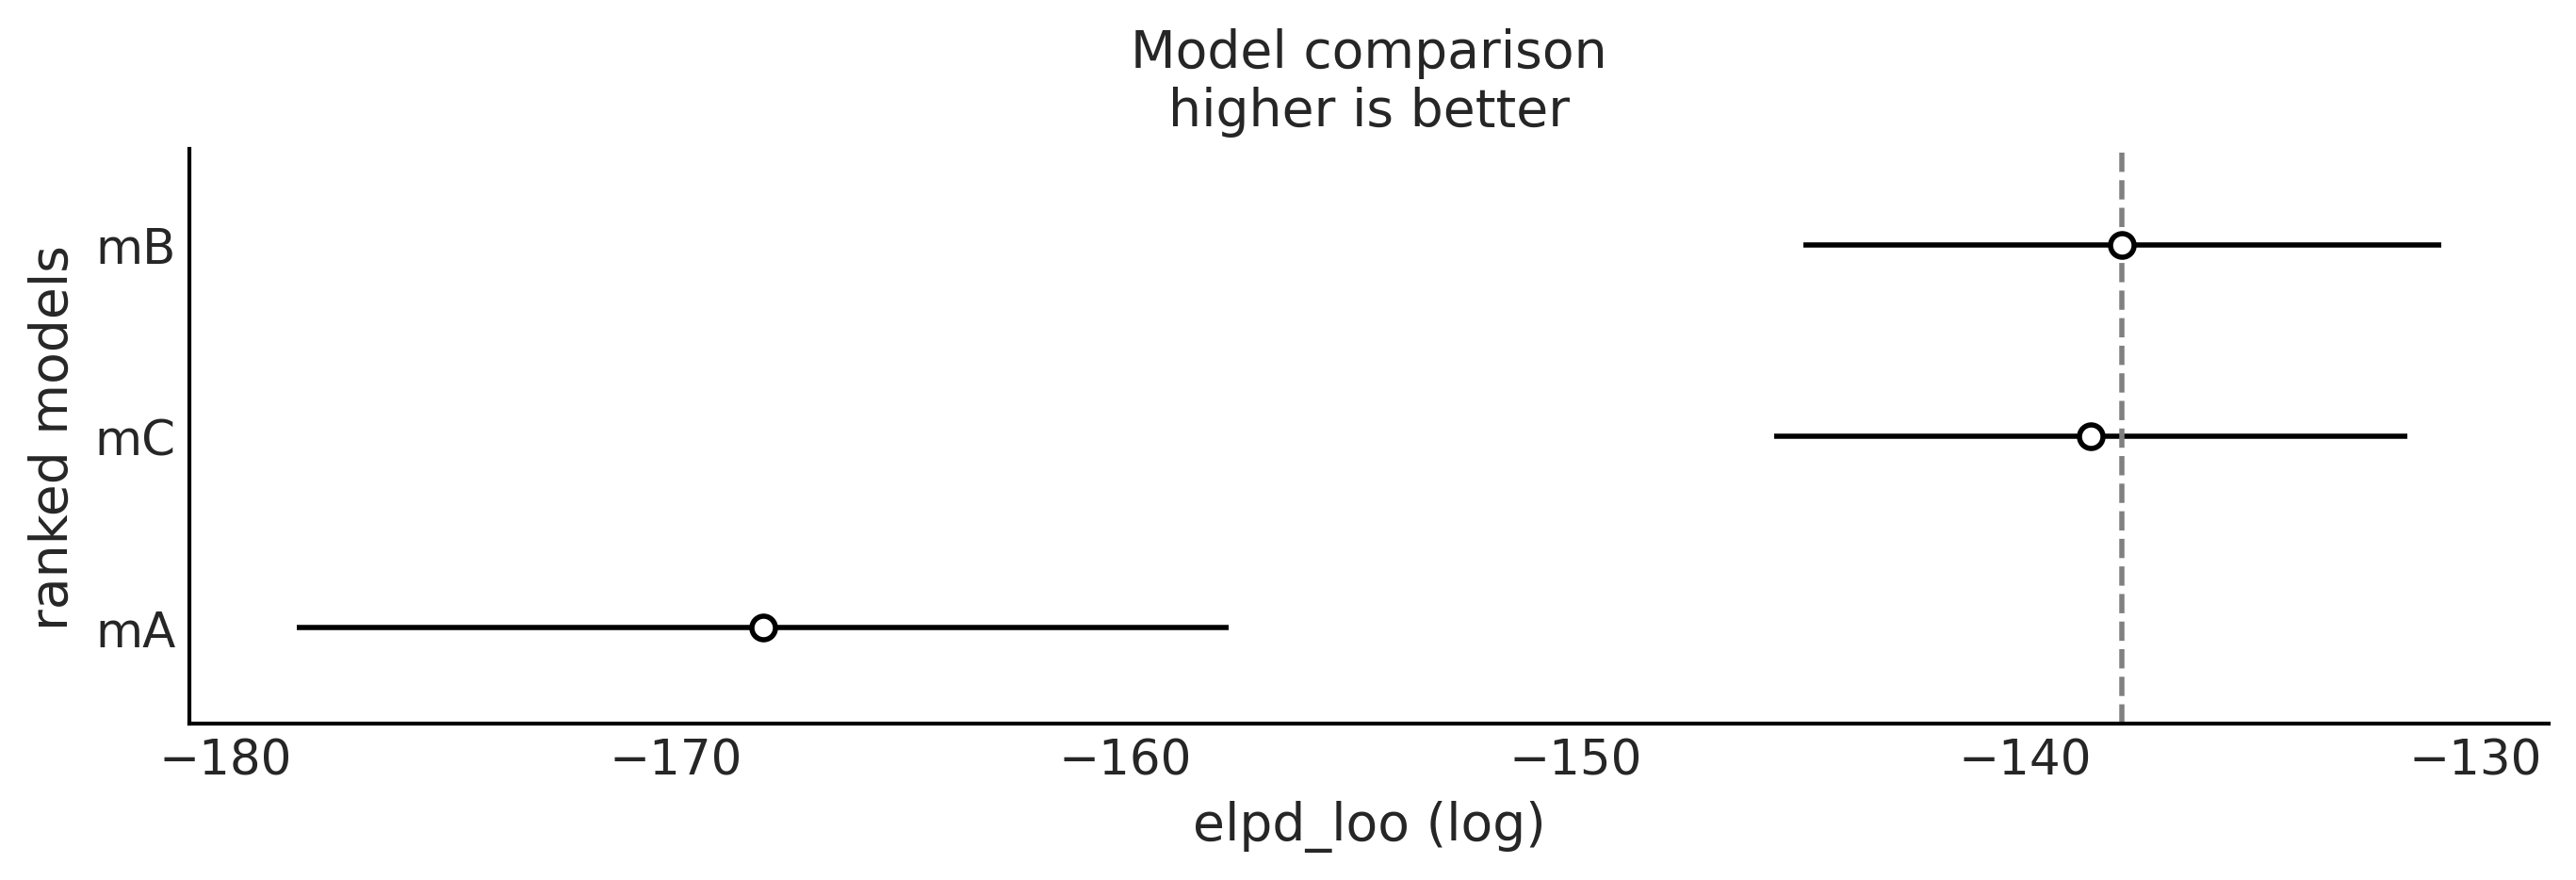

In [30]:
az.plot_compare(cmp, figsize=(9, 3))
plt.savefig("img/chp02/compare_dummy.png")

### 2.5.2 Expected Log Predictive Density

In the previous section we computed a value of the ELPD for each model.
Since this is a *global* comparison it reduces a model, and data, to a
single number. But from Equation {eq}`eq:elpd_practice` and
{eq}`eq:elpd_loo_cv` we can see that LOO is computed as a sum of
point-wise values, one for each observation. Thus we can also perform
*local* comparisons. We can think of the individual values of the ELPD
as an indicator of how difficult it is for the model to predict a
particular observation.

To compare models based on the per-observation ELPD, ArviZ offers the
`az.plot_elpd(.)` function. {numref}`fig:elpd_dummy` shows the
comparison between models `mA`, `mB` and `mC` in a pairwise fashion.
Positive values indicate that observations are better resolved by the
first model than by the second. For example, if we observed the first
plot (`mA- mB`), observation 49 and 72 are better resolved by model `mA`
than model `mB`, and the opposite happens for observations 75 and 95. We
can see that the first two plots `mA- mB` and `mA- mC` are very similar,
the reason is that model `mB` and model `mC` are in fact very similar to
each other. {numref}`fig:elpd_and_khat` shows that observations 34, 49,
72, 75 and 82 are in fact the five most *extreme* observations.

```{figure} figures/elpd_dummy.png
:name: fig:elpd_dummy
:width: 8.00in
Pointwise ELPD differences. Annotated points correspond to observations
with an ELPD difference 2 times the standard deviation of the computed
ELPD differences. Differences are small in all 3 examples, especially
between `mB` and `mC`. Positive values indicate that observations are
better resolved for the first model than the second.
```

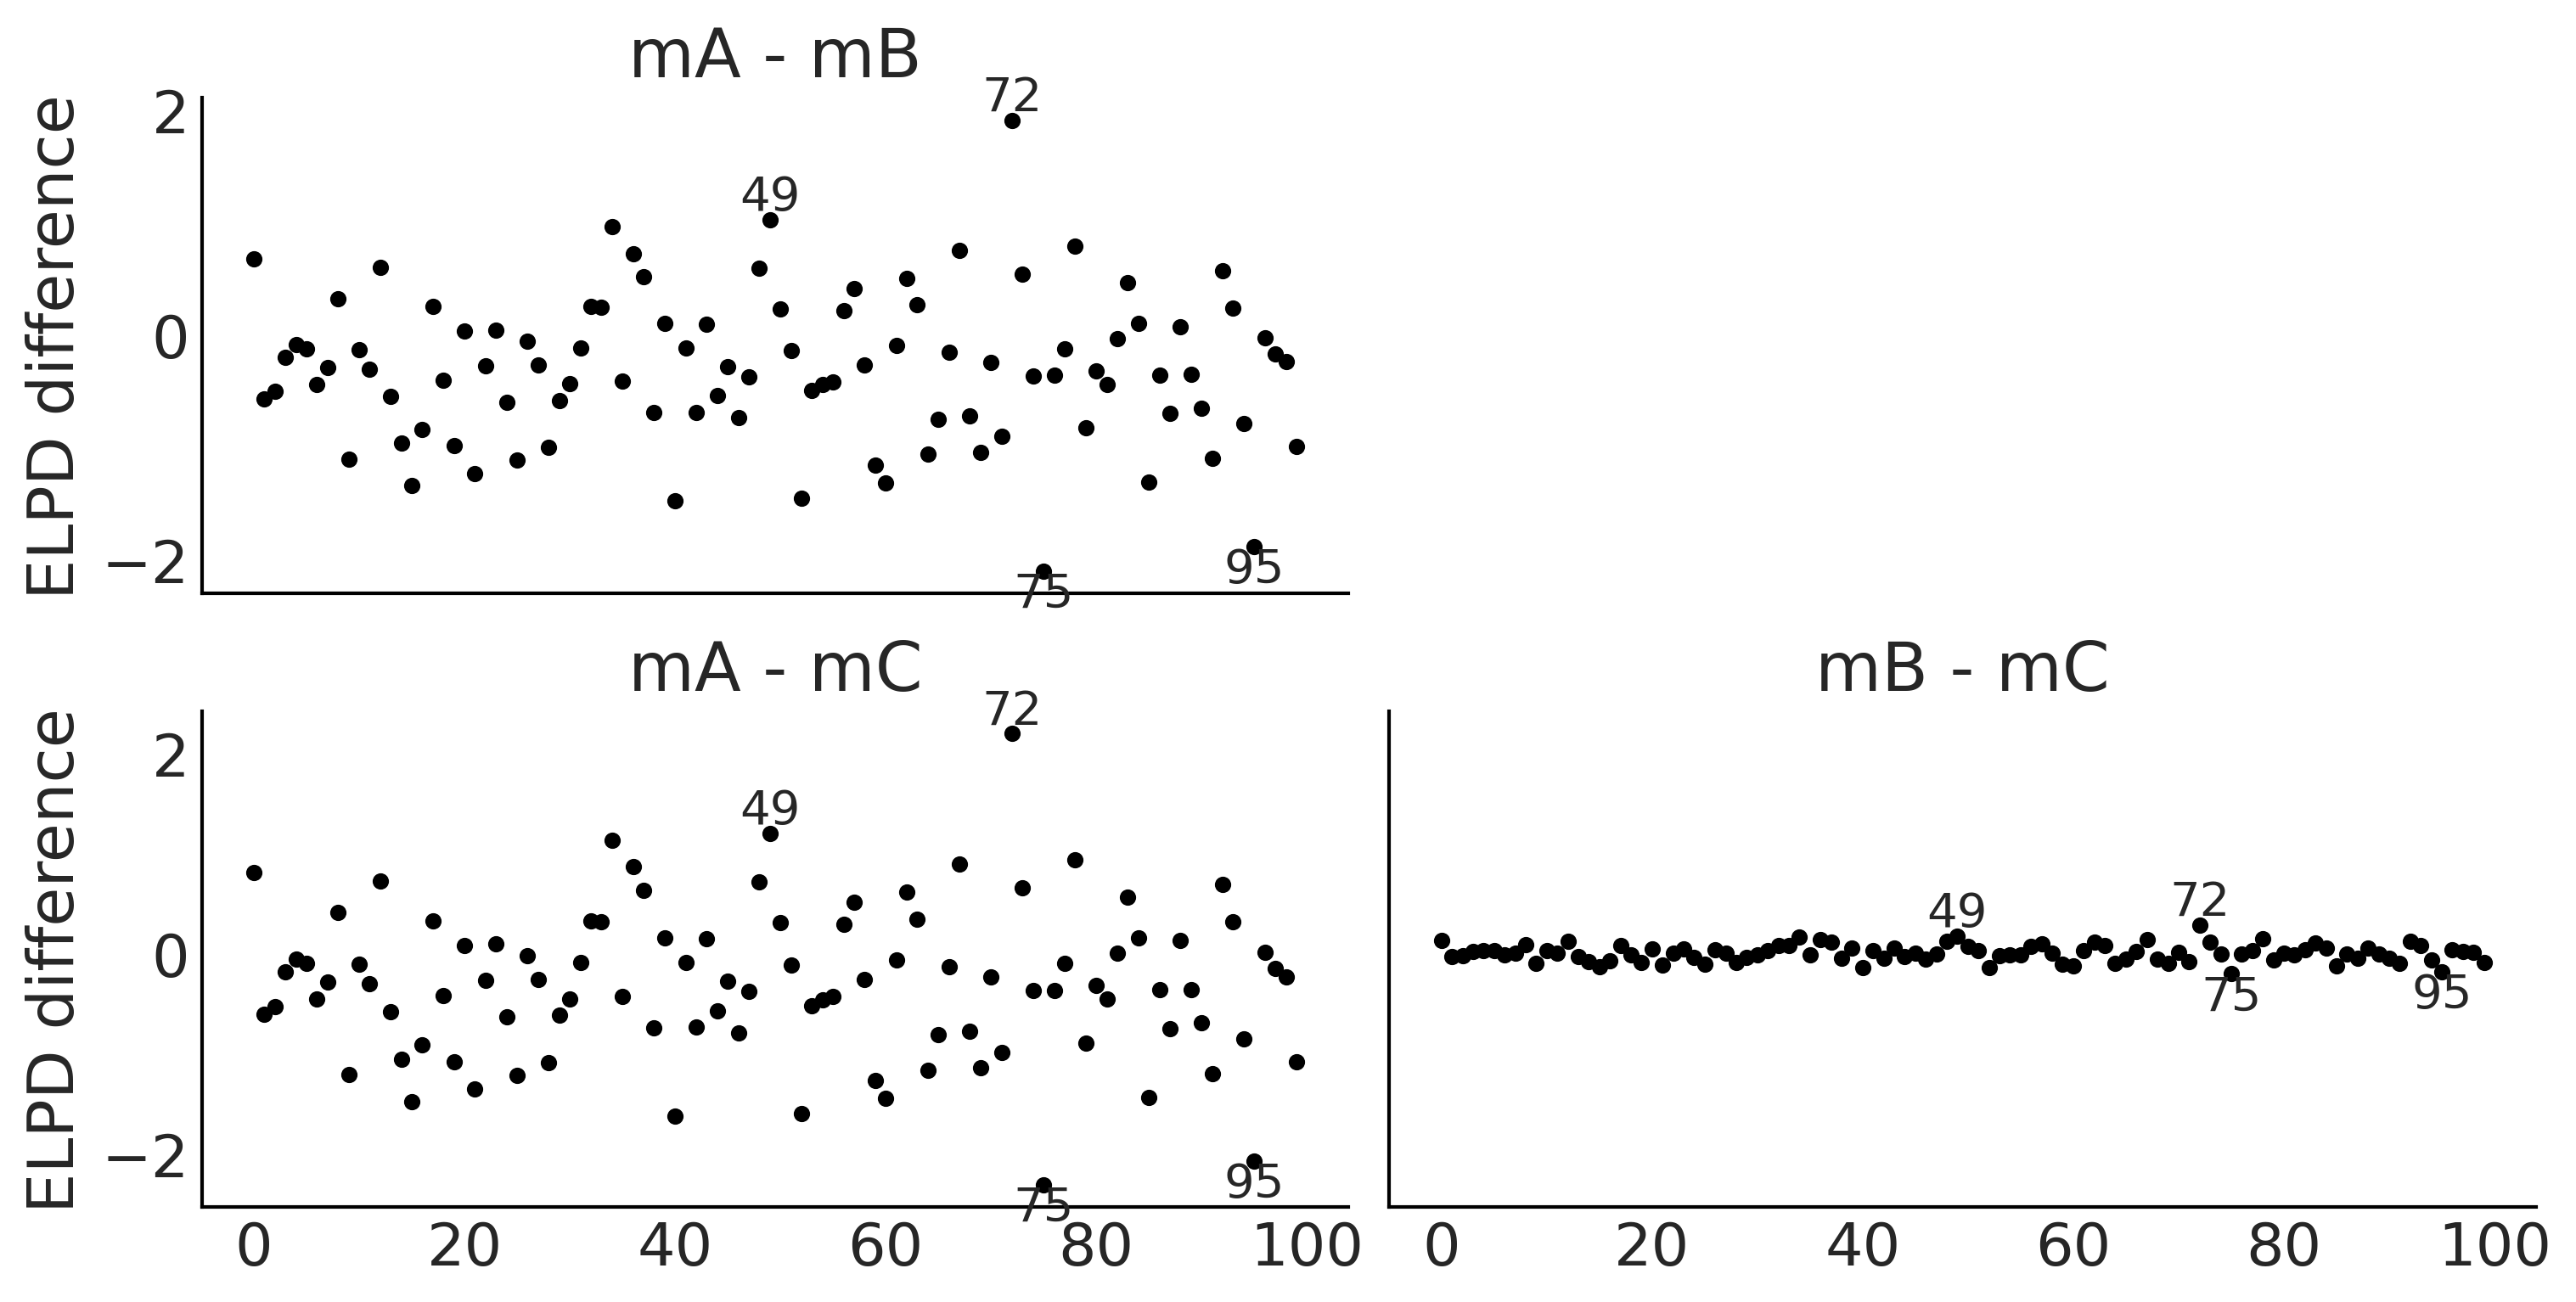

In [31]:
az.plot_elpd(idatas_cmp, figsize=(10, 5), plot_kwargs={"marker":"."}, threshold=2);
plt.savefig("img/chp02/elpd_dummy.png")

(k-paretto)=

### 2.5.3 Pareto Shape Parameter

As we already mentioned we use LOO to approximate
$\text{ELPD}_\text{LOO-CV}$. This approximation involves the computation
of a Pareto distribution (see details in Section {ref}`loo_depth`),
the main purpose is to obtain a more robust estimation, the side-effect
of this computation is that the $\hat \kappa$ parameter of such Pareto
distribution can be used to detect highly influential observations, i.e.
observations that have a large effect on the predictive distribution
when they are left out. In general, higher values of $\hat \kappa$ can
indicate problems with the data or model, especially when
$\hat \kappa > 0.7$ {cite:p}`vehtari_pareto_2019, gabry_visualization_2017`.
When this is the case the recommendations are {cite:p}`loo_glossary`:

-   Use the matching moment method {cite:p}`Paananen2020` [^17]. With some
    additional computations, it is possible to transform the MCMC draws
    from the posterior distribution to obtain more reliable importance
    sampling estimates.

-   Perform exact leave-one-out cross validation for the problematic
    observations or use k-fold cross-validation.

-   Use a model that is more robust to anomalous observations.

When we get at least one value of $\hat \kappa > 0.7$ we will get a
warning when calling `az.loo(.)` or `az.compare(.)`. The `warning`
column in {numref}`table:compare_00`  has only `False` values because
all the computed values of $\hat \kappa$ are $< 0.7$ which we can check
by ourselves from {numref}`fig:loo_k_dummy`. We have annotated the
observations with $\hat \kappa > 0.09$ values in
{numref}`fig:loo_k_dummy`, $0.09$ is just an arbitrary number we picked,
you can try with other cutoff value if you want. Comparing
{numref}`fig:elpd_dummy` against {numref}`fig:loo_k_dummy` we can see
that the highest values of $\hat \kappa$ are not necessarily the ones
with the highest values of ELPD or vice versa.

```{figure} figures/loo_k_dummy.png
:name: fig:loo_k_dummy
:width: 8.00in
$\hat \kappa$ values. Annotated points correspond to observations with
$\hat \kappa > 0.09$, a totally arbitrary threshold.
```

```{figure} figures/elpd_and_khat.png
:name: fig:elpd_and_khat
:width: 4.5in
Kernel density estimate of the observations fitted with `mA`, `mB` and
`mC`. The black lines represent the values of each observation. The
annotated observations are the same one highlighted in
{numref}`fig:elpd_dummy` except for the observation 78, annotated in
boldface, which is only highlighted in {numref}`fig:loo_k_dummy`.
```

[^17]: At time of writing this book the method has not been yet
    implemented in ArviZ, but it may be already available by the time
    you are reading this.

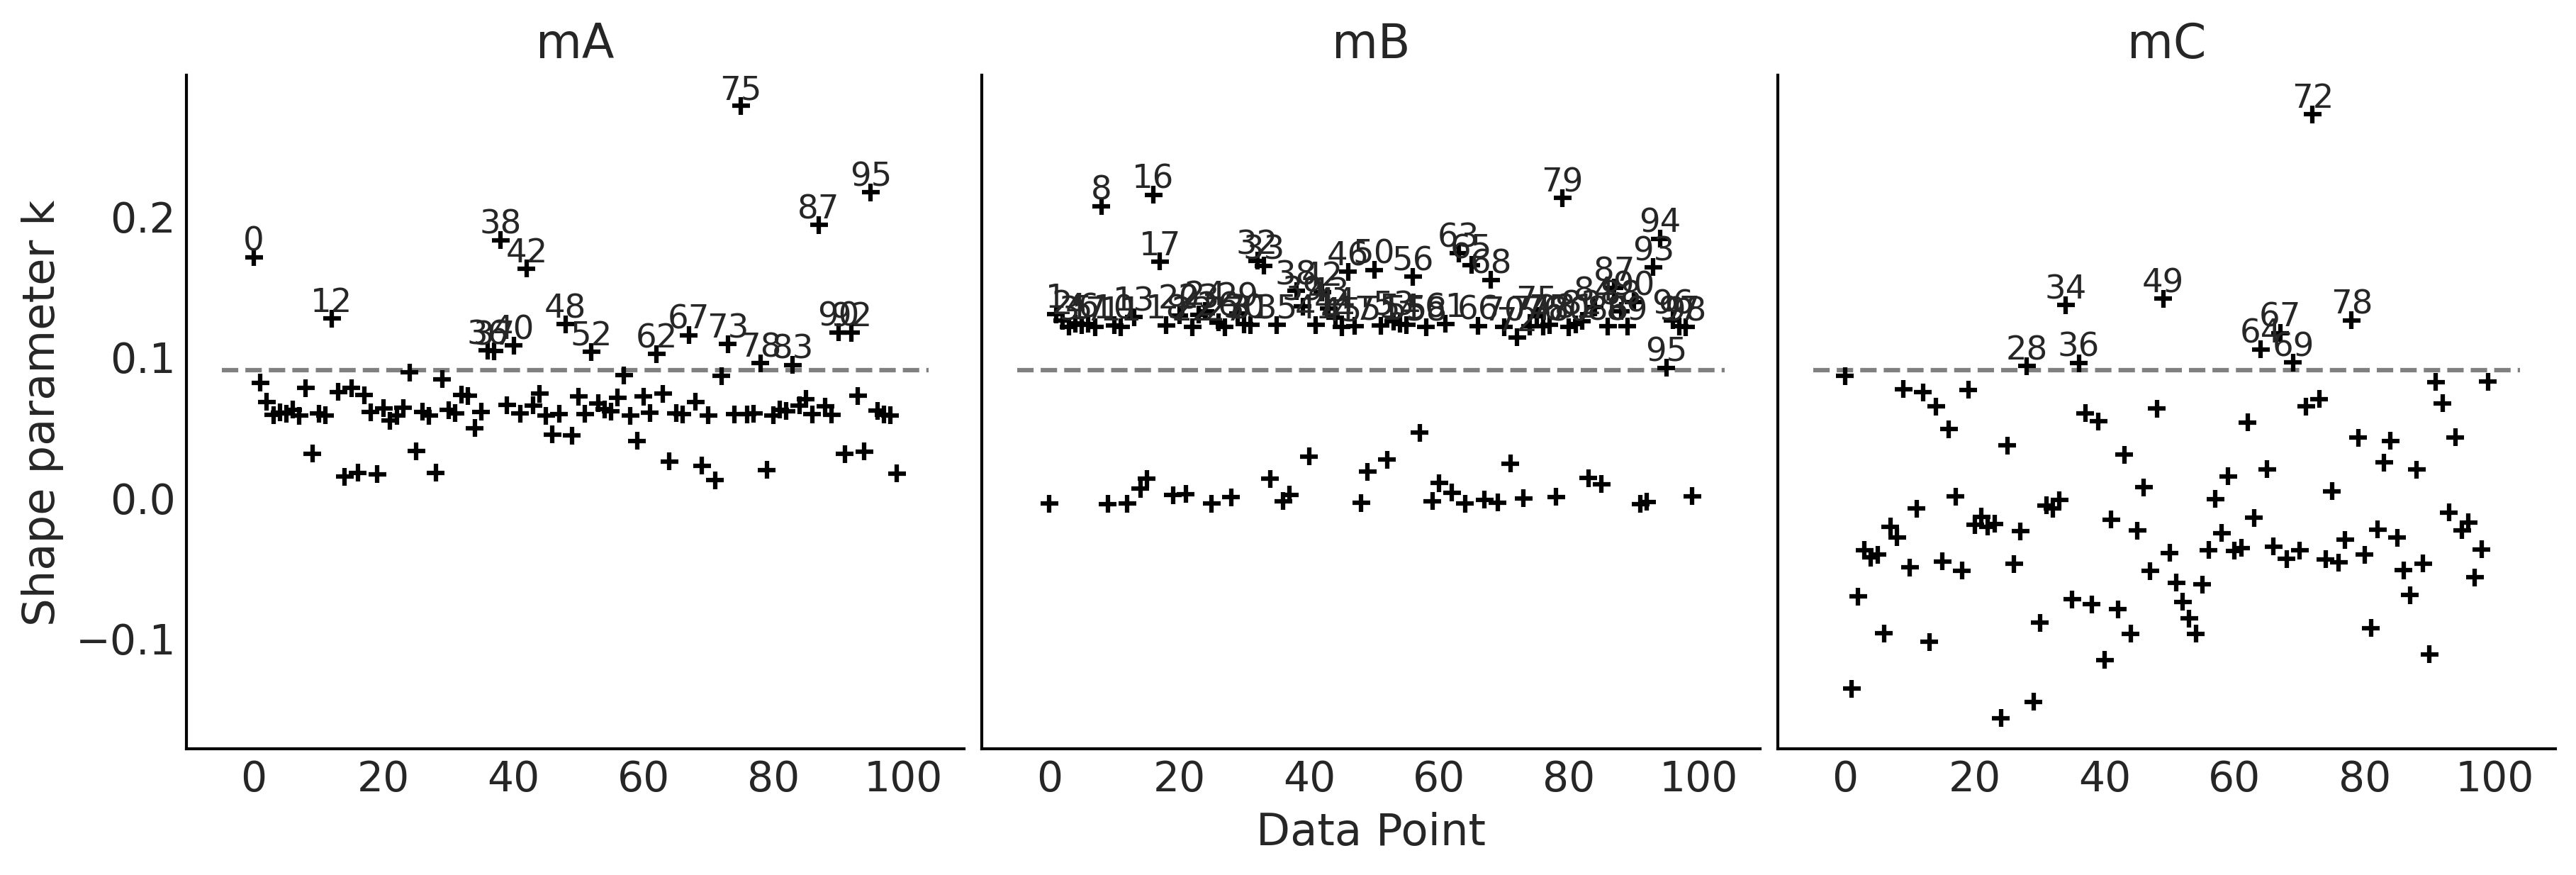

In [32]:
_, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
for idx, (model, ax) in enumerate(zip(("mA", "mB", "mC"), axes)):
    loo_ = az.loo(idatas_cmp[model], pointwise=True)
    az.plot_khat(loo_, ax=ax, threshold=0.09, show_hlines=True, hlines_kwargs={"hlines":0.09, "ls":"--"})
    ax.set_title(model)
    if idx:
        axes[idx].set_ylabel("")
    if not idx % 2:
        axes[idx].set_xlabel("")

plt.savefig("img/chp02/loo_k_dummy.png")

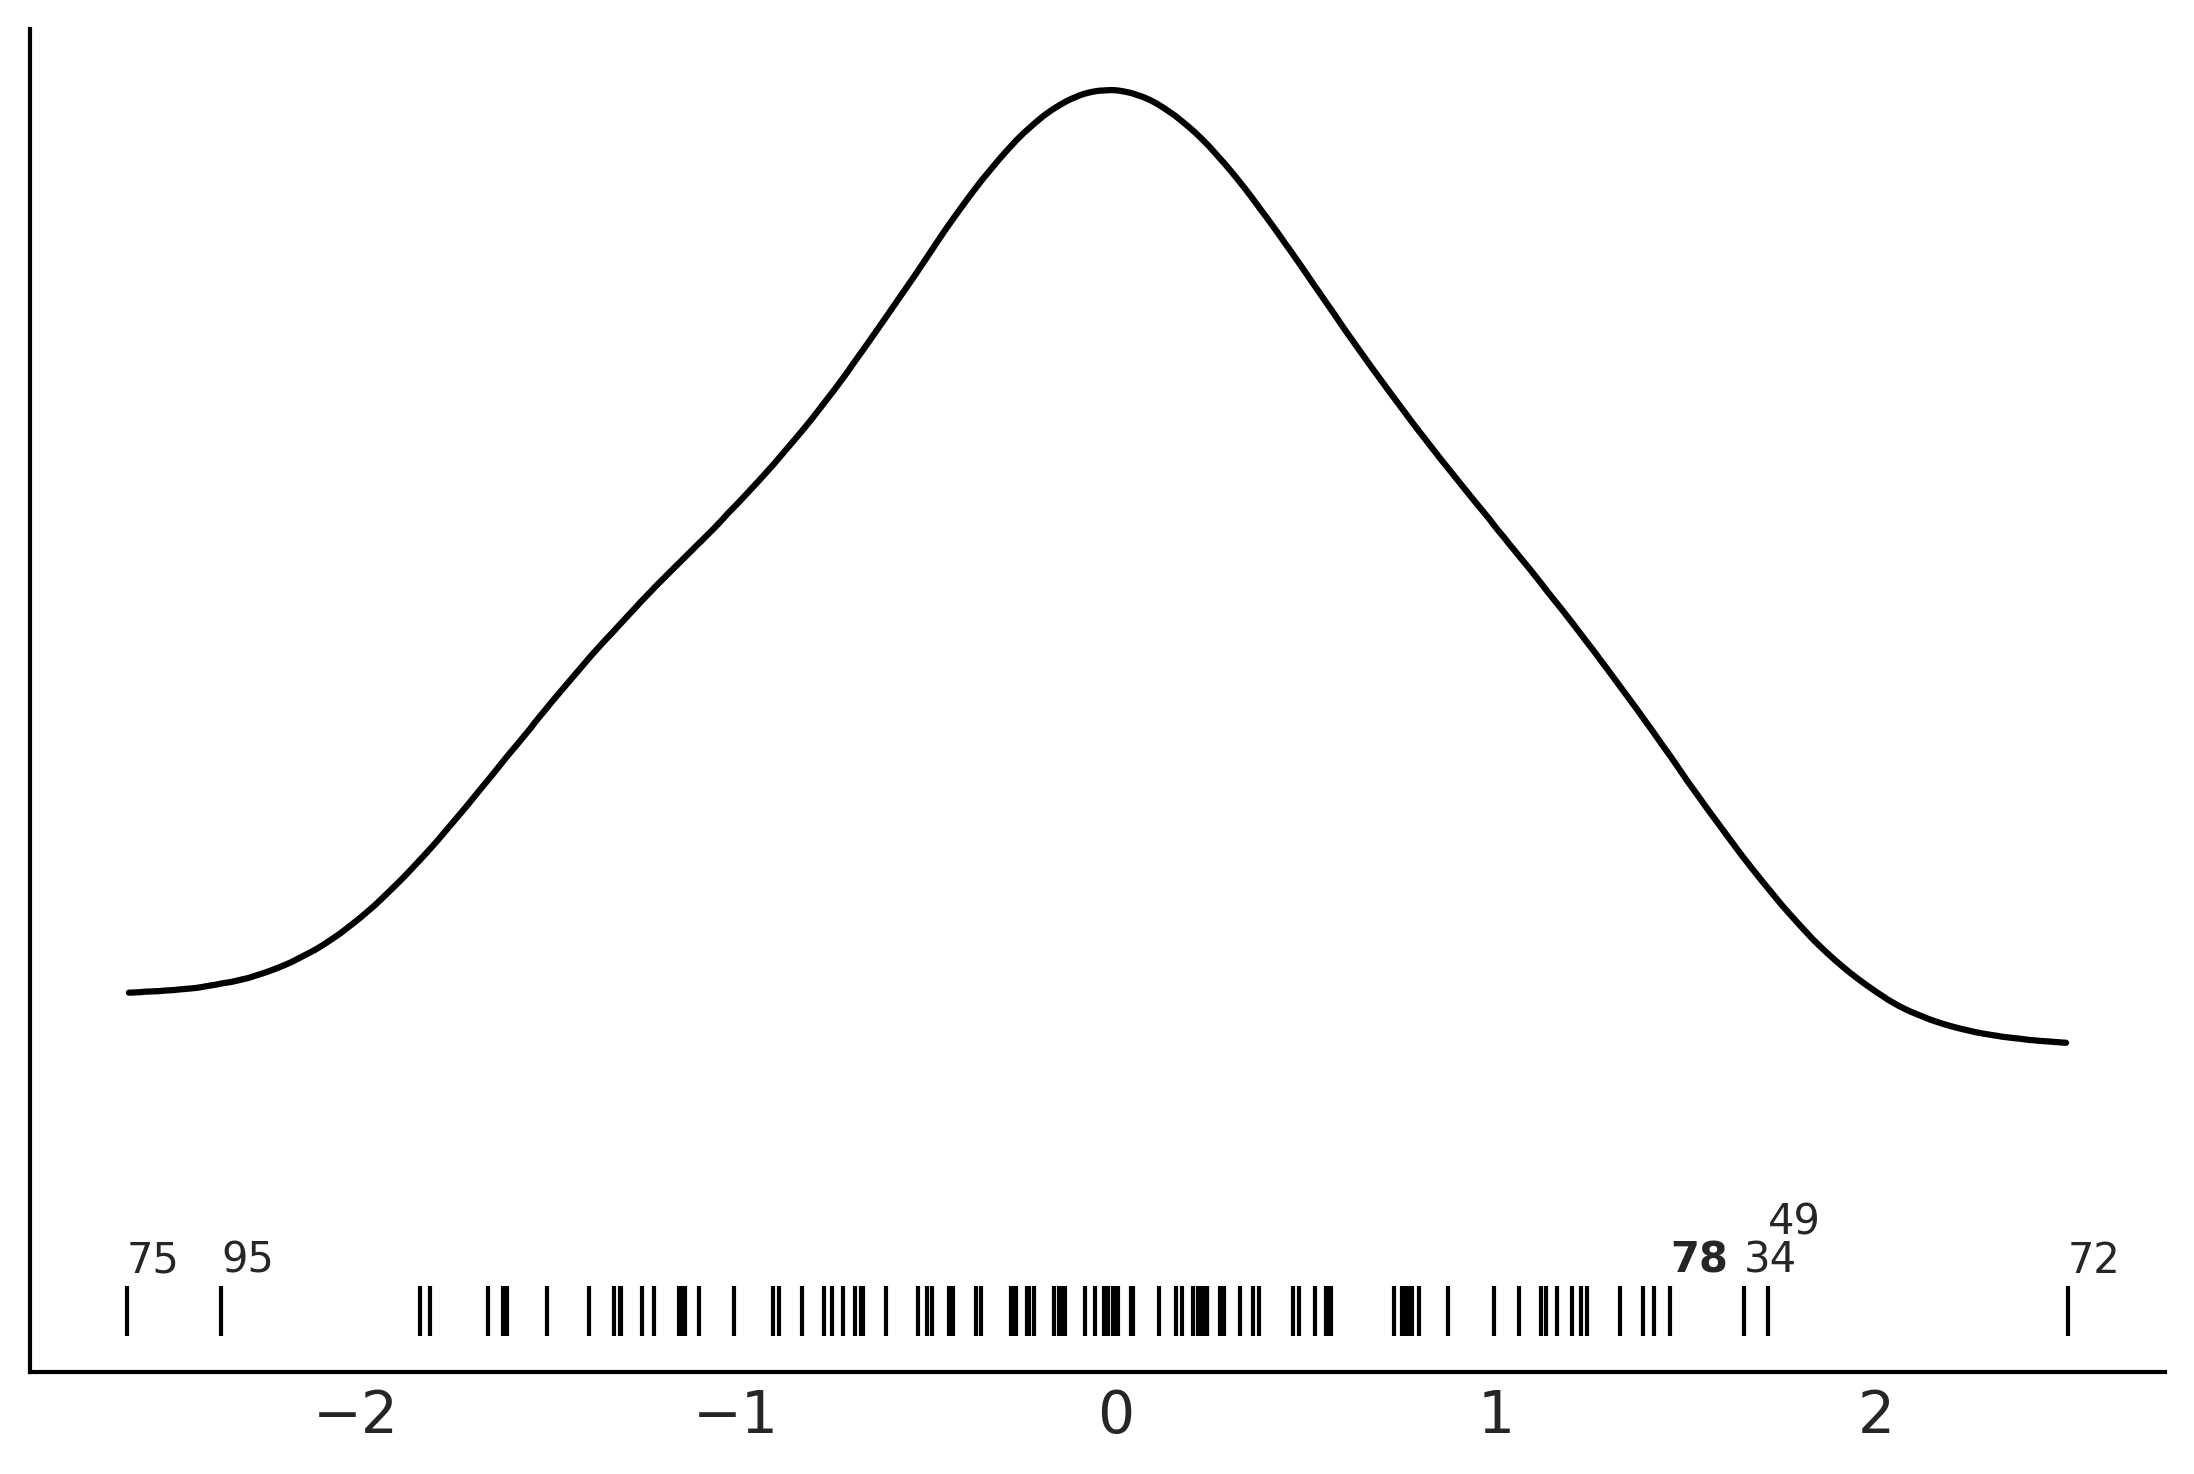

In [33]:
az.plot_kde(y_obs, rug=True)
plt.yticks([])
for da, loc in zip([34, 49, 72, 75, 95], [-0.065, -0.05, -0.065, -0.065, -0.065]):
    plt.text(y_obs[da], loc, f"{da}")

plt.text(y_obs[78], loc, "78", fontweight='bold');
plt.savefig("img/chp02/elpd_and_khat.png")

(interpreting-p_loo-when-pareto-hat-kappa-is-large)=

### 2.5.4 Interpreting p_loo When Pareto $\hat \kappa$ is Large

As previously said p_loo can be loosely interpreted as the estimated
effective number of parameters in a model. Nevertheless, for models with
large values of $\hat \kappa$ we can obtain some additional
information. If $\hat \kappa > 0.7$ then comparing p_loo to the number
of parameters $p$ can provide us with some additional information
{cite:p}`loo_glossary`:

-   If $p\_loo << p$, then the model is likely to be misspecified. You
    usually also see problems in the posterior predictive checks that
    the posterior predictive samples match the observations poorly.

-   If $p\_loo < p$ and $p$ is relatively large compared to the number
    of observations (e.g., $p > \frac{N}{5}$, where $N$ is the total
    number of observations), it is usually an indication that the model
    is too flexible or the priors are too uninformative. Thus it becomes
    difficult to predict the left out observation.

-   If $p\_loo > p$, then the model is also likely to be badly
    misspecified. If the number of parameters is $p << N$, then
    posterior predictive checks are also likely to already reveal some
    problem [^18]. However, if $p$ is relatively large compared to the
    number of observations, say $p > \frac{N}{5}$, it is possible you do
    not see problems in the posterior predictive checks.

A few heuristics for fixing model misspecification you may try are:
adding more structure to the model, for example, adding nonlinear
components; using a different likelihood, for example, using an
overdispersed likelihood like a NegativeBinomial instead of a Poisson
distribution, or using mixture likelihood.

[^18]: See the case study
    <https://avehtari.github.io/modelselection/roaches.html> for an
    example.

(loo-pit)=

### 2.5.5 LOO-PIT

As we just saw in Sections {ref}`elpd_plots` and {ref}`k-paretto` model
comparison, and LOO in particular, can be used for purposes other than
declaring a model is *better* than another model. We can compare models
as a way to better understand them. As the complexity of a model
increases it becomes more difficult to understand it just by looking at
its mathematical definition or the code we use to implement it. Thus,
comparing models using LOO or other tools like posterior predictive
checks, can help us to better understand them.

One criticism of posterior predictive checks is that we are using the
data twice, once to fit the model and once to criticize it. The LOO-PIT
plot offers an answer to this concern. The main idea is that we can use
LOO as a fast and reliable approximation to cross-validation in order to
avoid using the data twice. The "PIT part\", stands for Probability
Integral Transform[^19], which is a transformation in 1D where we can get
a $\mathcal{U}(0, 1)$ distribution from any continuous random variable
if we transform that random variable using its own CDF (for details see Section
{ref}`loo_depth`). In LOO-PIT we do not know the true CDF, but
we approximate it with the empirical CDF. Putting aside these
mathematical details for a moment, the take-home-message is that for a
well calibrated model we should expect an approximately Uniform
distribution. If you are experiencing a Déjà vu, do not worry you do not
have extrasensory powers nor is this a glitch in the matrix. This may
sound familiar because this is in fact the very same idea we discussed
in {ref}`posterior_pd` with the function
`az.plot_bpv(idata, kind="u_value")`.

LOO-PIT is obtained by comparing the observed data $y$ to posterior
predicted data $\tilde y$. The comparison is done point-wise. We have:

```{math}
:label: loo_pit
p_i = P(\tilde y_i \leq y_i \mid y_{-i})
```

Intuitively, LOO-PIT is computing the probability that the posterior
predicted data $\tilde y_i$ has lower value than the observed data
$y_i$, when we remove the $i$ observation. Thus the difference between
`az.plot_bpv(idata, kind="u_value")` and LOO-PIT is that with the latter
we are approximately avoiding using the data twice, but the overall
interpretation of the plots is the same.

{numref}`fig:loo_pit_dummy` shows the LOO-PIT for models `mA`, `mB` and
`mC`. We can observe that from the perspective of model `mA` there is
more observed data than expected for low values and less data for high
values, i.e. the model is biased. On the contrary, models `mB` and `mC`
seem to be very well calibrated.

```{figure} figures/loo_pit_dummy.png
:name: fig:loo_pit_dummy
:width: 8.00in
The black lines are a KDE of LOO-PIT, i.e. the proportion of predicted
values that are less or equal than the observed data, computed per each
observation. The white lines represent the expected Uniform distribution
and the gray band the expected deviation for a dataset of the same size
as the one used.
```

[^19]: A deeper give into Probability Integral Transform can be found in Section
      {ref}`probability-integral-transform-pit`.

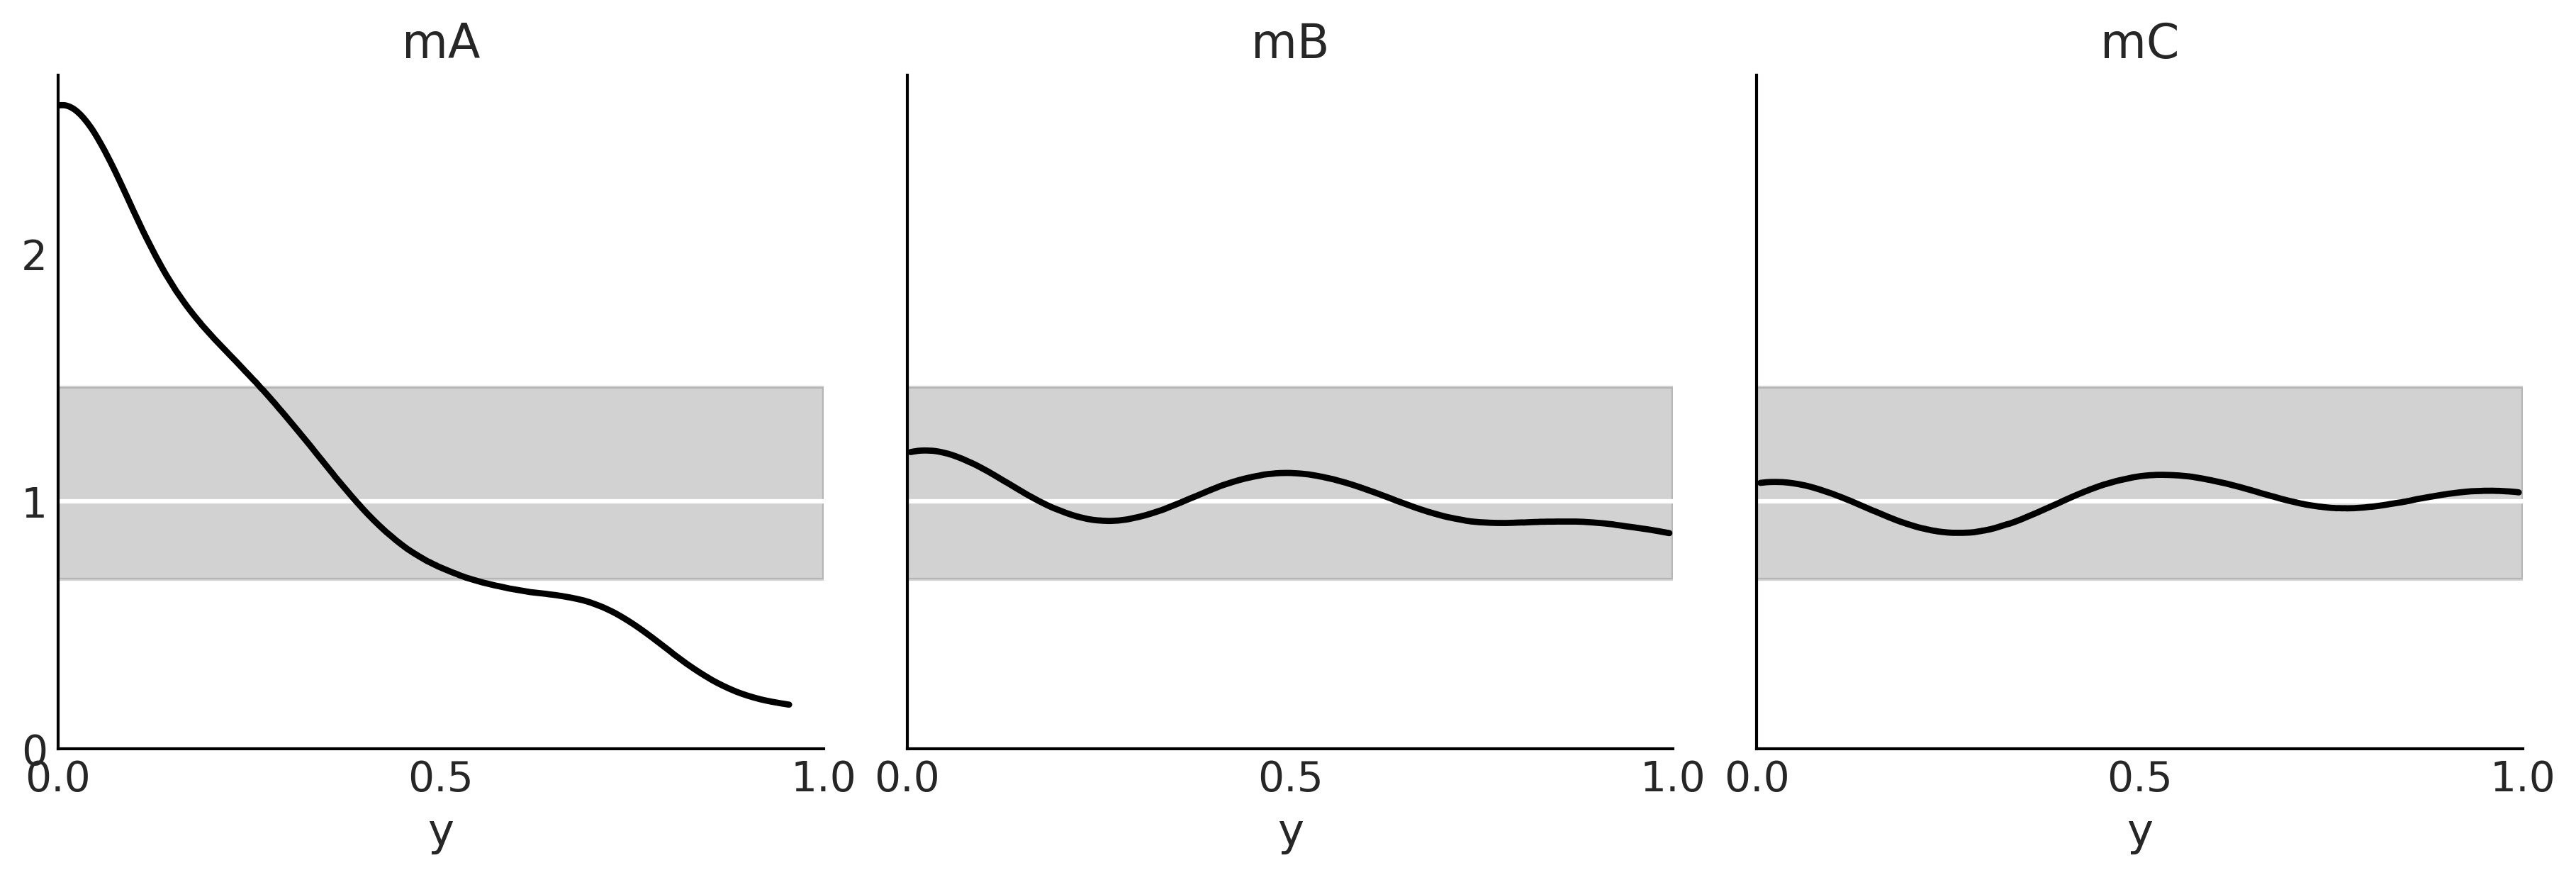

In [34]:
_, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
for model, ax in zip(("mA", "mB", "mC"), axes):
    az.plot_loo_pit(idatas_cmp[model], y="y", legend=False, use_hdi=True, ax=ax)
    ax.set_title(model)
    ax.set_xticks([0, 0.5, 1])
    ax.set_yticks([0, 1, 2])

plt.savefig("img/chp02/loo_pit_dummy.png")

(model_averaging)=

### 2.5.6 Model Averaging

Model averaging can be justified as being Bayesian about model
uncertainty as we are Bayesian about parameter uncertainty. If we can
not absolutely be sure that *a* model is *the* model (and generally we
can not), then we should somehow take that uncertainty into account for
our analysis. One way of taking into account model uncertainty is by
performing a weighted average of all the considered models, giving more
weight to the models that seem to explain or predict the data better.

A *natural* way to weight Bayesian models is by their marginal
likelihoods, this is known as Bayesian Model Averaging
{cite:p}`hoeting_bayesian_1999`. While this is theoretically appealing, it is
problematic in practice (see Section {ref}`marginal_likelihood`) for details). An
alternative is to use the values of LOO to estimate weights for each
model. We can do this by using the following formula:

```{math}
:label: eq_pseudo_avg
w_i = \frac {e^{-\Delta_i }} {\sum_j^k e^{-\Delta_j }}

```

where $\Delta_i$ is the difference between the $i$ value of LOO and the
highest one, assuming we are using the log- scale, which is the default
in ArviZ.

This approach is called pseudo Bayesian model averaging, or Akaike-like
[^20] weighting and is an heuristic way to compute the relative
probability of each model (given a fixed set of models) from LOO[^21].
See how the denominator is just a normalization term ensuring that the
weights sum up to one. The solution offered by Equation
{eq}`eq_pseudo_avg` for computing weights is a very nice and simple
approach. One major caveat is that it does not take into account the
uncertainty in the computation of the values of LOO. We could compute
the standard error assuming a Gaussian approximation and modify Equation
{eq}`eq_pseudo_avg` accordingly. Or we can do something more robust,
like using Bayesian Bootstrapping.

Yet another option for model averaging is stacking of predictive
distributions {cite:p}`yao_stacking_2018`. The main idea is to combine several
models in a meta-model in such a way that we minimize the divergence
between the meta-model and the *true* generating model. When using a
logarithmic scoring rule this is equivalent to computing:

```{math}
:label: eq_stacking
\max_{w} \frac{1}{n} \sum_{i=1}^{n}log\sum_{j=1}^{k} w_j p(y_i \mid y_{-i}, M_j)

```

where $n$ is the number of data points and $k$ the number of models. To
enforce a solution we constrain $w$ to be $w_j \ge 0$ and
$\sum_{j=1}^{k} w_j = 1$. The quantity $p(y_i \mid y_{-i}, M_j)$ is the
leave-one-out predictive distribution for the $M_j$ model. As we already
said computing it can bee too costly and thus in practice we can use LOO
to approximate it.

Stacking has more interesting properties than pseudo Bayesian model
averaging. We can see this from their definitions, Equation
{eq}`eq_pseudo_avg` is just a normalization of weights that have been
computed for each model independently of the rest of the models. Instead
in Equation {eq}`eq_stacking` the weights are computed by maximizing the
combined log-score, i.e. even when the models have been fitted
independently as in pseudo Bayesian model averaging, the computation of
the weights takes into account all models together. This helps to explain
why model `mB` gets a weight of 1 and `mC` a weight of 0 (see
{numref}`table:compare_00` ), even if they are very similar models. Why are
the weights not around 0.5 for each one of them? The reason is that
according to the stacking procedure once `mB` is included in our set of
compared models, `mC` does not provide new information. In other words
including it will be redundant.

The function `pm.sample_posterior_predictive_w(.)` accepts a list of
traces and a list of weights allowing us to easily generate weighted
posterior predictive samples. The weights can be taken from anywhere,
but using the weights computed with `az.compare(., method="stacking")`
makes a lot of sense.

[^20]: The Akaike information criterion (AIC) is an estimator of the
    generalization error, it is commonly used in frequentists
    statistics, but their assumptions are generally not adequate enough
    for general use with Bayesians models.

[^21]: This formula also works for WAIC [^22] and other information
    criteria

(exercises2)=

## 2.6 Exercises

**2E1.** Using your own words, what are the main
differences between prior predictive checks and posterior predictive
checks? How are these empirical evaluations related to Equations
[eq:prior_pred_dist](eq:prior_pred_dist) and
[eq:post_pred_dist](eq:post_pred_dist).

**2E2.** Using your own words explain: ESS, $\hat R$ and
MCSE. Focus your explanation on what these quantities are measuring and
what potential issue with MCMC they are identifying.

**2E3.** ArviZ includes precomputed InferenceData objects
for a few models. We are going to load an InferenceData object generated
from a classical example in Bayesian statistic, the eight schools model
{cite:p}`rubin_1981`. The InferenceData object includes prior samples, prior
predictive samples and posterior samples. We can load the InferenceData
object using the command `az.load_arviz_data("centered_eight")`. Use
ArviZ to:

1.  List all the groups available on the InferenceData object.

2.  Identify the number of chains and the total number of posterior
    samples.

3.  Plot the posterior.

4.  Plot the posterior predictive distribution.

5.  Calculate the estimated mean of the parameters, and the Highest
    Density Intervals.

If necessary check the ArviZ documentation to help you do these tasks
<https://arviz-devs.github.io/arviz/>

**2E4.** Load `az.load_arviz_data("non_centered_eight")`,
which is a reparametrized version of the "centered_eight\" model in the
previous exercise. Use ArviZ to assess the MCMC sampling convergence for
both models by using:

1.  Autocorrelation plots

2.  Rank plots.

3.  $\hat R$ values.

Focus on the plots for the mu and tau parameters. What do these three
different diagnostics show? Compare these to the InferenceData results
loaded from `az.load_arviz_data("centered_eight")`. Do all three
diagnostics tend to agree on which model is preferred? Which one of the
models has better convergence diagnostics?

**2E5.** InferenceData object can store statistics related
to the sampling algorithm. You will find them in the `sample_stats`
group, including divergences (`diverging`):

1.  Count the number of divergences for "centered_eight\" and
    "non_centered_eight\" models.

2.  Use `az.plot_parallel` to identify where the divergences tend to
    concentrate in the parameter space.

**2E6.** In the GitHub repository we have included an
InferenceData object with a Poisson model and one with a
NegativeBinomial, both models are fitted to the same dataset. Use
`az.from_netcdf(.)` to load them, and then use ArviZ functions to
answer the following questions:

1.  Which model provides a better fit to the data? Use the functions
    `az.compare(.)` and `az.plot_compare(.)`

2.  Explain why one model provides a better fit than the other. Use
    `az.plot_ppc(.)` and `az.plot_loo_pit(.)`

3.  Compare both models in terms of their pointwise ELPD values.
    Identify the 5 observations with the largest (absolute) difference.
    Which model is predicting them better? For which model p_loo is
    closer to the actual number of parameters? Could you explain why?
    Hint: the Poisson model has a single parameter that controls both
    the variance and mean. Instead, the NegativeBinomial has two
    parameters.

4.  Diagnose LOO using the $\hat \kappa$ values. Is there any reason to
    be concerned about the accuracy of LOO for this particular case?

**2E7.** Reproduce
{numref}`fig:posterior_predictive_many_examples`, but using
`az.plot_loo_pit(ecdf=True)` in place of `az.plot_bpv(.)`. Interpret the
results. Hint: when using the option `ecdf=True`, instead of the LOO-PIT
KDE you will get a plot of the difference between the LOO-PIT Empirical
Cumulative Distribution Function (ECDF) and the Uniform CDF. The ideal
plot will be one with a difference of zero.

**2E8.** In your own words explain why MCMC posterior
estimation techniques need convergence diagnostics. In particular
contrast these to the conjugate methods described in Section
{ref}`conjugate_priors` which do not need those
diagnostics. What is different about the two inference methods?

**2E9.** Visit the ArviZ plot gallery at
<https://arviz-devs.github.io/arviz/examples/index.html>. What diagnoses
can you find there that are not covered in this chapter? From the
documentation what is this diagnostic assessing?

**2E10.** List some plots and numerical quantities that
are useful at each step during the Bayesian workflow (shown visually in
{numref}`fig:BayesianWorkflow`). Explain how they work
and what they are assessing. Feel free to use anything you have seen in
this chapter or in the ArviZ documentation.

1.  Prior selection.

2.  MCMC sampling.

3.  Posterior predictions.

**2M11.** We want to model a football league with $N$
teams. As usual, we start with a simpler version of the model in mind,
just a single team. We assume the scores are Poisson distributed
according to a scoring rate $\mu$. We choose the prior
$\text{Gamma}(0.5, 0.00001)$ because this is sometimes recommend as an
"objective\" prior.

```{code-block} python
:name: poisson_football
:caption: poisson_football
with pm.Model() as model:
    μ = pm.Gamma("μ", 0.5, 0.00001)
    score = pm.Poisson("score", μ)
    trace = pm.sample_prior_predictive()
```

1.  Generate and plot the prior predictive distribution. How reasonable
    it looks to you?

2.  Use your knowledge of sports in order to refine the prior choice.

3.  Instead of soccer you now want to model basketball. Could you come
    with a reasonable prior for that instance? Define the prior in a
    model and generate a prior predictive distribution to validate your
    intuition.

    Hint: You can parameterize the Gamma distribution using the rate and
    shape parameters as in Code Block
    [poisson_football](poisson_football) or alternatively
    using the mean and standard deviation.


**2M12.** In Code Block [metropolis_hastings](metropolis_hastings) from
Chapter [1](chap1), change the value of `can_sd` and run the
Metropolis sampler. Try values like 0.2 and 1.

1.  Use ArviZ to compare the sampled values using diagnostics such as
    the autocorrelation plot, trace plot and the ESS. Explain the
    observed differences.

2.  Modify Code Block [metropolis_hastings](metropolis_hastings) so you get more than one
    independent chain. Use ArviZ to compute rank plots and $\hat R$.

**2M13.** Generate a random sample using
`np.random.binomial(n=1, p=0.5, size=200)` and fit it using a
Beta-Binomial model.

Use `pm.sample(., step=pm.Metropolis())` (Metropolis-Hastings sampler)
and `pm.sample(.)` (the standard sampler). Compare the results in terms
of the ESS, $\hat R$, autocorrelation, trace plots and rank plots.
Reading the PyMC3 logging statements what sampler is autoassigned? What
is your conclusion about this sampler performance compared to
Metropolis-Hastings?

**2M14.** Generate your own example of a synthetic
posterior with convergence issues, let us call it `bad_chains3`.

1.  Explain why the synthetic posterior you generated is "bad\". What
    about it would we not want to see in an actual modeling scenario?

2.  Run the same diagnostics we run in the book for `bad_chains0` and
    `bad_chains1`. Compare your results with those in the book and
    explain the differences and similarities.

3.  Did the results of the diagnostics from the previous point made you
    reconsider why `bad_chains3` is a "bad chain\"?

**2H15.** Generate a random sample using
`np.random.binomial(n=1, p=0.5, size=200)` and fit it using a
Beta-Binomial model.

1.  Check that LOO-PIT is approximately Uniform.

2.  Tweak the prior to make the model a bad fit and get a LOO-PIT that
    is low for values closer to zero and high for values closer to one.
    Justify your prior choice.

3.  Tweak the prior to make the model a bad fit and get a LOO-PIT that
    is high for values closer to zero and low for values closer to one.
    Justify your prior choice.

4.  Tweak the prior to make the model a bad fit and get a LOO-PIT that
    is high for values close to 0.5 and low for values closer to zero
    and one. Could you do it? Explain why.

**2H16.** Use PyMC3 to write a model with Normal
likelihood. Use the following random samples as data and the following
priors for the mean. Fix the standard deviation parameter in the
likelihood at 1.

1.  A random sample of size 200 from a $\mathcal{N}(0,1)$ and prior
    distribution $\mathcal{N}(0,20)$

2.  A random sample of size 2 from a $\mathcal{N}(0,1)$ and prior
    distribution $\mathcal{N}(0,20)$

3.  A random sample of size 200 from a $\mathcal{N}(0,1)$ and prior
    distribution $\mathcal{N}(20, 1)$

4.  A random sample of size 200 from a $\mathcal{U}(0,1)$ and prior
    distribution $\mathcal{N}(10, 20)$

5.  A random sample of size 200 from a $\mathcal{HN}(0,1)$ and a prior
    distribution $\mathcal{N}(10,20)$

Assess convergence by running the same diagnostics we run in the book
for `bad_chains0` and `bad_chains1`. Compare your results with those in
the book and explain the differences and similarities.

**2H17.** Each of the four sections in this chapter, prior
predictive checks, posterior predictive checks, numerical inference
diagnostics, and model comparison, detail a specific step in the
Bayesian workflow. In your own words explain what the purpose of each
step is, and conversely what is lacking if the step is omitted. What
does each tell us about our statistical models?